In [ ]:
# We will detect the solar disk, and we will remove those.

solar_image_array max 255
solar_image_array min 0


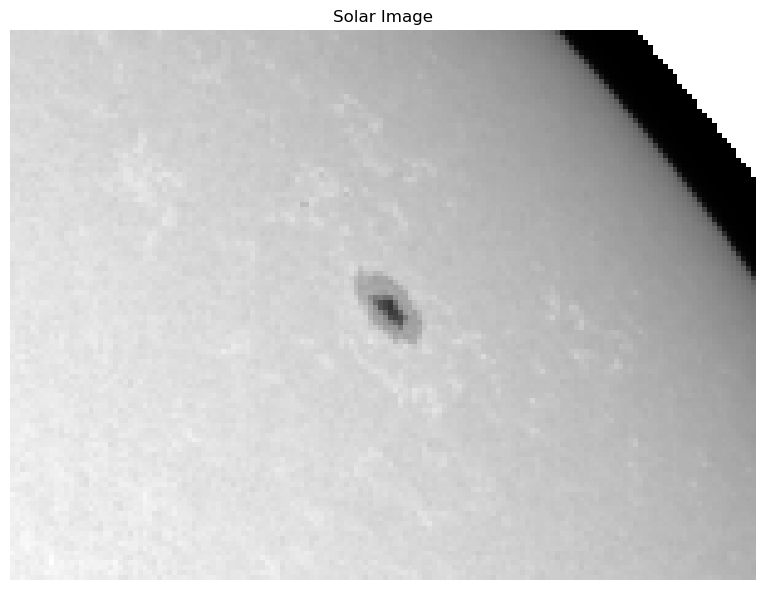

In [251]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import cv2

# Great article about the hough transform using open cv, cv2
# https://pyimagesearch.com/2014/07/21/detecting-circles-images-using-opencv-hough-circles/

# https://pillow.readthedocs.io/en/stable/reference/Image.html#PIL.Image.Image.convert
# Load and convert images to grayscale
solar_image = Image.open("../Solar_disk_hough_transformation/sample_images/20110110_065810_AR11140 copy.png").convert("L")

# Convert the images to NumPy arrays
solar_image_array = np.array(solar_image, dtype=np.uint8)

# Print min and max values for coin image
print("solar_image_array max", solar_image_array.max())
print("solar_image_array min", solar_image_array.min())

# Create a figure with 1 row and 2 columns for the images
fig, axs = plt.subplots(figsize=(12, 6))

# Display the first image with a title on top
axs.imshow(solar_image_array, cmap='gray')
axs.set_title("Solar Image")
axs.axis('off')  # Turn off axis labels

# Adjust layout and show the plot
plt.tight_layout()
plt.show()


Image ../Solar_disk_hough_transformation/sample_images/20110110_065810_AR11140 copy.png: Circle at (112, 40) with radius 39 has 48.0 votes
Image ../Solar_disk_hough_transformation/sample_images/20110110_065810_AR11140 copy.png: Circle at (58, 88) with radius 99 has 47.0 votes
Image ../Solar_disk_hough_transformation/sample_images/20110110_065810_AR11140 copy.png: Circle at (89, 71) with radius 64 has 37.0 votes
Image ../Solar_disk_hough_transformation/sample_images/20110110_065810_AR11140 copy.png: Circle at (82, 7) with radius 48 has 26.0 votes
Image ../Solar_disk_hough_transformation/sample_images/20110110_065810_AR11140 copy.png: Circle at (148, 0) with radius 30 has 26.0 votes
Image ../Solar_disk_hough_transformation/sample_images/20110110_065810_AR11140 copy.png: Circle at (136, 71) with radius 60 has 22.0 votes
Image ../Solar_disk_hough_transformation/sample_images/20110110_065810_AR11140 copy.png: Circle at (139, 111) with radius 85 has 20.0 votes


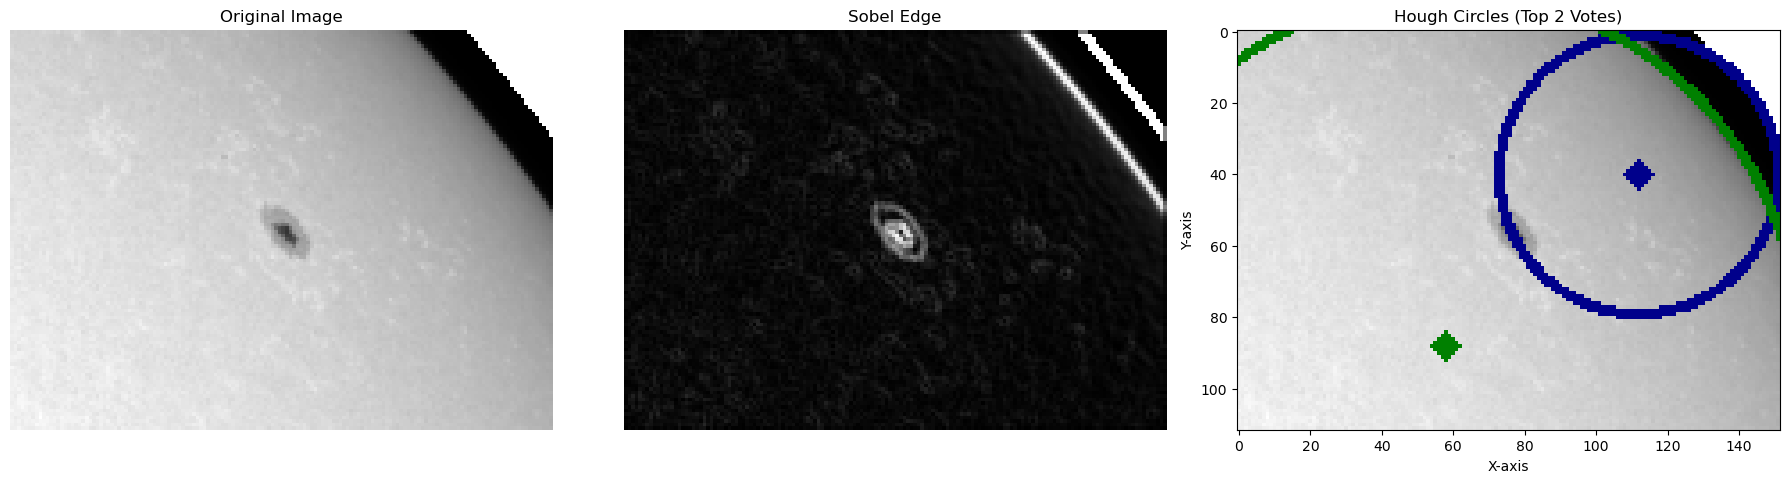

In [253]:
# Here, I am using sobel edge and than hough circle.
# I am detecting two circles, one of the highest vote and another with the second highest vote. 

import cv2
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from skimage.transform import hough_circle, hough_circle_peaks
import glob

def process_image(image_path):
    # --- Load and Prepare the Image ---
    # Convert to grayscale and load as numpy array
    solar_image = Image.open(image_path).convert("L")
    original = np.array(solar_image, dtype=np.uint8)
    
    # --- Built-in Sobel Edge Detection ---
    # Compute Sobel gradients in X and Y directions
    sobel_x = cv2.Sobel(original, cv2.CV_64F, 1, 0, ksize=3)
    sobel_y = cv2.Sobel(original, cv2.CV_64F, 0, 1, ksize=3)
    
    # Convert gradients to absolute values (8-bit)
    abs_sobel_x = cv2.convertScaleAbs(sobel_x)
    abs_sobel_y = cv2.convertScaleAbs(sobel_y)
    
    # Combine the two gradients to get the overall edge image
    edge_image = cv2.addWeighted(abs_sobel_x, 0.5, abs_sobel_y, 0.5, 0)
    
    # Threshold the edge image to create a binary image
    # Thresholding:
        # thresholdValue = 50 
        # If a pixel value is ≥ thresholdValue, it becomes 255 (white).
        # If a pixel value is < thresholdValue, it becomes 0 (black).
    _, edge_thresh = cv2.threshold(edge_image, 50, 255, cv2.THRESH_BINARY)
    
    # --- Hough Circle Detection using scikit-image ---
    # Define the range of radii to search for
    radii = np.arange(20, 101, 1)  # From 20 to 100, step of 1
    
    # Compute the Hough Transform for the specified radii
    hough_res = hough_circle(edge_thresh, radii, normalize=False)
    
    # Find the peaks (detected circles) in the Hough accumulator
    accums, cx, cy, detected_radii = hough_circle_peaks(
        hough_res, radii,
        min_xdistance=30, min_ydistance=30,
        threshold=0.4 * np.max(hough_res),
        total_num_peaks=10
    )
    
    # Print the votes and radius for each detected circle
    for accum, x, y, r in zip(accums, cx, cy, detected_radii):
        print(f"Image {image_path}: Circle at ({x}, {y}) with radius {r} has {accum} votes")
    
    # Determine indices for the top two circles based on votes
    if len(accums) > 1:
        sorted_indices = np.argsort(accums)[::-1]
        max_vote_index = sorted_indices[0]
        second_vote_index = sorted_indices[1]
    elif len(accums) == 1:
        max_vote_index = 0
        second_vote_index = None
    else:
        max_vote_index = None
        second_vote_index = None

    # --- Draw the Detected Circles ---
    # Create a color copy of the original image for drawing
    annotated_image = cv2.cvtColor(original, cv2.COLOR_GRAY2BGR)
    
    for i, (x, y, r) in enumerate(zip(cx, cy, detected_radii)):
        if max_vote_index is not None and i == max_vote_index:
            # Dark blue for the circle with the highest vote (BGR: 139, 0, 0)
            cv2.circle(annotated_image, (x, y), int(r), (139, 0, 0), 2)
            cv2.circle(annotated_image, (x, y), 2, (139, 0, 0), 3)
        elif second_vote_index is not None and i == second_vote_index:
            # Dark green for the circle with the second highest vote (BGR: 0, 128, 0)
            cv2.circle(annotated_image, (x, y), int(r), (0, 128, 0), 2)
            cv2.circle(annotated_image, (x, y), 2, (0, 128, 0), 3)
        # If desired, uncomment below to draw remaining circles in another color:
        # else:
        #     cv2.circle(annotated_image, (x, y), int(r), (0, 0, 255), 2)
        #     cv2.circle(annotated_image, (x, y), 2, (0, 255, 0), 3)
    
    return original, edge_image, annotated_image

def process_images(image_paths):
    """
    Process a list of image paths and display three images for each:
    original, edge, and annotated (with Hough circles).
    
    Args:
        image_paths (list): List of file paths to images.
        
    Returns:
        results (dict): Dictionary mapping image path to a tuple of
                        (original, edge, annotated) images.
    """
    results = {}
    
    for image_path in image_paths:
        orig, edge, annotated = process_image(image_path)
        results[image_path] = (orig, edge, annotated)
        
        # --- Display the Results for the current image ---
        fig, axs = plt.subplots(1, 3, figsize=(18, 6))
        
        # Original image with axes turned off
        axs[0].imshow(orig, cmap="gray")
        axs[0].set_title("Original Image")
        axs[0].axis("off")
        
        # Edge image with axes turned off
        axs[1].imshow(edge, cmap="gray")
        axs[1].set_title("Sobel Edge")
        axs[1].axis("off")
        
        # Annotated image with circles and axes on
        axs[2].imshow(cv2.cvtColor(annotated, cv2.COLOR_BGR2RGB))
        axs[2].set_title("Hough Circles (Top 2 Votes)")
        axs[2].axis("on")
        axs[2].set_xlabel("X-axis")
        axs[2].set_ylabel("Y-axis")
        
        plt.tight_layout()
        plt.show()
    
    return results

# Example usage:
# Get all PNG images from the sample_images folder.
image_files = glob.glob("../Solar_disk_hough_transformation/sample_images/20110110_065810_AR11140 copy.png")
results = process_images(image_files)

Detected solar disk at (28, 108) with radius 134


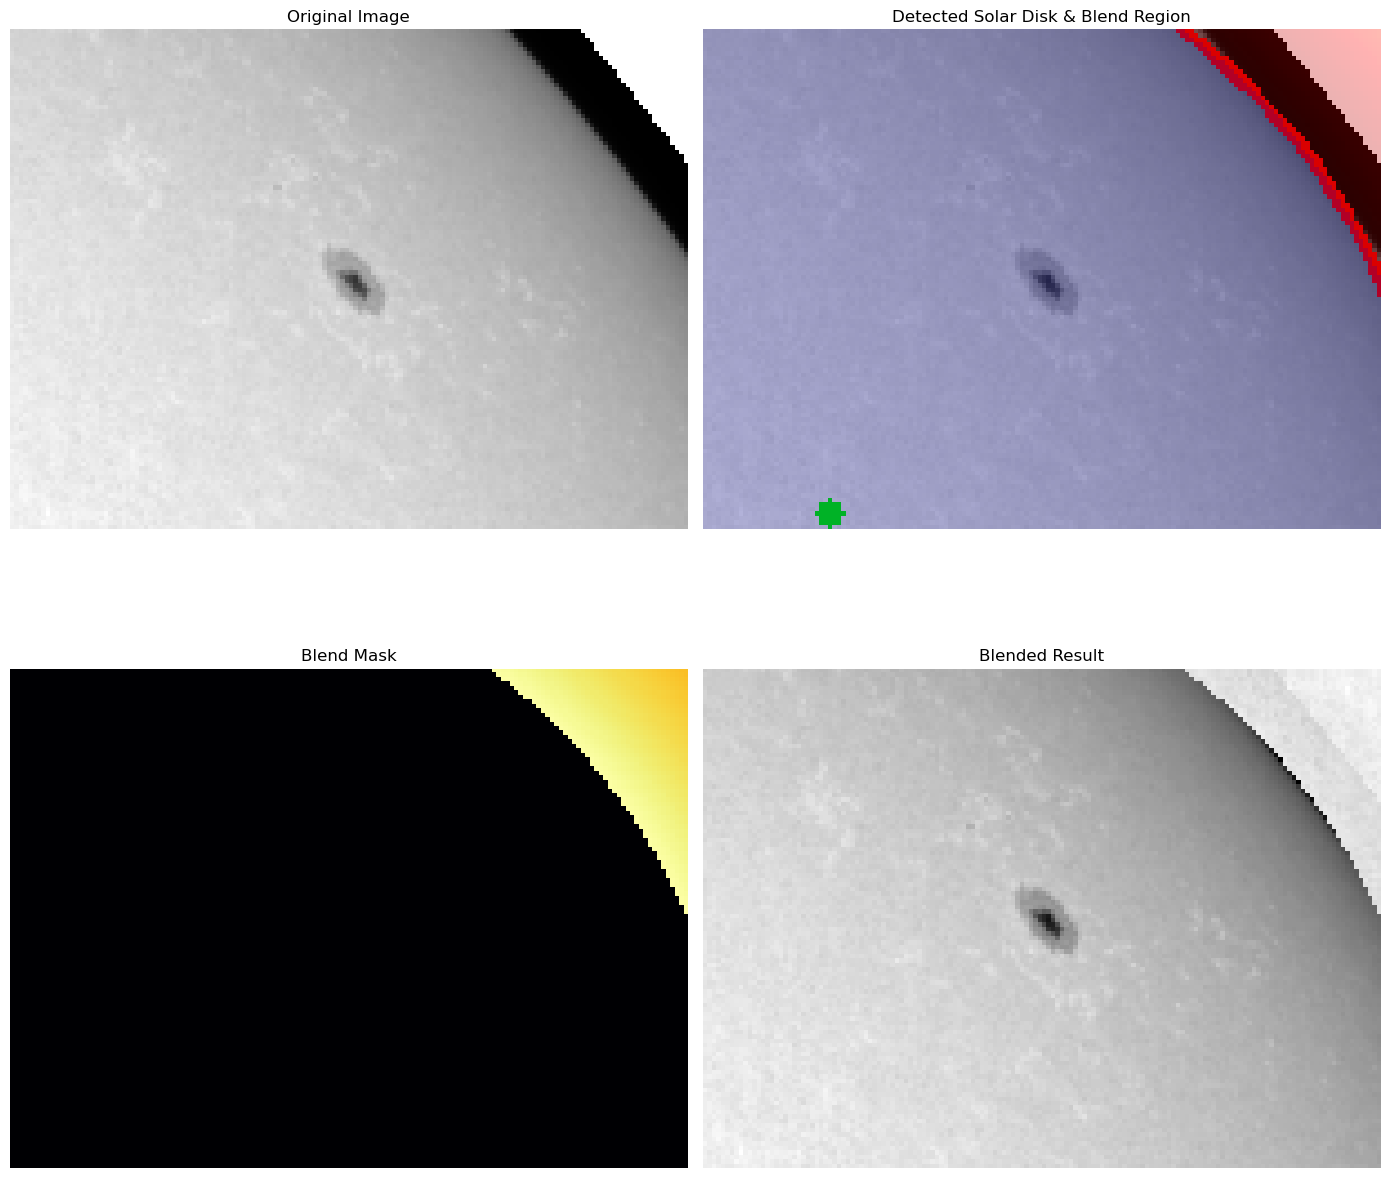

In [257]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from skimage.transform import hough_circle, hough_circle_peaks
import glob

edge_width_value = 100

def process_image_with_full_blending(image_path, edge_width=35):
    """
    Process a solar image to detect the solar disk and blend everything 
    from the edge of the sun to the corner of the image (upper part only).
    
    Args:
        image_path (str): Path to the solar image.
        edge_width (int): Width parameter for blending control.
        
    Returns:
        tuple: Original image, annotated image, processed image, and mask.
    """
    # --- Load and Prepare the Image ---
    solar_image = Image.open(image_path).convert("L")
    original = np.array(solar_image, dtype=np.uint8)
    height, width = original.shape
    
    # --- Sobel Edge Detection for circle finding ---
    sobel_x = cv2.Sobel(original, cv2.CV_64F, 1, 0, ksize=3)
    sobel_y = cv2.Sobel(original, cv2.CV_64F, 0, 1, ksize=3)
    
    abs_sobel_x = cv2.convertScaleAbs(sobel_x)
    abs_sobel_y = cv2.convertScaleAbs(sobel_y)
    
    edge_image = cv2.addWeighted(abs_sobel_x, 0.5, abs_sobel_y, 0.5, 0)
    _, edge_thresh = cv2.threshold(edge_image, 50, 255, cv2.THRESH_BINARY)
    
    # --- Hough Circle Detection to find the solar disk ---
    radii = np.arange(50, 150, 2)  # Adjust range based on your images
    
    hough_res = hough_circle(edge_thresh, radii, normalize=False)
    
    accums, cx, cy, detected_radii = hough_circle_peaks(
        hough_res, radii,
        min_xdistance=50, min_ydistance=50,
        threshold=0.5 * np.max(hough_res),
        total_num_peaks=3
    )
    
    # --- Create annotated image ---
    annotated_image = cv2.cvtColor(original, cv2.COLOR_GRAY2BGR)
    blended_image = original.copy()
    
    # We need at least one circle to proceed
    if len(accums) > 0:
        # Get the circle with highest votes (the solar disk)
        max_idx = np.argmax(accums)
        x, y, r = cx[max_idx], cy[max_idx], detected_radii[max_idx]
        
        print(f"Detected solar disk at ({x}, {y}) with radius {r}")
        
        # Draw the circle on the annotated image
        cv2.circle(annotated_image, (x, y), int(r), (0, 0, 255), 2)
        cv2.circle(annotated_image, (x, y), 3, (0, 255, 0), -1)
        
        # --- Create a mask for the upper part of the image from the solar edge to the top corner ---
        blend_mask = np.zeros((height, width), dtype=np.float32)
        
        # Create a mask where everything inside the circle is 0, everything outside is 1
        full_mask = np.ones((height, width), dtype=np.float32)
        cv2.circle(full_mask, (x, y), int(r), 0, -1)
        
        # Only keep the upper part (above the center of the circle)
        for i in range(height):
            for j in range(width):
                if i > y:  # Only blend the upper part (assuming image coordinates have origin at top-left)
                    full_mask[i, j] = 0
        
        blend_mask = full_mask
        
        # --- Find opposite area to sample from ---
        # Determine which part of the image to sample from (use the lower part)
        # This is the area opposite to where the blending will happen
        
        # Create a weighted transition for smoother blending
        # Measure distance from the edge of the circle
        for i in range(height):
            for j in range(width):
                if blend_mask[i, j] > 0:
                    # Calculate distance from the circle edge
                    dist_to_center = np.sqrt((j - x)**2 + (i - y)**2)
                    dist_from_edge = dist_to_center - r
                    
                    # Create a gradient that decreases as we move away from the edge
                    # This makes the blending smoother
                    weight = max(0, min(1, 1 - dist_from_edge / (edge_width * 2)))
                    blend_mask[i, j] = weight
        
        # --- Sample from the opposite part of the image ---
        # Calculate the opposite coordinates
        center_x, center_y = width // 2, height // 2
        
        # Process all pixels where blend_mask > 0
        for i in range(height):
            for j in range(width):
                if blend_mask[i, j] > 0:
                    # Vector from center to this point
                    vec_to_edge_x = j - center_x
                    vec_to_edge_y = i - center_y
                    
                    # Opposite point (mirrored across center)
                    opp_x = int(center_x - vec_to_edge_x)
                    opp_y = int(center_y - vec_to_edge_y)
                    
                    # Ensure within bounds
                    opp_x = max(0, min(width - 1, opp_x))
                    opp_y = max(0, min(height - 1, opp_y))
                    
                    # Apply blending with weight from mask
                    weight = blend_mask[i, j]
                    blended_image[i, j] = int((1 - weight) * original[i, j] + weight * original[opp_y, opp_x])
        
        # --- Mark the blending area in the annotated image ---
        # Create a visualization of the blend mask for the annotated image
        blend_viz = np.uint8(blend_mask * 255)
        blend_viz_color = cv2.applyColorMap(blend_viz, cv2.COLORMAP_JET)
        
        # Overlay the blend mask visualization on the annotated image with transparency
        alpha = 0.3
        cv2.addWeighted(blend_viz_color, alpha, annotated_image, 1 - alpha, 0, annotated_image)
    
    return original, annotated_image, blended_image, blend_mask

def display_results(orig, annotated, blended, blend_mask):
    """
    Display the results from image processing.
    """
    fig, axs = plt.subplots(2, 2, figsize=(14, 14))
    
    # Original image
    axs[0, 0].imshow(orig, cmap="gray")
    axs[0, 0].set_title("Original Image")
    axs[0, 0].axis("off")
    
    # Annotated image showing circle and blend region
    axs[0, 1].imshow(cv2.cvtColor(annotated, cv2.COLOR_BGR2RGB))
    axs[0, 1].set_title("Detected Solar Disk & Blend Region")
    axs[0, 1].axis("off")
    
    # Blend mask
    axs[1, 0].imshow(blend_mask, cmap="inferno")
    axs[1, 0].set_title("Blend Mask")
    axs[1, 0].axis("off")
    
    # Blended image
    axs[1, 1].imshow(blended, cmap="gray")
    axs[1, 1].set_title("Blended Result")
    axs[1, 1].axis("off")
    
    plt.tight_layout()
    plt.show()

# Example usage:
if __name__ == "__main__":
    # Get the image path
    image_files = glob.glob("../Solar_disk_hough_transformation/sample_images/20110110_065810_AR11140 copy.png")
    
    # Process each image
    for image_path in image_files:
        orig, annotated, blended, blend_mask = process_image_with_full_blending(
            image_path, 
            edge_width=edge_width_value
        )
        
        # Display the results
        display_results(orig, annotated, blended, blend_mask)

Detected solar disk at (28, 108) with radius 134


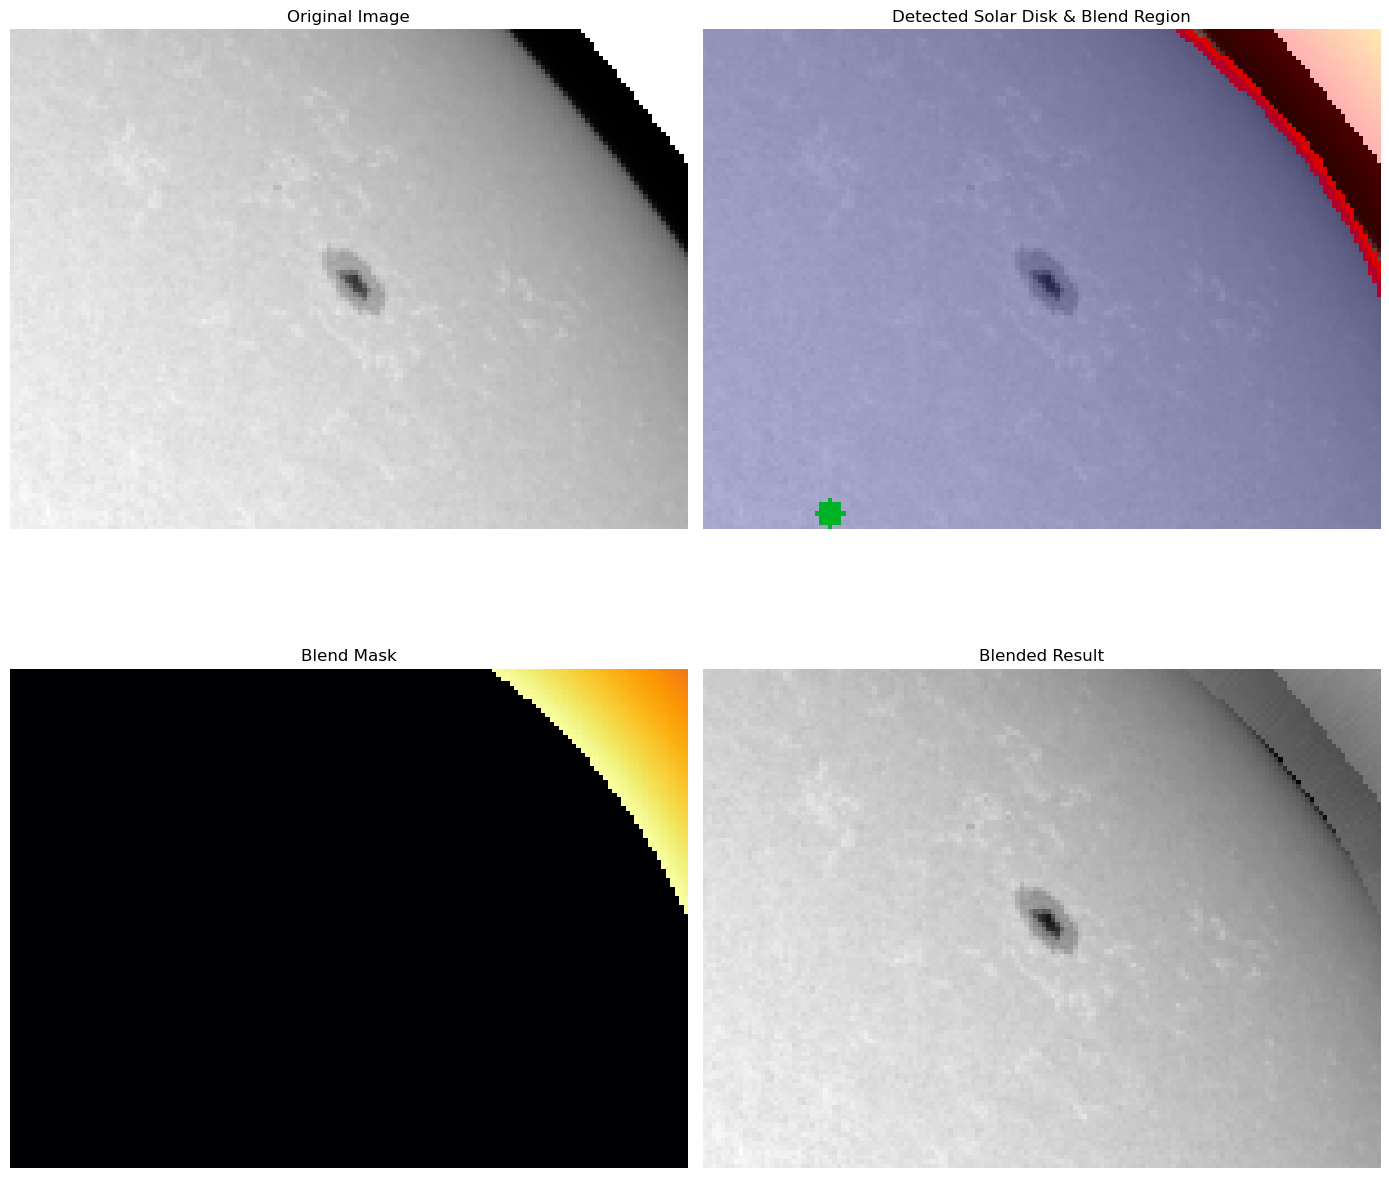

In [260]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from skimage.transform import hough_circle, hough_circle_peaks
import glob

edge_width_value = 100

def process_image_with_improved_blending(image_path, edge_width=35):
    """
    Process a solar image to detect the solar disk and blend everything 
    from the edge of the sun to the corner of the image (upper part only).
    
    Args:
        image_path (str): Path to the solar image.
        edge_width (int): Width parameter for blending control.
        
    Returns:
        tuple: Original image, annotated image, processed image, and mask.
    """
    # --- Load and Prepare the Image ---
    solar_image = Image.open(image_path).convert("L")
    original = np.array(solar_image, dtype=np.uint8)
    height, width = original.shape
    
    # --- Sobel Edge Detection for circle finding ---
    sobel_x = cv2.Sobel(original, cv2.CV_64F, 1, 0, ksize=3)
    sobel_y = cv2.Sobel(original, cv2.CV_64F, 0, 1, ksize=3)
    
    abs_sobel_x = cv2.convertScaleAbs(sobel_x)
    abs_sobel_y = cv2.convertScaleAbs(sobel_y)
    
    edge_image = cv2.addWeighted(abs_sobel_x, 0.5, abs_sobel_y, 0.5, 0)
    _, edge_thresh = cv2.threshold(edge_image, 50, 255, cv2.THRESH_BINARY)
    
    # --- Hough Circle Detection to find the solar disk ---
    radii = np.arange(50, 150, 2)  # Adjust range based on your images
    
    hough_res = hough_circle(edge_thresh, radii, normalize=False)
    
    accums, cx, cy, detected_radii = hough_circle_peaks(
        hough_res, radii,
        min_xdistance=50, min_ydistance=50,
        threshold=0.5 * np.max(hough_res),
        total_num_peaks=3
    )
    
    # --- Create annotated image ---
    annotated_image = cv2.cvtColor(original, cv2.COLOR_GRAY2BGR)
    blended_image = original.copy()
    blend_mask = np.zeros((height, width), dtype=np.float32)
    
    # We need at least one circle to proceed
    if len(accums) > 0:
        # Get the circle with highest votes (the solar disk)
        max_idx = np.argmax(accums)
        x, y, r = cx[max_idx], cy[max_idx], detected_radii[max_idx]
        
        print(f"Detected solar disk at ({x}, {y}) with radius {r}")
        
        # Draw the circle on the annotated image
        cv2.circle(annotated_image, (x, y), int(r), (0, 0, 255), 2)
        cv2.circle(annotated_image, (x, y), 3, (0, 255, 0), -1)
        
        # --- Create a mask for the upper part of the image from the solar edge to the top corner ---
        
        # Create a mask where everything inside the circle is 0, everything outside is 1
        full_mask = np.ones((height, width), dtype=np.float32)
        cv2.circle(full_mask, (x, y), int(r), 0, -1)
        
        # Only keep the upper part (above the center of the circle)
        for i in range(height):
            for j in range(width):
                if i > y:  # Only blend the upper part (assuming image coordinates have origin at top-left)
                    full_mask[i, j] = 0
        
        blend_mask = full_mask.copy()
        
        # --- Create a weighted transition for smoother blending ---
        # Measure distance from the edge of the circle
        for i in range(height):
            for j in range(width):
                if full_mask[i, j] > 0:
                    # Calculate distance from the circle edge
                    dist_to_center = np.sqrt((j - x)**2 + (i - y)**2)
                    dist_from_edge = dist_to_center - r
                    
                    # Create a gradient that decreases as we move away from the edge
                    weight = max(0, min(1, 1 - dist_from_edge / edge_width))
                    blend_mask[i, j] = weight
        
        # --- IMPROVED BLENDING: Sample from just inside the solar disk edge ---
        for i in range(height):
            for j in range(width):
                if blend_mask[i, j] > 0:
                    # Calculate the vector from center to this point
                    vec_x = j - x
                    vec_y = i - y
                    
                    # Calculate the distance from center to this point
                    dist = np.sqrt(vec_x**2 + vec_y**2)
                    
                    # Normalize the vector
                    if dist > 0:
                        vec_x = vec_x / dist
                        vec_y = vec_y / dist
                    
                    # Calculate a point just inside the solar disk edge (2-5 pixels inside)
                    inside_r = r - 3  # Sample from 3 pixels inside the edge
                    
                    # Calculate coordinates of the sampling point
                    sample_x = int(x + vec_x * inside_r)
                    sample_y = int(y + vec_y * inside_r)
                    
                    # Ensure within bounds
                    sample_x = max(0, min(width - 1, sample_x))
                    sample_y = max(0, min(height - 1, sample_y))
                    
                    # Apply blending with weight from mask
                    weight = blend_mask[i, j]
                    blended_image[i, j] = int((1 - weight) * original[i, j] + weight * original[sample_y, sample_x])
        
        # --- Mark the blending area in the annotated image ---
        # Create a visualization of the blend mask for the annotated image
        blend_viz = np.uint8(blend_mask * 255)
        blend_viz_color = cv2.applyColorMap(blend_viz, cv2.COLORMAP_JET)
        
        # Overlay the blend mask visualization on the annotated image with transparency
        alpha = 0.3
        cv2.addWeighted(blend_viz_color, alpha, annotated_image, 1 - alpha, 0, annotated_image)
    
    return original, annotated_image, blended_image, blend_mask

def display_results(orig, annotated, blended, blend_mask):
    """
    Display the results from image processing.
    """
    fig, axs = plt.subplots(2, 2, figsize=(14, 14))
    
    # Original image
    axs[0, 0].imshow(orig, cmap="gray")
    axs[0, 0].set_title("Original Image")
    axs[0, 0].axis("off")
    
    # Annotated image showing circle and blend region
    axs[0, 1].imshow(cv2.cvtColor(annotated, cv2.COLOR_BGR2RGB))
    axs[0, 1].set_title("Detected Solar Disk & Blend Region")
    axs[0, 1].axis("off")
    
    # Blend mask
    axs[1, 0].imshow(blend_mask, cmap="inferno")
    axs[1, 0].set_title("Blend Mask")
    axs[1, 0].axis("off")
    
    # Blended image
    axs[1, 1].imshow(blended, cmap="gray")
    axs[1, 1].set_title("Blended Result")
    axs[1, 1].axis("off")
    
    plt.tight_layout()
    plt.show()

# Example usage:
if __name__ == "__main__":
    # Get the image path
    image_files = glob.glob("../Solar_disk_hough_transformation/sample_images/20110110_065810_AR11140 copy.png")
    
    # Process each image
    for image_path in image_files:
        orig, annotated, blended, blend_mask = process_image_with_improved_blending(
            image_path, 
            edge_width=edge_width_value
        )
        
        # Display the results
        display_results(orig, annotated, blended, blend_mask)
        

Detected solar disk at (28, 108) with radius 134


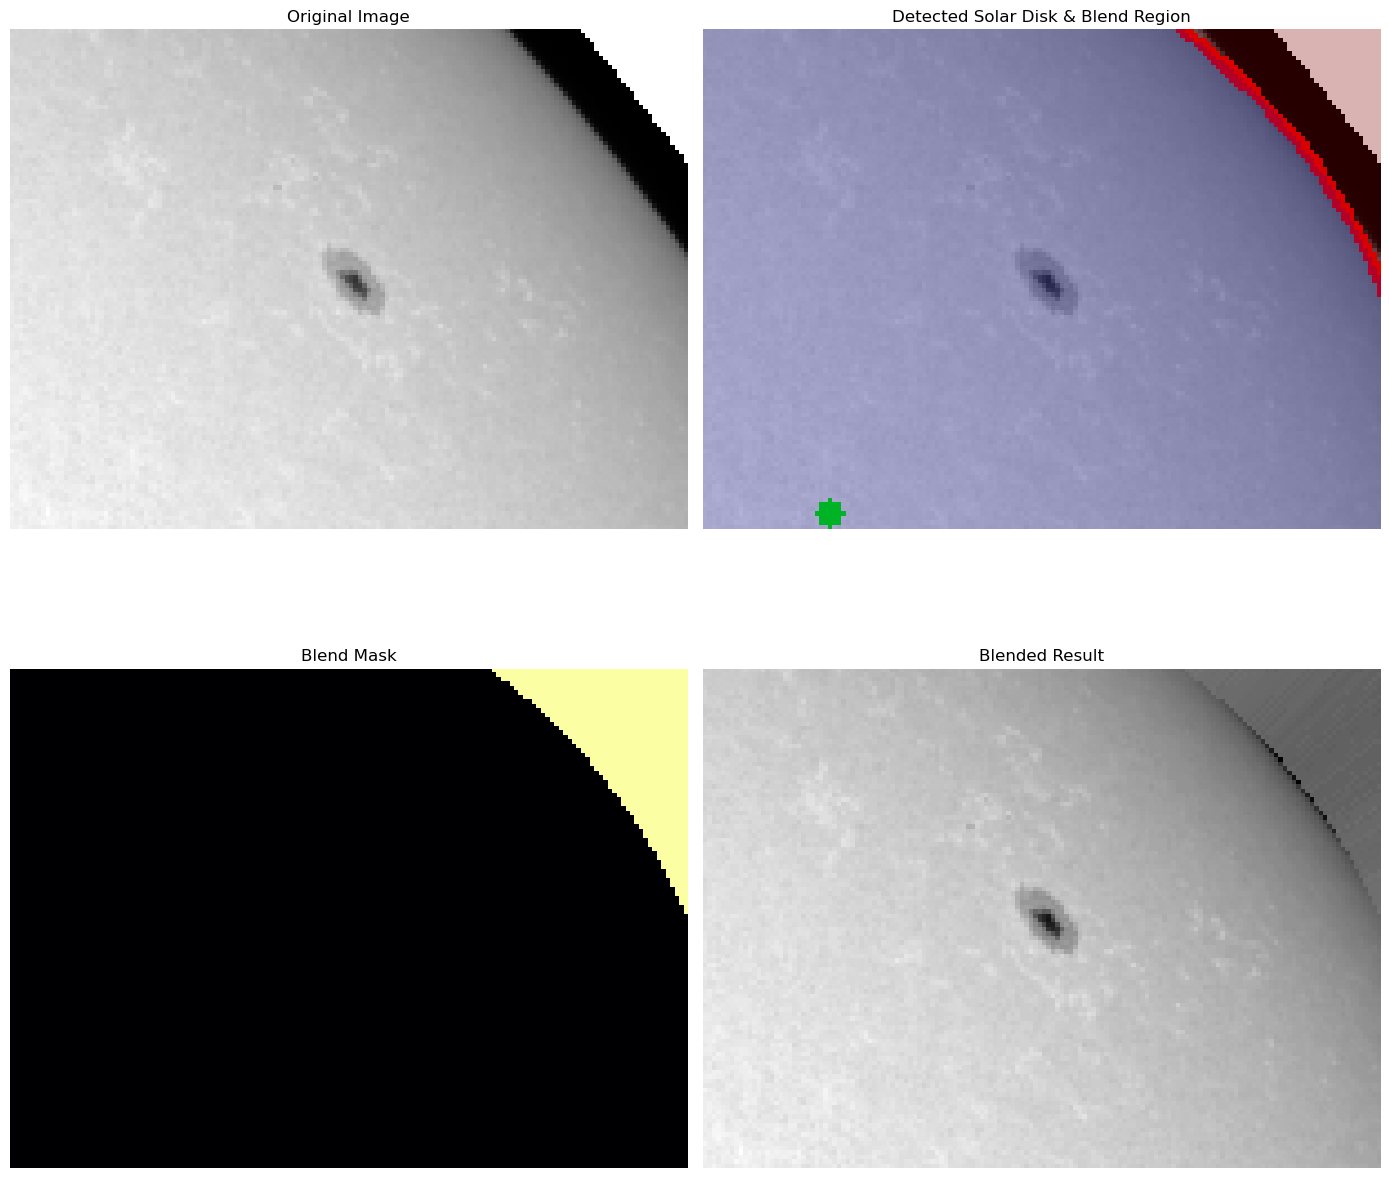

In [264]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from skimage.transform import hough_circle, hough_circle_peaks
import glob

edge_width_value = 100

def process_image_with_improved_blending(image_path, edge_width=35):
    """
    Process a solar image to detect the solar disk and replace pixel values 
    in the upper part outside the disk with values sampled from inside the disk.
    
    Args:
        image_path (str): Path to the solar image.
        edge_width (int): Kept for compatibility, but not used in blending.
        
    Returns:
        tuple: Original image, annotated image, processed image, and mask.
    """
    # --- Load and Prepare the Image ---
    solar_image = Image.open(image_path).convert("L")
    original = np.array(solar_image, dtype=np.uint8)
    height, width = original.shape
    
    # --- Sobel Edge Detection for circle finding ---
    sobel_x = cv2.Sobel(original, cv2.CV_64F, 1, 0, ksize=3)
    sobel_y = cv2.Sobel(original, cv2.CV_64F, 0, 1, ksize=3)
    
    abs_sobel_x = cv2.convertScaleAbs(sobel_x)
    abs_sobel_y = cv2.convertScaleAbs(sobel_y)
    
    edge_image = cv2.addWeighted(abs_sobel_x, 0.5, abs_sobel_y, 0.5, 0)
    _, edge_thresh = cv2.threshold(edge_image, 50, 255, cv2.THRESH_BINARY)
    
    # --- Hough Circle Detection to find the solar disk ---
    radii = np.arange(50, 150, 2)
    hough_res = hough_circle(edge_thresh, radii, normalize=False)
    
    accums, cx, cy, detected_radii = hough_circle_peaks(
        hough_res, radii,
        min_xdistance=50, min_ydistance=50,
        threshold=0.5 * np.max(hough_res),
        total_num_peaks=3
    )
    
    # --- Create annotated image ---
    annotated_image = cv2.cvtColor(original, cv2.COLOR_GRAY2BGR)
    blended_image = original.copy()
    blend_mask = np.zeros((height, width), dtype=np.float32)
    
    if len(accums) > 0:
        # Get the circle with highest votes
        max_idx = np.argmax(accums)
        x, y, r = cx[max_idx], cy[max_idx], detected_radii[max_idx]
        
        print(f"Detected solar disk at ({x}, {y}) with radius {r}")
        
        # Draw the circle on the annotated image
        cv2.circle(annotated_image, (x, y), int(r), (0, 0, 255), 2)
        cv2.circle(annotated_image, (x, y), 3, (0, 255, 0), -1)
        
        # --- Create a mask for the upper part outside the solar disk ---
        full_mask = np.ones((height, width), dtype=np.float32)
        cv2.circle(full_mask, (x, y), int(r), 0, -1)
        
        # Restrict to upper part
        for i in range(height):
            for j in range(width):
                if i > y:
                    full_mask[i, j] = 0
        
        # Optional: Keep blend_mask for visualization (binary version)
        blend_mask = full_mask.copy()
        
        # --- Replace pixels with sampled values from inside the solar disk ---
        for i in range(height):
            for j in range(width):
                if full_mask[i, j] > 0:
                    vec_x = j - x
                    vec_y = i - y
                    dist = np.sqrt(vec_x**2 + vec_y**2)
                    
                    if dist > 0:
                        vec_x = vec_x / dist
                        vec_y = vec_y / dist
                    
                    inside_r = r - 3
                    sample_x = int(x + vec_x * inside_r)
                    sample_y = int(y + vec_y * inside_r)
                    
                    sample_x = max(0, min(width - 1, sample_x))
                    sample_y = max(0, min(height - 1, sample_y))
                    
                    blended_image[i, j] = original[sample_y, sample_x]
        
        # --- Visualize the replaced area in the annotated image ---
        blend_viz = np.uint8(blend_mask * 255)
        blend_viz_color = cv2.applyColorMap(blend_viz, cv2.COLORMAP_JET)
        alpha = 0.3
        cv2.addWeighted(blend_viz_color, alpha, annotated_image, 1 - alpha, 0, annotated_image)
    
    return original, annotated_image, blended_image, blend_mask

def display_results(orig, annotated, blended, blend_mask):
    """
    Display the results from image processing.
    """
    fig, axs = plt.subplots(2, 2, figsize=(14, 14))
    
    # Original image
    axs[0, 0].imshow(orig, cmap="gray")
    axs[0, 0].set_title("Original Image")
    axs[0, 0].axis("off")
    
    # Annotated image showing circle and blend region
    axs[0, 1].imshow(cv2.cvtColor(annotated, cv2.COLOR_BGR2RGB))
    axs[0, 1].set_title("Detected Solar Disk & Blend Region")
    axs[0, 1].axis("off")
    
    # Blend mask
    axs[1, 0].imshow(blend_mask, cmap="inferno")
    axs[1, 0].set_title("Blend Mask")
    axs[1, 0].axis("off")
    
    # Blended image
    axs[1, 1].imshow(blended, cmap="gray")
    axs[1, 1].set_title("Blended Result")
    axs[1, 1].axis("off")
    
    plt.tight_layout()
    plt.show()

# Example usage:
if __name__ == "__main__":
    # Get the image path
    image_files = glob.glob("../Solar_disk_hough_transformation/sample_images/20110110_065810_AR11140 copy.png")
    
    # Process each image
    for image_path in image_files:
        orig, annotated, blended, blend_mask = process_image_with_improved_blending(
            image_path, 
            edge_width=edge_width_value
        )
        
        # Display the results
        display_results(orig, annotated, blended, blend_mask)
        

Found 1 image(s). Processing...
Processing image: ../Solar_disk_hough_transformation/sample_images/20110110_065810_AR11140 copy.png (Dimensions: 152x112)
Attempting Hough Transform with radii from 16 to 61
Detected solar disk at (113, 40) with radius 38
Processing took 0.02 seconds.


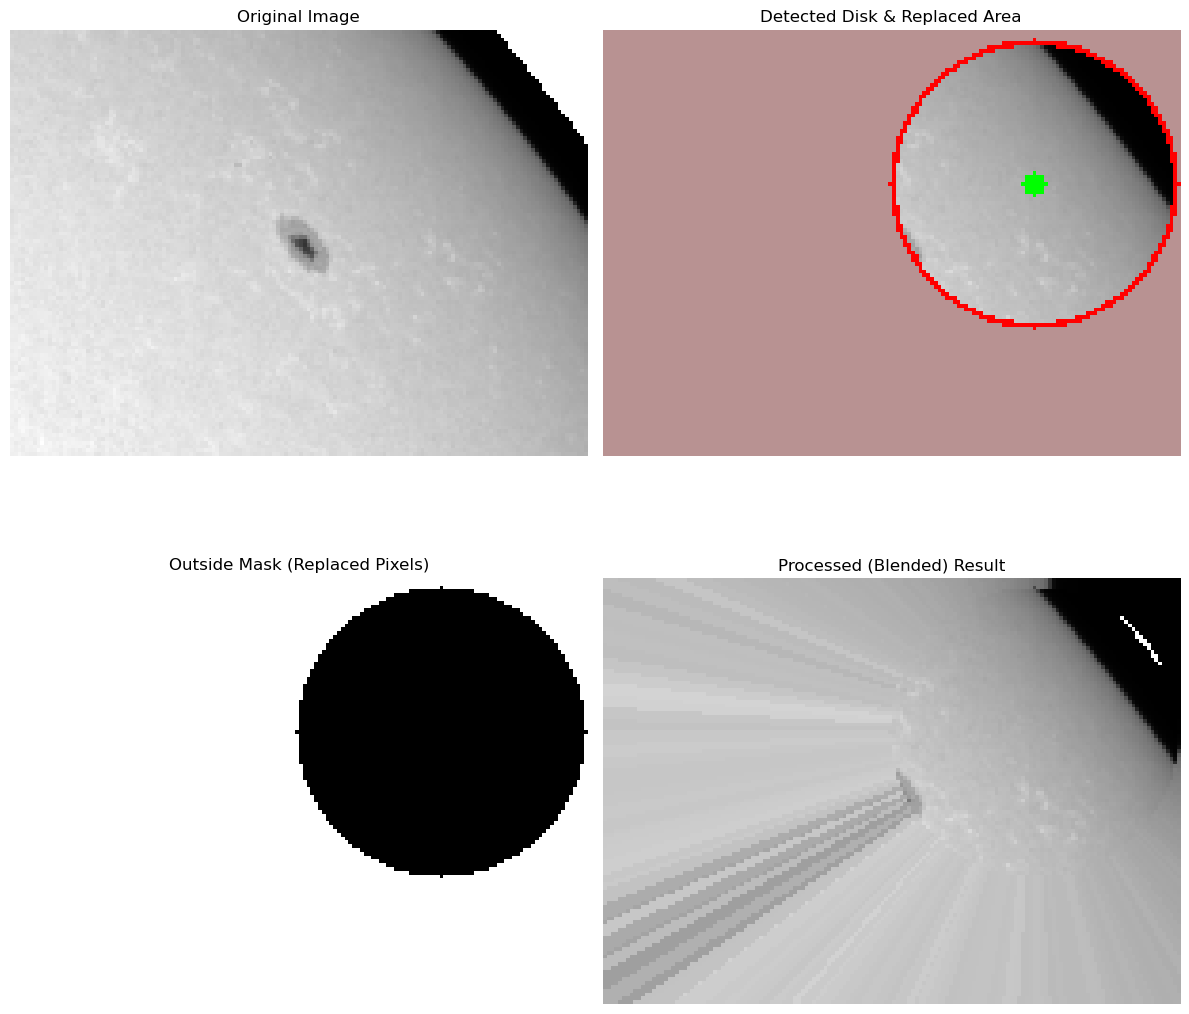

In [268]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from skimage.transform import hough_circle, hough_circle_peaks
import glob
import time # Optional: for timing performance

# Keep edge_width_value if you might use it later, otherwise, it can be removed.
edge_width_value = 100 # Currently unused in the main logic

def process_image_universal_edge(image_path):
    """
    Process a solar image to detect the solar disk and replace pixel values
    outside the disk with values sampled from just inside the disk boundary.
    Works regardless of where the disk edge is relative to the image boundaries.

    Args:
        image_path (str): Path to the solar image.

    Returns:
        tuple: Original image, annotated image, processed image, and mask,
               or (None, None, None, None) if processing fails early.
               Returns (original, original, original, empty_mask) if no circle detected.
    """
    start_time = time.time() # Optional timing

    # --- Load and Prepare the Image ---
    try:
        solar_image = Image.open(image_path).convert("L")
        original = np.array(solar_image, dtype=np.uint8)
    except FileNotFoundError:
        print(f"Error: Image file not found at {image_path}")
        return None, None, None, None
    except Exception as e:
        print(f"Error loading image {image_path}: {e}")
        return None, None, None, None

    height, width = original.shape
    print(f"Processing image: {image_path} (Dimensions: {width}x{height})")

    # --- Sobel Edge Detection for circle finding ---
    # Using a slightly larger ksize can sometimes help with noisy images
    sobel_x = cv2.Sobel(original, cv2.CV_64F, 1, 0, ksize=5)
    sobel_y = cv2.Sobel(original, cv2.CV_64F, 0, 1, ksize=5)

    # Calculate magnitude more robustly
    edge_mag = np.sqrt(sobel_x**2 + sobel_y**2)
    # Normalize magnitude to 0-255 range for thresholding
    if np.max(edge_mag) > 0:
       edge_norm = cv2.normalize(edge_mag, None, 0, 255, cv2.NORM_MINMAX)
       edge_image = np.uint8(edge_norm)
    else:
       edge_image = np.zeros_like(original, dtype=np.uint8) # Handle case of blank image


    # Adaptive thresholding might be more robust than a fixed threshold
    # edge_thresh = cv2.adaptiveThreshold(edge_image, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
    #                                     cv2.THRESH_BINARY, 11, 2)
    # Or stick to Otsu's method which is often good
    _, edge_thresh = cv2.threshold(edge_image, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    # Optional: Morphological closing to fill gaps in edges
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(3,3))
    edge_thresh = cv2.morphologyEx(edge_thresh, cv2.MORPH_CLOSE, kernel)


    # --- Hough Circle Detection to find the solar disk ---
    # Adjust radii range based on expected solar disk size relative to image dimensions
    min_radius = int(min(height, width) * 0.15) # Example: 15% of smallest dimension
    max_radius = int(min(height, width) * 0.55) # Example: 55% of smallest dimension
    step = 2
    # Ensure min_radius is substantially smaller than max_radius
    if max_radius <= min_radius:
         max_radius = min_radius + 2*step # Ensure at least a few radii steps
         print(f"Warning: Adjusted max_radius to {max_radius} based on min_radius {min_radius}")
    if min_radius < 5: # Skimage hough_circle needs radii >= 1, practically >= ~5 works better
         min_radius = 5
         print(f"Warning: Clamped min_radius to {min_radius}")

    # Check if range is valid before calling hough_circle
    if max_radius > min_radius:
      radii = np.arange(min_radius, max_radius, step)
      print(f"Attempting Hough Transform with radii from {min_radius} to {max_radius}")
      hough_res = hough_circle(edge_thresh, radii, normalize=False) # Normalize=False is often faster

      # Adjust peak finding parameters if needed
      accums, cx, cy, detected_radii = hough_circle_peaks(
          hough_res, radii,
          min_xdistance=min_radius, min_ydistance=min_radius, # Ensure centers are reasonably spaced
          threshold=0.4 * np.max(hough_res) if np.max(hough_res) > 0 else 0.1, # Relative threshold
          total_num_peaks=5 # Look for a few potential candidates
      )
    else:
      print("Warning: Invalid radius range for Hough Transform. Skipping circle detection.")
      accums, cx, cy, detected_radii = [], [], [], []


    # --- Initialize output images and mask ---
    # Create BGR annotated image for colored drawings
    annotated_image = cv2.cvtColor(original, cv2.COLOR_GRAY2BGR)
    # Start with blended image as a copy of original
    blended_image = original.copy()
    # Mask will identify pixels *outside* the final chosen circle
    outside_mask = np.zeros((height, width), dtype=np.uint8)

    if len(accums) > 0:
        # --- Select the Best Circle Candidate ---
        # Often, the highest accumulator is best, but sometimes criteria like
        # proximity to center or a specific radius range might be relevant.
        # Here, we stick to the highest accumulator value.
        max_idx = np.argmax(accums)
        x, y, r = int(round(cx[max_idx])), int(round(cy[max_idx])), int(round(detected_radii[max_idx]))

        print(f"Detected solar disk at ({x}, {y}) with radius {r}")

        # Draw the detected circle on the annotated image
        cv2.circle(annotated_image, (x, y), r, (0, 0, 255), 2)  # Red circle
        cv2.circle(annotated_image, (x, y), 3, (0, 255, 0), -1) # Green center

        # --- Create a mask for ALL areas OUTSIDE the solar disk ---
        # Start with a mask that is 1 (True) everywhere
        outside_mask = np.ones((height, width), dtype=np.uint8)
        # Set the area INSIDE the circle to 0 (False)
        cv2.circle(outside_mask, (x, y), r, 0, -1)

        # --- Optimized Pixel Replacement using NumPy Indexing ---
        # Find coordinates (indices) of all pixels outside the circle
        outside_coords = np.argwhere(outside_mask > 0) # Gives [[y1, x1], [y2, x2], ...]

        if outside_coords.shape[0] > 0: # Check if there are any pixels outside
            # Extract y and x coordinates separately
            yy_outside = outside_coords[:, 0]
            xx_outside = outside_coords[:, 1]

            # Calculate vectors from center to each outside point
            vec_x = xx_outside - x
            vec_y = yy_outside - y

            # Calculate distance from center
            dist = np.sqrt(vec_x**2 + vec_y**2)

            # Normalize vectors (handle potential division by zero if dist is 0, though unlikely here)
            # Add a small epsilon to prevent division by zero, although points where mask=1 should be outside r>0
            epsilon = 1e-6
            norm_vec_x = vec_x / (dist + epsilon)
            norm_vec_y = vec_y / (dist + epsilon)

            # Calculate sample points just INSIDE the radius r
            # Subtracting a small fixed value (e.g., 3-5 pixels) is simple.
            # Alternatively, subtract a fraction of the radius (e.g., r * 0.02)
            sampling_radius_offset = 3
            inside_r = max(1, r - sampling_radius_offset) # Ensure radius doesn't go below 1

            sample_x_float = x + norm_vec_x * inside_r
            sample_y_float = y + norm_vec_y * inside_r

            # Convert sample coordinates to integers for indexing
            sample_x = sample_x_float.astype(int)
            sample_y = sample_y_float.astype(int)

            # Clip coordinates to ensure they are within image bounds
            sample_x = np.clip(sample_x, 0, width - 1)
            sample_y = np.clip(sample_y, 0, height - 1)

            # Sample the pixel values from the original image at the calculated inside points
            sampled_values = original[sample_y, sample_x]

            # Replace the pixels in the blended_image at the outside coordinates
            blended_image[yy_outside, xx_outside] = sampled_values

            # --- Visualize the replaced area (outside_mask) in the annotated image ---
            # Use a colored overlay for the mask
            blend_viz_color = cv2.applyColorMap(outside_mask * 255, cv2.COLORMAP_JET)
            alpha = 0.3 # Transparency of the overlay
            # Add the overlay where the mask is 1
            annotated_image[outside_mask > 0] = cv2.addWeighted(
                blend_viz_color[outside_mask > 0], alpha,
                annotated_image[outside_mask > 0], 1 - alpha, 0
            )[0] # addWeighted returns a tuple when mask is used

        else:
            print("No pixels detected outside the circle (perhaps circle fills image?).")

    else:
        print(f"No suitable solar disk circle detected in {image_path}.")
        # Return original image as blended if no circle found
        blended_image = original.copy()
        # Mask remains all zeros
        outside_mask = np.zeros((height, width), dtype=np.uint8)

    end_time = time.time() # Optional timing
    print(f"Processing took {end_time - start_time:.2f} seconds.")

    # Return the binary mask (0s inside, 1s outside)
    return original, annotated_image, blended_image, outside_mask

def display_results(orig, annotated, blended, outside_mask):
    """
    Display the results from image processing.
    """
    if orig is None:
        print("Cannot display results, processing failed.")
        return

    fig, axs = plt.subplots(2, 2, figsize=(12, 12)) # Slightly smaller figure size

    # Original image
    axs[0, 0].imshow(orig, cmap="gray")
    axs[0, 0].set_title("Original Image")
    axs[0, 0].axis("off")

    # Annotated image showing circle and blend region overlay
    # Convert annotated BGR image to RGB for matplotlib
    axs[0, 1].imshow(cv2.cvtColor(annotated, cv2.COLOR_BGR2RGB))
    axs[0, 1].set_title("Detected Disk & Replaced Area")
    axs[0, 1].axis("off")

    # Outside mask (pixels that were replaced = white)
    axs[1, 0].imshow(outside_mask, cmap="gray") # Use gray cmap for binary mask
    axs[1, 0].set_title("Outside Mask (Replaced Pixels)")
    axs[1, 0].axis("off")

    # Blended/Processed image
    axs[1, 1].imshow(blended, cmap="gray")
    axs[1, 1].set_title("Processed (Blended) Result")
    axs[1, 1].axis("off")

    plt.tight_layout()
    plt.show()

# Example usage:
if __name__ == "__main__":
    # --- IMPORTANT: Update this path to your image directory ---
    # Use a pattern that matches your image files
    image_folder_path = "../Solar_disk_hough_transformation/sample_images/"
    # image_pattern = "*.png" # Or "*.jpg", "*.tif", etc.
    # Example specific file:
    image_pattern = "20110110_065810_AR11140 copy.png" # Your original file
    # Example pattern for multiple files:
    # image_pattern = "2011*.png"

    image_files = glob.glob(f"{image_folder_path}{image_pattern}")

    if not image_files:
        print(f"No images found matching pattern '{image_pattern}' in folder '{image_folder_path}'")
        print("Please check the path and pattern.")
    else:
        print(f"Found {len(image_files)} image(s). Processing...")

    # Process each image found
    for image_path in image_files:
        # Call the updated function (which no longer needs edge_width)
        orig, annotated, blended, mask = process_image_universal_edge(image_path)

        # Display the results if processing was successful
        if orig is not None:
            display_results(orig, annotated, blended, mask)
        else:
            print(f"Skipping display for failed image: {image_path}")

Found 1 image(s). Processing...
Processing image: ../Solar_disk_hough_transformation/sample_images/20110110_065810_AR11140 copy.png (Dimensions: 152x112)
Attempting Hough Transform with radii from 16 to 61
Detected solar disk at (113, 40) with radius 38
Attempting inpainting...
Inpainting finished.
Processing took 0.04 seconds.


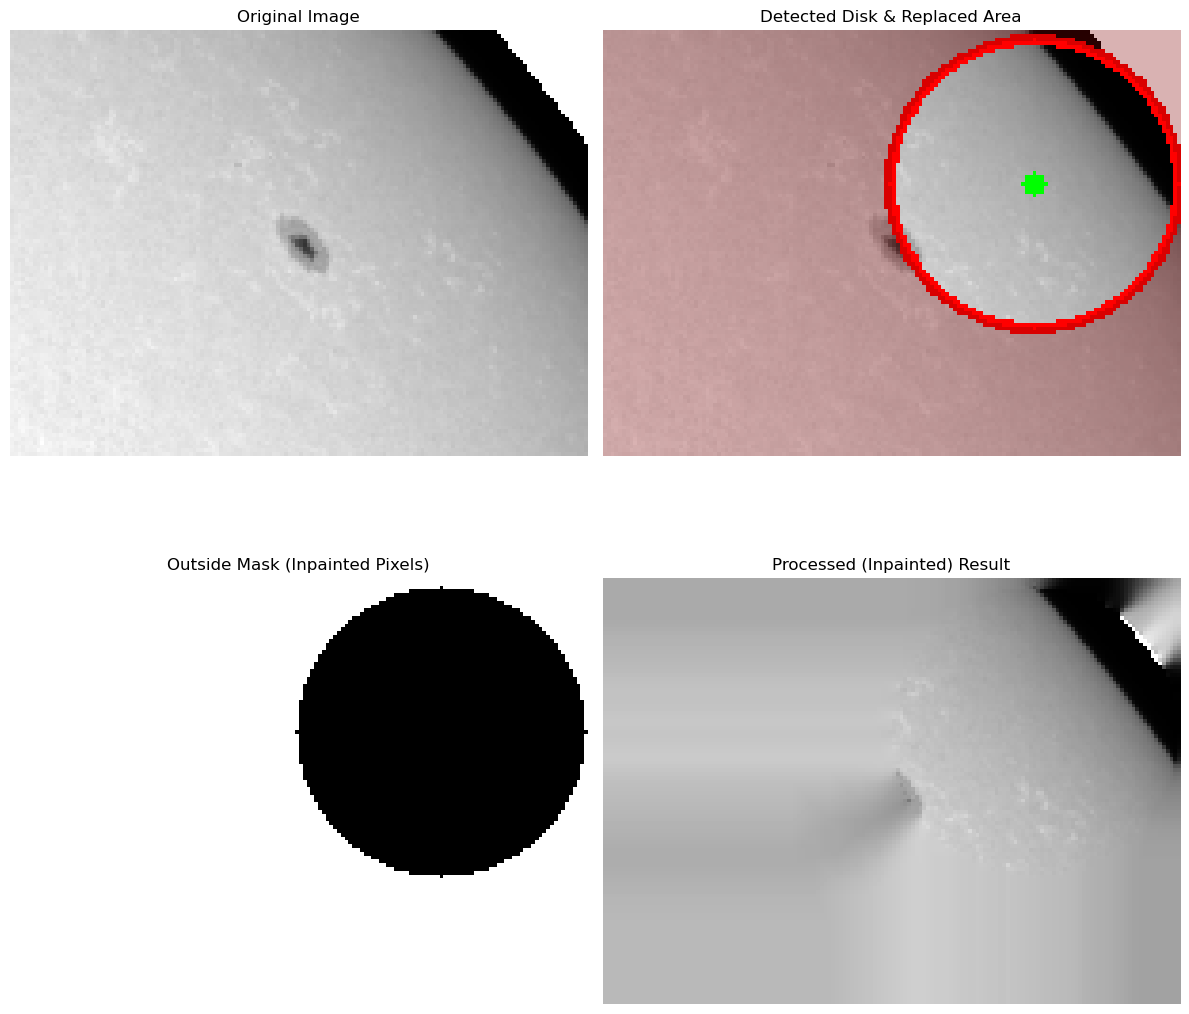

In [272]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from skimage.transform import hough_circle, hough_circle_peaks
import glob
import time # Optional: for timing performance

def process_image_universal_edge(image_path):
    """
    Process a solar image to detect the solar disk and replace pixel values
    outside the disk using OpenCV's inpainting algorithm.
    Works regardless of where the disk edge is relative to the image boundaries.

    Args:
        image_path (str): Path to the solar image.

    Returns:
        tuple: Original image, annotated image, processed image (inpainted),
               and mask indicating the inpainted area.
               Returns (None, None, None, None) if processing fails early.
               Returns (original, original, original, empty_mask) if no circle detected.
    """
    start_time = time.time() # Optional timing

    # --- Load and Prepare the Image ---
    try:
        # Load directly with OpenCV for consistency, ensure it's grayscale
        original = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
        if original is None:
             raise FileNotFoundError(f"Image file not found or couldn't be opened: {image_path}")
    except FileNotFoundError as e:
        print(f"Error: {e}")
        return None, None, None, None
    except Exception as e:
        print(f"Error loading image {image_path}: {e}")
        return None, None, None, None

    height, width = original.shape
    print(f"Processing image: {image_path} (Dimensions: {width}x{height})")

    # --- Sobel Edge Detection (Keep similar logic) ---
    sobel_x = cv2.Sobel(original, cv2.CV_64F, 1, 0, ksize=5)
    sobel_y = cv2.Sobel(original, cv2.CV_64F, 0, 1, ksize=5)
    edge_mag = np.sqrt(sobel_x**2 + sobel_y**2)
    if np.max(edge_mag) > 0:
       edge_norm = cv2.normalize(edge_mag, None, 0, 255, cv2.NORM_MINMAX)
       edge_image = np.uint8(edge_norm)
    else:
       edge_image = np.zeros_like(original, dtype=np.uint8)
    _, edge_thresh = cv2.threshold(edge_image, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(3,3))
    edge_thresh = cv2.morphologyEx(edge_thresh, cv2.MORPH_CLOSE, kernel)


    # --- Hough Circle Detection (Keep similar logic) ---
    min_radius = int(min(height, width) * 0.15)
    max_radius = int(min(height, width) * 0.55)
    step = 2
    if max_radius <= min_radius:
         max_radius = min_radius + 2*step
         print(f"Warning: Adjusted max_radius to {max_radius}")
    if min_radius < 5:
         min_radius = 5
         print(f"Warning: Clamped min_radius to {min_radius}")

    radii = None
    if max_radius > min_radius:
        radii = np.arange(min_radius, max_radius, step)

    accums, cx, cy, detected_radii = [], [], [], []
    if radii is not None and radii.size > 0:
        print(f"Attempting Hough Transform with radii from {min_radius} to {max_radius}")
        hough_res = hough_circle(edge_thresh, radii, normalize=False)
        if hough_res is not None and np.max(hough_res) > 0:
            accums, cx, cy, detected_radii = hough_circle_peaks(
                hough_res, radii,
                min_xdistance=min_radius, min_ydistance=min_radius,
                threshold=0.4 * np.max(hough_res),
                total_num_peaks=5
            )
        else:
             print("Warning: Hough transform result was empty or all zeros.")
    else:
        print("Warning: Invalid radius range for Hough Transform. Skipping circle detection.")


    # --- Initialize output images and mask ---
    annotated_image = cv2.cvtColor(original, cv2.COLOR_GRAY2BGR)
    blended_image = original.copy() # Start with original
    # Mask will identify pixels *outside* the final chosen circle (inpainting target)
    outside_mask = np.zeros((height, width), dtype=np.uint8)

    if len(accums) > 0:
        max_idx = np.argmax(accums)
        x, y, r = int(round(cx[max_idx])), int(round(cy[max_idx])), int(round(detected_radii[max_idx]))

        print(f"Detected solar disk at ({x}, {y}) with radius {r}")

        # --- Create a mask for ALL areas OUTSIDE the solar disk ---
        # This mask marks the pixels TO BE INPAINTED (non-zero).
        outside_mask = np.ones((height, width), dtype=np.uint8)
        cv2.circle(outside_mask, (x, y), r, 0, -1) # Pixels inside circle are 0 (not inpainted)

        # --- *** USE OPENCV INPAINTING INSTEAD OF RADIAL SAMPLING *** ---
        # `original`: The source image.
        # `outside_mask`: Mask indicating regions to be inpainted (non-zero values).
        # `inpaintRadius`: Neighborhood around a point considered by the algorithm.
        # `flags`: Algorithm choice (INPAINT_NS often better quality, INPAINT_TELEA faster).
        print("Attempting inpainting...")
        inpainting_radius = 5 # Adjust as needed (e.g., 3, 5, 10)
        blended_image = cv2.inpaint(original, outside_mask, inpainting_radius, flags=cv2.INPAINT_NS)
        # blended_image = cv2.inpaint(original, outside_mask, inpainting_radius, flags=cv2.INPAINT_TELEA) # Alternative
        print("Inpainting finished.")
        # --- *** END OF INPAINTING BLOCK *** ---


        # --- Visualize the results ---
        # Draw the detected circle on the *fresh* annotated image
        annotated_image = cv2.cvtColor(original, cv2.COLOR_GRAY2BGR) # Re-create from original
        cv2.circle(annotated_image, (x, y), r, (0, 0, 255), 2)  # Red circle
        cv2.circle(annotated_image, (x, y), 3, (0, 255, 0), -1) # Green center

        # Visualize the *inpainted area* (where outside_mask was 1) using an overlay
        try:
            blend_viz_color = cv2.applyColorMap(outside_mask * 255, cv2.COLORMAP_JET)
            alpha = 0.3 # Transparency
            # Ensure overlay is applied only where the mask is non-zero
            overlay_area = annotated_image[outside_mask > 0]
            color_area = blend_viz_color[outside_mask > 0]
            # Handle cases where shapes might not perfectly align due to mask generation
            min_len = min(len(overlay_area), len(color_area))
            if min_len > 0:
                 weighted_sum = cv2.addWeighted(color_area[:min_len], alpha, overlay_area[:min_len], 1 - alpha, 0)
                 annotated_image[outside_mask > 0] = weighted_sum # Assign back
            else:
                 print("Warning: No overlay area found for visualization.")

        except Exception as e:
             print(f"Warning: Error during visualization overlay: {e}")


    else:
        print(f"No suitable solar disk circle detected in {image_path}.")
        blended_image = original.copy() # Return original if no circle found
        outside_mask = np.zeros((height, width), dtype=np.uint8) # Mask is empty

    end_time = time.time() # Optional timing
    print(f"Processing took {end_time - start_time:.2f} seconds.")

    # Return the binary mask (0s inside, 1s outside/inpainted)
    return original, annotated_image, blended_image, outside_mask

# --- display_results function remains the same ---
def display_results(orig, annotated, blended, outside_mask):
    """
    Display the results from image processing.
    """
    if orig is None:
        print("Cannot display results, processing failed.")
        return

    fig, axs = plt.subplots(2, 2, figsize=(12, 12)) # Slightly smaller figure size

    # Original image
    axs[0, 0].imshow(orig, cmap="gray")
    axs[0, 0].set_title("Original Image")
    axs[0, 0].axis("off")

    # Annotated image showing circle and blend region overlay
    # Convert annotated BGR image to RGB for matplotlib
    axs[0, 1].imshow(cv2.cvtColor(annotated, cv2.COLOR_BGR2RGB))
    axs[0, 1].set_title("Detected Disk & Replaced Area")
    axs[0, 1].axis("off")

    # Outside mask (pixels that were replaced = white)
    axs[1, 0].imshow(outside_mask, cmap="gray") # Use gray cmap for binary mask
    axs[1, 0].set_title("Outside Mask (Inpainted Pixels)") # <--- Updated Title
    axs[1, 0].axis("off")

    # Blended/Processed image
    axs[1, 1].imshow(blended, cmap="gray")
    axs[1, 1].set_title("Processed (Inpainted) Result") # <--- Updated Title
    axs[1, 1].axis("off")

    plt.tight_layout()
    plt.show()


# --- Example usage remains the same ---
if __name__ == "__main__":
    # --- IMPORTANT: Update this path to your image directory ---
    image_folder_path = "../Solar_disk_hough_transformation/sample_images/" # MODIFY AS NEEDED
    image_pattern = "20110110_065810_AR11140 copy.png" # MODIFY AS NEEDED
    # image_pattern = "*.png" # Or "*.jpg", "*.tif", etc.

    image_files = glob.glob(f"{image_folder_path}{image_pattern}")

    if not image_files:
        print(f"No images found matching pattern '{image_pattern}' in folder '{image_folder_path}'")
        print("Please check the path and pattern.")
    else:
        print(f"Found {len(image_files)} image(s). Processing...")

    # Process each image found
    for image_path in image_files:
        orig, annotated, blended, mask = process_image_universal_edge(image_path)

        if orig is not None:
            display_results(orig, annotated, blended, mask)
        else:
            print(f"Skipping display for failed image: {image_path}")

Found 1 image(s). Processing...
Processing image: ../Solar_disk_hough_transformation/sample_images/20110110_065810_AR11140 copy.png (Dimensions: 152x112)
Detected solar disk at (113, 40) with radius 38
Attempting selective inpainting...
Inpainting finished.
Processing took 0.02 seconds.


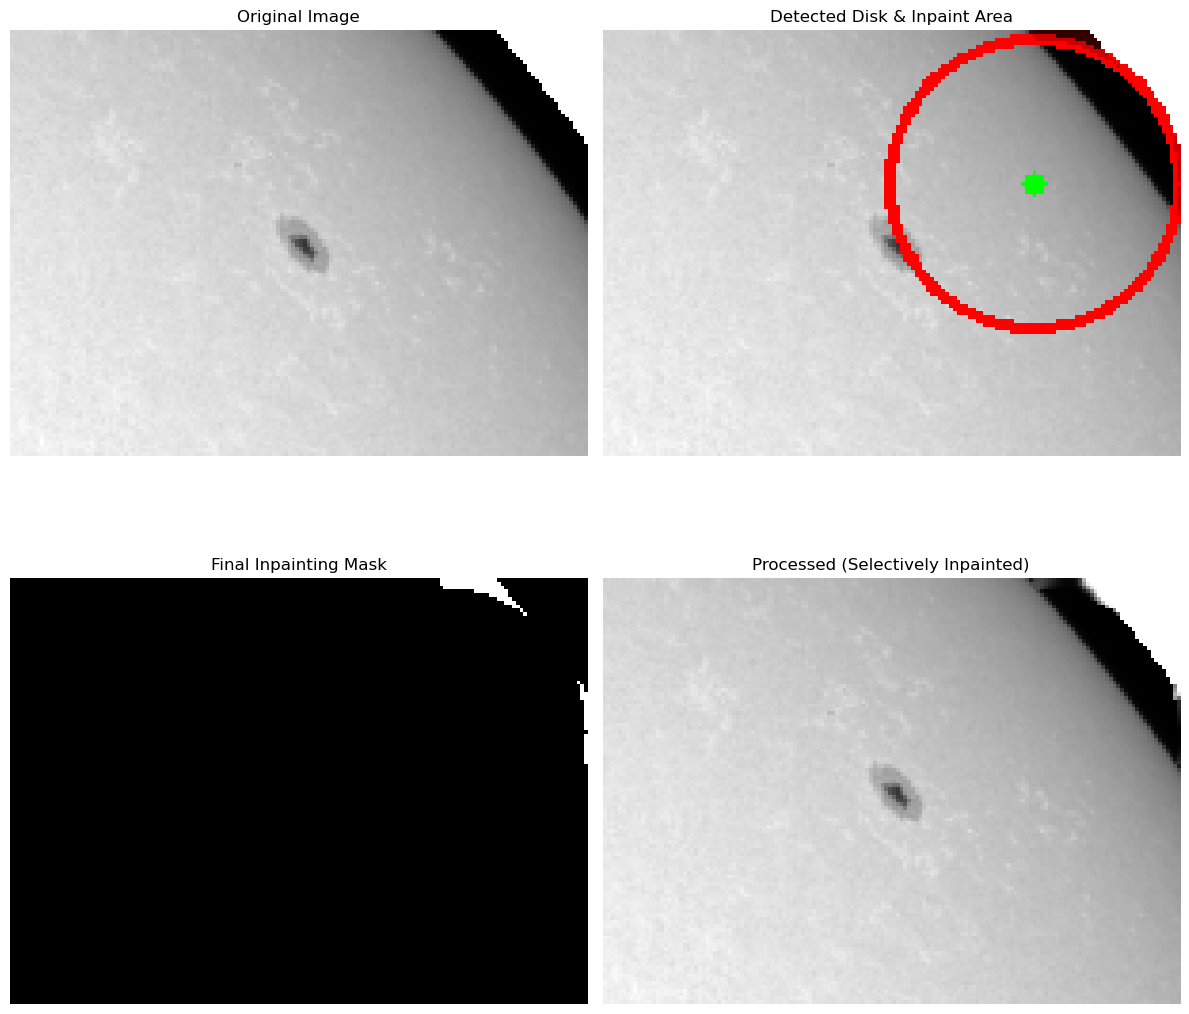

In [276]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from skimage.transform import hough_circle, hough_circle_peaks
import glob
import time

# --- Threshold for identifying dark background pixels ---
# Adjust this value based on your images. It should be low enough
# to capture the black background but high enough to exclude faint disk features.
# Values between 10 and 40 are often reasonable.
DARK_BACKGROUND_THRESHOLD = 25 # <--- ADJUSTABLE PARAMETER

def process_image_selective_edge(image_path, dark_threshold=DARK_BACKGROUND_THRESHOLD):
    """
    Process solar image, detect disk, and inpaint ONLY the dark areas
    outside the detected disk (typically cutoff regions near corners/edges).

    Args:
        image_path (str): Path to the solar image.
        dark_threshold (int): Pixel intensity below which is considered dark background.

    Returns:
        tuple: Original, annotated, inpainted image, and the final inpainting mask.
               Returns (None, None, None, None) on failure.
    """
    start_time = time.time()

    # --- Load and Prepare Image ---
    try:
        original = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
        if original is None:
             raise FileNotFoundError(f"Image file not found or couldn't be opened: {image_path}")
    except FileNotFoundError as e:
        print(f"Error: {e}")
        return None, None, None, None
    except Exception as e:
        print(f"Error loading image {image_path}: {e}")
        return None, None, None, None

    height, width = original.shape
    print(f"Processing image: {image_path} (Dimensions: {width}x{height})")

    # --- Edge Detection & Hough Transform (Same as before) ---
    sobel_x = cv2.Sobel(original, cv2.CV_64F, 1, 0, ksize=5)
    sobel_y = cv2.Sobel(original, cv2.CV_64F, 0, 1, ksize=5)
    edge_mag = np.sqrt(sobel_x**2 + sobel_y**2)
    if np.max(edge_mag) > 0:
       edge_norm = cv2.normalize(edge_mag, None, 0, 255, cv2.NORM_MINMAX)
       edge_image = np.uint8(edge_norm)
    else:
       edge_image = np.zeros_like(original, dtype=np.uint8)
    _, edge_thresh = cv2.threshold(edge_image, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(3,3))
    edge_thresh = cv2.morphologyEx(edge_thresh, cv2.MORPH_CLOSE, kernel)

    min_radius = int(min(height, width) * 0.15)
    max_radius = int(min(height, width) * 0.55)
    step = 2
    if max_radius <= min_radius: max_radius = min_radius + 2*step
    if min_radius < 5: min_radius = 5

    radii = None
    if max_radius > min_radius:
        radii = np.arange(min_radius, max_radius, step)

    accums, cx, cy, detected_radii = [], [], [], []
    if radii is not None and radii.size > 0:
        hough_res = hough_circle(edge_thresh, radii, normalize=False)
        if hough_res is not None and np.max(hough_res) > 0:
            accums, cx, cy, detected_radii = hough_circle_peaks(
                hough_res, radii, min_xdistance=min_radius, min_ydistance=min_radius,
                threshold=0.4 * np.max(hough_res), total_num_peaks=5 )
        else: print("Warning: Hough transform result empty/zero.")
    else: print("Warning: Invalid radius range.")

    # --- Initialize outputs ---
    annotated_image = cv2.cvtColor(original, cv2.COLOR_GRAY2BGR)
    processed_image = original.copy()
    inpainting_mask = np.zeros((height, width), dtype=np.uint8) # Final mask for inpaint

    if len(accums) > 0:
        max_idx = np.argmax(accums)
        x, y, r = int(round(cx[max_idx])), int(round(cy[max_idx])), int(round(detected_radii[max_idx]))
        print(f"Detected solar disk at ({x}, {y}) with radius {r}")

        # --- Create Mask 1: Pixels OUTSIDE the detected circle ---
        outside_circle_mask = np.ones((height, width), dtype=np.uint8)
        cv2.circle(outside_circle_mask, (x, y), r, 0, -1) # 1 = outside, 0 = inside

        # --- Create Mask 2: Pixels that are DARK in the original image ---
        # Pixels below the threshold are considered potential background/cutoff areas.
        # Resulting mask has 1 for dark pixels, 0 for bright pixels.
        dark_area_mask = (original < dark_threshold).astype(np.uint8)

        # --- Create Final Mask: Combine Mask 1 AND Mask 2 ---
        # The final mask marks pixels that are BOTH outside the circle AND dark.
        inpainting_mask = cv2.bitwise_and(outside_circle_mask, dark_area_mask)

        # --- Perform Inpainting using the REFINED mask ---
        if np.any(inpainting_mask): # Check if there's anything to inpaint
            print("Attempting selective inpainting...")
            inpainting_radius = 5 # Adjust as needed
            processed_image = cv2.inpaint(original, inpainting_mask, inpainting_radius, flags=cv2.INPAINT_NS)
            print("Inpainting finished.")
        else:
            print("No areas met criteria for selective inpainting.")
            processed_image = original.copy() # No changes needed

        # --- Visualization ---
        annotated_image = cv2.cvtColor(original, cv2.COLOR_GRAY2BGR) # Re-create
        cv2.circle(annotated_image, (x, y), r, (0, 0, 255), 2)  # Red circle
        cv2.circle(annotated_image, (x, y), 3, (0, 255, 0), -1) # Green center

        # Visualize the *selectively inpainted area* (where inpainting_mask was 1)
        try:
            # Use the final inpainting_mask for the overlay
            blend_viz_color = cv2.applyColorMap(inpainting_mask * 255, cv2.COLORMAP_JET)
            alpha = 0.4
            overlay_area = annotated_image[inpainting_mask > 0]
            color_area = blend_viz_color[inpainting_mask > 0]
            min_len = min(len(overlay_area), len(color_area))
            if min_len > 0:
                 weighted_sum = cv2.addWeighted(color_area[:min_len], alpha, overlay_area[:min_len], 1 - alpha, 0)
                 annotated_image[inpainting_mask > 0] = weighted_sum
            # No "else" needed here, if no overlay, nothing happens.
        except Exception as e:
             print(f"Warning: Error during visualization overlay: {e}")

    else:
        print(f"No suitable solar disk circle detected in {image_path}.")
        processed_image = original.copy()
        inpainting_mask = np.zeros((height, width), dtype=np.uint8)

    end_time = time.time()
    print(f"Processing took {end_time - start_time:.2f} seconds.")

    return original, annotated_image, processed_image, inpainting_mask

# --- Update display_results function to reflect the new mask meaning ---
def display_results(orig, annotated, processed, inpainting_mask):
    """
    Display the results from image processing.
    """
    if orig is None:
        print("Cannot display results, processing failed.")
        return

    fig, axs = plt.subplots(2, 2, figsize=(12, 12))

    axs[0, 0].imshow(orig, cmap="gray")
    axs[0, 0].set_title("Original Image")
    axs[0, 0].axis("off")

    axs[0, 1].imshow(cv2.cvtColor(annotated, cv2.COLOR_BGR2RGB))
    axs[0, 1].set_title("Detected Disk & Inpaint Area") # <--- Updated Title
    axs[0, 1].axis("off")

    axs[1, 0].imshow(inpainting_mask, cmap="gray")
    axs[1, 0].set_title("Final Inpainting Mask") # <--- Updated Title
    axs[1, 0].axis("off")

    axs[1, 1].imshow(processed, cmap="gray")
    axs[1, 1].set_title("Processed (Selectively Inpainted)") # <--- Updated Title
    axs[1, 1].axis("off")

    plt.tight_layout()
    plt.show()

# --- Example Usage (Update function call) ---
if __name__ == "__main__":
    image_folder_path = "../Solar_disk_hough_transformation/sample_images/" # MODIFY AS NEEDED
    image_pattern = "20110110_065810_AR11140 copy.png" # MODIFY AS NEEDED

    image_files = glob.glob(f"{image_folder_path}{image_pattern}")

    if not image_files:
        print(f"No images found matching pattern '{image_pattern}' in folder '{image_folder_path}'")
    else:
        print(f"Found {len(image_files)} image(s). Processing...")

    for image_path in image_files:
        # Call the new selective function
        orig, annotated, processed, mask = process_image_selective_edge(
            image_path,
            dark_threshold=DARK_BACKGROUND_THRESHOLD # Pass the threshold
        )

        if orig is not None:
            display_results(orig, annotated, processed, mask)
        else:
            print(f"Skipping display for failed image: {image_path}")

Found 1 image(s). Processing...
Processing image: ../Solar_disk_hough_transformation/sample_images/20110110_065810_AR11140 copy.png (Dimensions: 152x112)
Using radii from 16 to 61
Detected solar disk at (112, 38) with radius 38
Found 76 pixels to blend.
Performing selective pixel sampling...
Selective sampling finished.
Processing took 0.03 seconds.


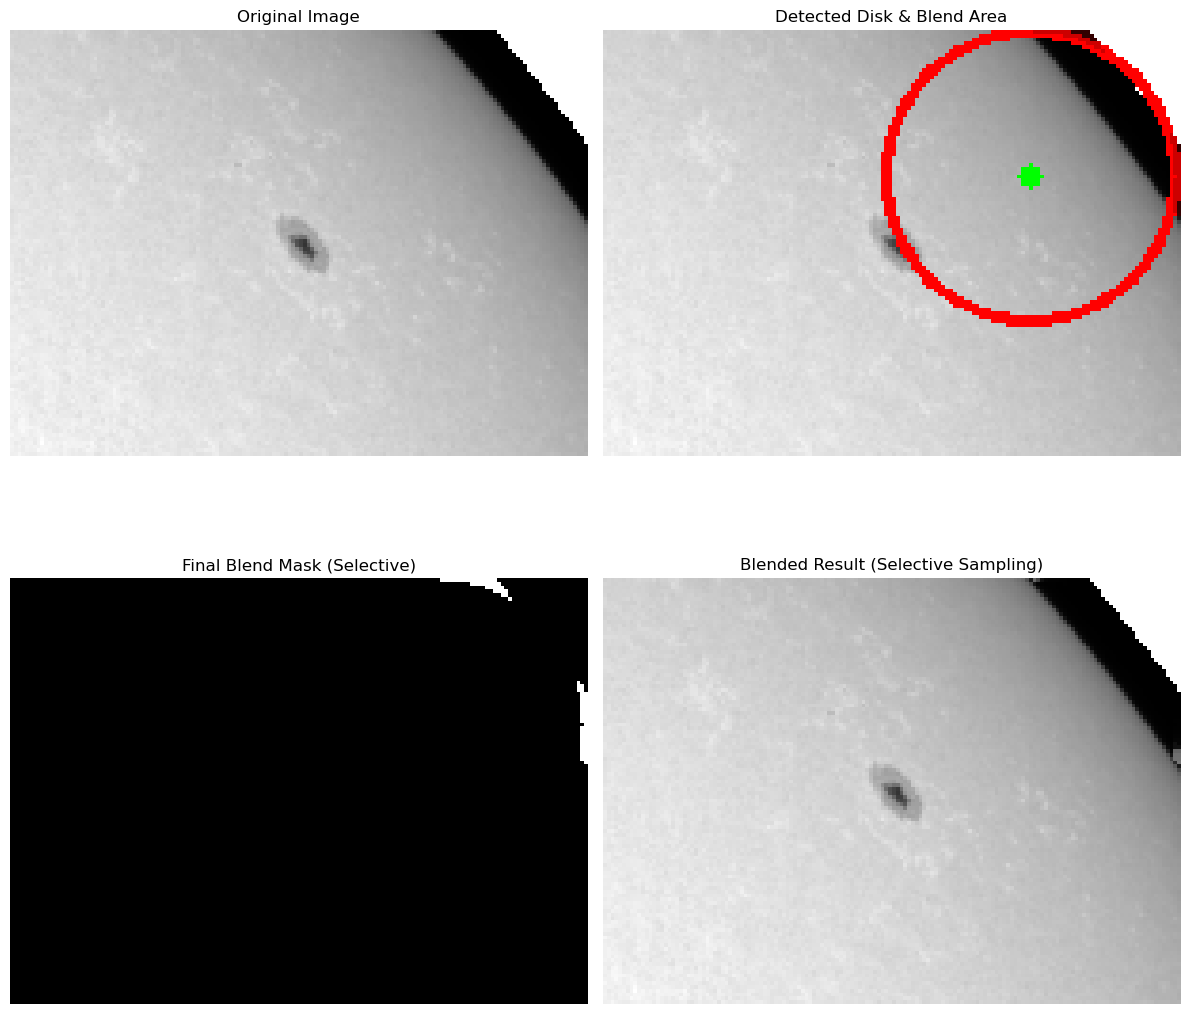

In [280]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from skimage.transform import hough_circle, hough_circle_peaks
import glob
import time # Optional for timing

# --- Threshold for identifying dark background pixels ---
# Adjust this value based on your images. It should be low enough
# to capture the black background but high enough to exclude faint disk features.
DARK_BACKGROUND_THRESHOLD = 25 # <--- ADJUSTABLE PARAMETER

# Rename function slightly for clarity
def process_image_selective_sampling(image_path, dark_threshold=DARK_BACKGROUND_THRESHOLD):
    """
    Process a solar image to detect the solar disk and replace pixel values
    in the DARK areas OUTSIDE the disk (near corners/edges) with values
    sampled radially from inside the disk.

    Args:
        image_path (str): Path to the solar image.
        dark_threshold (int): Pixel intensity below which is considered dark background.

    Returns:
        tuple: Original image, annotated image, processed image, and the final blend mask.
               Returns (None, None, None, None) on failure.
    """
    start_time = time.time()
    # --- Load and Prepare the Image ---
    try:
        # Use PIL as in the original code snippet
        solar_image = Image.open(image_path).convert("L")
        original = np.array(solar_image, dtype=np.uint8)
    except FileNotFoundError:
        print(f"Error: Image file not found at {image_path}")
        return None, None, None, None
    except Exception as e:
        print(f"Error loading image {image_path}: {e}")
        return None, None, None, None

    height, width = original.shape
    print(f"Processing image: {image_path} (Dimensions: {width}x{height})")

    # --- Sobel Edge Detection (from original code) ---
    sobel_x = cv2.Sobel(original, cv2.CV_64F, 1, 0, ksize=3)
    sobel_y = cv2.Sobel(original, cv2.CV_64F, 0, 1, ksize=3)
    abs_sobel_x = cv2.convertScaleAbs(sobel_x)
    abs_sobel_y = cv2.convertScaleAbs(sobel_y)
    edge_image = cv2.addWeighted(abs_sobel_x, 0.5, abs_sobel_y, 0.5, 0)
    # Consider using Otsu's threshold for potentially better edge detection robustness
    # _, edge_thresh = cv2.threshold(edge_image, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    # Using the fixed threshold from original code:
    _, edge_thresh = cv2.threshold(edge_image, 50, 255, cv2.THRESH_BINARY)

    # --- Hough Circle Detection (adapt radius range if needed) ---
    # Make radius range slightly more dynamic, but keep original if preferred
    min_radius = int(min(height, width) * 0.15) # Example dynamic
    max_radius = int(min(height, width) * 0.55) # Example dynamic
    # radii = np.arange(50, 150, 2) # Original fixed range
    step = 2
    if max_radius <= min_radius: max_radius = min_radius + 2*step
    if min_radius < 5: min_radius = 5

    radii = None
    if max_radius > min_radius:
        radii = np.arange(min_radius, max_radius, step)
        print(f"Using radii from {min_radius} to {max_radius}")
    else:
        print("Warning: Invalid radius range derived.")
        radii = np.arange(50, 150, 2) # Fallback to original fixed range
        print("Falling back to fixed radii: 50-150")


    accums, cx, cy, detected_radii = [], [], [], []
    if radii is not None and radii.size > 0 and np.any(edge_thresh): # Check if edge image isn't blank
       try:
            hough_res = hough_circle(edge_thresh, radii, normalize=False)
            if hough_res is not None and np.max(hough_res) > 0:
                accums, cx, cy, detected_radii = hough_circle_peaks(
                    hough_res, radii,
                    min_xdistance=50, min_ydistance=50, # Keep original constraints
                    threshold=0.5 * np.max(hough_res), # Keep original threshold logic
                    total_num_peaks=3 # Keep original peak count
                )
            else:
                print("Warning: Hough transform result empty/zero.")
       except Exception as e:
            print(f"Error during Hough transform: {e}") # Catch potential errors
    else:
       print("Skipping Hough transform due to invalid radii or blank edge image.")


    # --- Create annotated image & outputs ---
    annotated_image = cv2.cvtColor(original, cv2.COLOR_GRAY2BGR)
    blended_image = original.copy()
    # This will be the final mask used for blending AND visualization
    final_blend_mask = np.zeros((height, width), dtype=np.uint8)

    if len(accums) > 0:
        # Get the circle with highest votes
        max_idx = np.argmax(accums)
        # Ensure coordinates are integer for drawing/masking
        x, y, r = int(round(cx[max_idx])), int(round(cy[max_idx])), int(round(detected_radii[max_idx]))

        print(f"Detected solar disk at ({x}, {y}) with radius {r}")

        # Draw the circle on the annotated image
        cv2.circle(annotated_image, (x, y), r, (0, 0, 255), 2)
        cv2.circle(annotated_image, (x, y), 3, (0, 255, 0), -1)

        # --- *** CREATE THE SELECTIVE MASK *** ---
        # 1. Mask for pixels OUTSIDE the circle
        outside_circle_mask = np.ones((height, width), dtype=np.uint8)
        cv2.circle(outside_circle_mask, (x, y), r, 0, -1) # 1 = outside

        # 2. Mask for pixels that are DARK in the original image
        dark_area_mask = (original < dark_threshold).astype(np.uint8) # 1 = dark

        # 3. Final mask: Combine using AND (pixels must be BOTH outside AND dark)
        final_blend_mask = cv2.bitwise_and(outside_circle_mask, dark_area_mask)
        # --- *** MASK CREATION END *** ---


        # --- Replace pixels using the SELECTIVE mask and original sampling logic ---
        print(f"Found {np.sum(final_blend_mask)} pixels to blend.")
        # Iterate only through pixels marked in the final_blend_mask for efficiency
        # Get coordinates where mask is 1
        pixels_to_blend_coords = np.argwhere(final_blend_mask > 0)

        if pixels_to_blend_coords.shape[0] > 0:
             print("Performing selective pixel sampling...")
             for coords in pixels_to_blend_coords:
                 i, j = coords[0], coords[1] # Get row (y) and col (x)

                 # --- Original Sampling Logic ---
                 vec_x = j - x
                 vec_y = i - y
                 dist = np.sqrt(vec_x**2 + vec_y**2)

                 if dist > 0: # Should always be true for pixels outside circle
                     # Normalize vector
                     norm_vec_x = vec_x / dist
                     norm_vec_y = vec_y / dist

                     # Calculate sample point just inside the radius
                     inside_r = r - 3 # Sample 3 pixels inside boundary
                     if inside_r < 0: inside_r = 0 # Prevent negative radius

                     sample_x = int(round(x + norm_vec_x * inside_r)) # Use round for potentially better accuracy
                     sample_y = int(round(y + norm_vec_y * inside_r))

                     # Clamp coordinates to be within image bounds
                     sample_x = max(0, min(width - 1, sample_x))
                     sample_y = max(0, min(height - 1, sample_y))

                     # Assign sampled value
                     blended_image[i, j] = original[sample_y, sample_x]
                 # --- End of Original Sampling Logic ---
             print("Selective sampling finished.")
        else:
             print("No pixels met the criteria for blending.")


        # --- Visualize the selectively blended area in the annotated image ---
        # Use the final_blend_mask for visualization
        if np.any(final_blend_mask):
             try:
                 blend_viz_color = cv2.applyColorMap(final_blend_mask * 255, cv2.COLORMAP_JET)
                 alpha = 0.4
                 # Apply overlay only where the mask is active
                 overlay_area = annotated_image[final_blend_mask > 0]
                 color_area = blend_viz_color[final_blend_mask > 0]
                 min_len = min(len(overlay_area), len(color_area))
                 if min_len > 0:
                     weighted_sum = cv2.addWeighted(color_area[:min_len], alpha, overlay_area[:min_len], 1 - alpha, 0)
                     annotated_image[final_blend_mask > 0] = weighted_sum
             except Exception as e:
                 print(f"Warning: Error during visualization overlay: {e}")

    else:
        print("No suitable solar disk circle detected.")
        # Keep original image if no circle found
        blended_image = original.copy()
        final_blend_mask = np.zeros((height, width), dtype=np.uint8)

    end_time = time.time()
    print(f"Processing took {end_time - start_time:.2f} seconds.")

    # Return the final mask used for blending
    return original, annotated_image, blended_image, final_blend_mask


# --- Updated display_results function ---
def display_results(orig, annotated, blended, blend_mask):
    """
    Display the results from image processing.
    """
    if orig is None:
         print("Cannot display results, processing failed.")
         return

    fig, axs = plt.subplots(2, 2, figsize=(12, 12)) # Adjusted size

    axs[0, 0].imshow(orig, cmap="gray")
    axs[0, 0].set_title("Original Image")
    axs[0, 0].axis("off")

    axs[0, 1].imshow(cv2.cvtColor(annotated, cv2.COLOR_BGR2RGB))
    axs[0, 1].set_title("Detected Disk & Blend Area") # Show area targeted
    axs[0, 1].axis("off")

    # Display the final mask used for blending
    axs[1, 0].imshow(blend_mask, cmap="gray") # Use gray for binary mask
    axs[1, 0].set_title("Final Blend Mask (Selective)") # Updated title
    axs[1, 0].axis("off")

    axs[1, 1].imshow(blended, cmap="gray")
    axs[1, 1].set_title("Blended Result (Selective Sampling)") # Updated title
    axs[1, 1].axis("off")

    plt.tight_layout()
    plt.show()

# --- Example usage (Update function call) ---
if __name__ == "__main__":
    # --- IMPORTANT: Update paths ---
    image_folder_path = "../Solar_disk_hough_transformation/sample_images/" # MODIFY AS NEEDED
    # Make sure this file exists at the path
    image_pattern = "20110110_065810_AR11140 copy.png" # MODIFY AS NEEDED

    image_files = glob.glob(f"{image_folder_path}{image_pattern}")

    if not image_files:
        print(f"No images found matching pattern '{image_pattern}' in folder '{image_folder_path}'")
        print("Please check the path and pattern.")
    else:
        print(f"Found {len(image_files)} image(s). Processing...")

    for image_path in image_files:
        # Call the updated function
        orig, annotated, blended, mask = process_image_selective_sampling(
            image_path,
            dark_threshold=DARK_BACKGROUND_THRESHOLD # Pass the threshold
        )

        # Display the results if processing was successful
        if orig is not None:
            display_results(orig, annotated, blended, mask)
        else:
            print(f"Skipping display for failed image: {image_path}")

Found 1 image(s) to process.

--- Processing: ../Solar_disk_hough_transformation/sample_images/20110110_065810_AR11140 copy.png ---
Detected solar disk at (74.00, 55.00) with radius 54.00
Proximity Check - Top: True (dist=55.0, r=54.0)
Proximity Check - Bottom: True (dist=57.0, r=54.0)
Proximity Check - Left: False (dist=74.0, r=54.0)
Proximity Check - Right: False (dist=78.0, r=54.0)
Blending 7836 pixels...


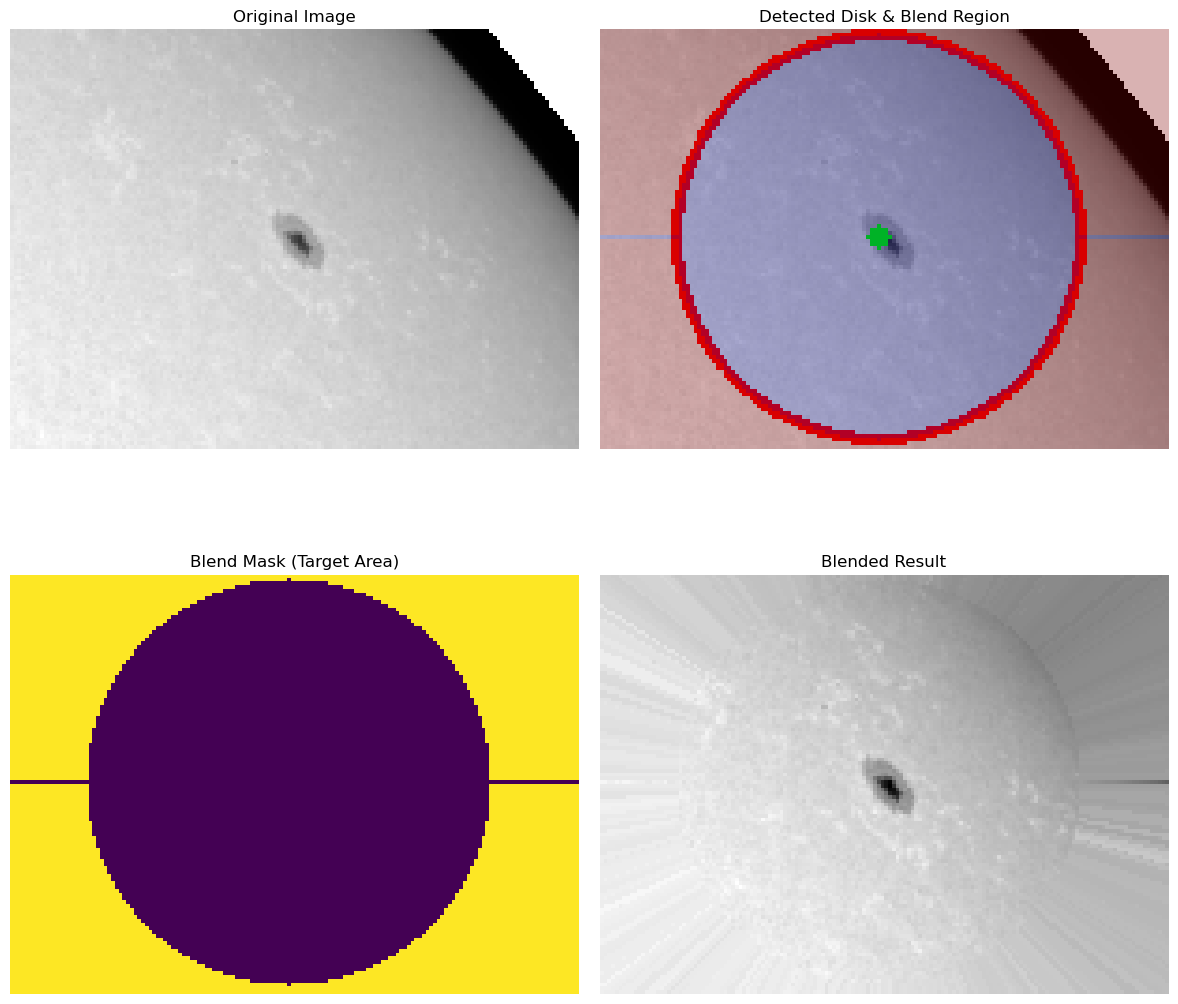

In [284]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from skimage.transform import hough_circle, hough_circle_peaks
import glob
import math # Import math for sqrt

# This value is no longer directly used for blending width,
# but might be relevant for other parts or context.
# edge_width_value = 100

def process_image_with_dynamic_blending(image_path, radius_margin=10):
    """
    Process a solar image to detect the solar disk and replace pixel values
    outside the disk *only in the region closest to the image boundary*
    with values sampled from inside the disk.

    Args:
        image_path (str): Path to the solar image.
        radius_margin (int): How close the circle center needs to be to an edge
                             (relative to radius) to trigger blending in that direction.
                             A positive value means blending starts even if the
                             circle doesn't strictly overlap the edge.

    Returns:
        tuple: Original image, annotated image, processed image, and mask.
              Returns (None, None, None, None) if no circle is detected.
    """
    # --- Load and Prepare the Image ---
    try:
        solar_image = Image.open(image_path).convert("L")
    except FileNotFoundError:
        print(f"Error: Image file not found at {image_path}")
        return None, None, None, None
    original = np.array(solar_image, dtype=np.uint8)
    height, width = original.shape

    # --- Sobel Edge Detection for circle finding ---
    # Increased ksize slightly for potentially better edge detection on some images
    sobel_x = cv2.Sobel(original, cv2.CV_64F, 1, 0, ksize=5)
    sobel_y = cv2.Sobel(original, cv2.CV_64F, 0, 1, ksize=5)

    abs_sobel_x = cv2.convertScaleAbs(sobel_x)
    abs_sobel_y = cv2.convertScaleAbs(sobel_y)

    edge_image = cv2.addWeighted(abs_sobel_x, 0.5, abs_sobel_y, 0.5, 0)
    # Adjust threshold if needed based on image characteristics
    _, edge_thresh = cv2.threshold(edge_image, 50, 255, cv2.THRESH_BINARY)

    # --- Hough Circle Detection to find the solar disk ---
    # Make radius range slightly more dynamic, adjust step for performance/accuracy
    min_r = int(min(height, width) * 0.15) # E.g., 15% of min dimension
    max_r = int(min(height, width) * 0.55) # E.g., 55% of min dimension
    radii = np.arange(min_r, max_r, 2)

    if len(radii) == 0:
        print(f"Warning: Calculated radii range is empty ({min_r} to {max_r}). Check image dimensions or range calculation.")
        return original, cv2.cvtColor(original, cv2.COLOR_GRAY2BGR), original.copy(), np.zeros((height, width), dtype=np.float32)


    # Consider normalize=True if edge signal is weak/noisy
    hough_res = hough_circle(edge_thresh, radii, normalize=False)

    # Check if hough_res is not empty or all zeros before finding peaks
    if hough_res is None or np.max(hough_res) == 0:
         print("Hough transform did not yield any results (accumulator array is empty or all zero).")
         # Return originals and empty mask
         annotated_image = cv2.cvtColor(original, cv2.COLOR_GRAY2BGR)
         return original, annotated_image, original.copy(), np.zeros((height, width), dtype=np.float32)


    accums, cx, cy, detected_radii = hough_circle_peaks(
        hough_res, radii,
        min_xdistance=int(width * 0.1), min_ydistance=int(height * 0.1), # Dynamic spacing
        threshold=0.4 * np.max(hough_res), # Relative threshold
        total_num_peaks=1 # We typically want the most prominent solar disk
    )

    # --- Initialize Outputs ---
    annotated_image = cv2.cvtColor(original, cv2.COLOR_GRAY2BGR)
    blended_image = original.copy()
    # Use uint8 for mask internally, convert to float32 on return if needed
    blend_mask = np.zeros((height, width), dtype=np.uint8)

    if len(accums) > 0:
        # Get the best detected circle (highest accumulator value)
        # Note: hough_circle_peaks already sorts by accumulator, so index 0 is often the best
        x, y, r = cx[0], cy[0], detected_radii[0]

        # Ensure radius is positive
        r = max(1, r) # Avoid zero or negative radius

        print(f"Detected solar disk at ({x:.2f}, {y:.2f}) with radius {r:.2f}")

        # Draw the detected circle on the annotated image
        cv2.circle(annotated_image, (int(x), int(y)), int(r), (0, 0, 255), 2) # Blue circle edge
        cv2.circle(annotated_image, (int(x), int(y)), 3, (0, 255, 0), -1)    # Green center

        # --- Determine which edges the circle boundary is close to ---
        # Calculate distances from center to edges
        dist_top = y
        dist_bottom = height - y
        dist_left = x
        dist_right = width - x

        # Check if the circle *boundary* is close to or beyond the image edge
        is_close_top = dist_top < r + radius_margin
        is_close_bottom = dist_bottom < r + radius_margin
        is_close_left = dist_left < r + radius_margin
        is_close_right = dist_right < r + radius_margin

        print(f"Proximity Check - Top: {is_close_top} (dist={dist_top:.1f}, r={r:.1f})")
        print(f"Proximity Check - Bottom: {is_close_bottom} (dist={dist_bottom:.1f}, r={r:.1f})")
        print(f"Proximity Check - Left: {is_close_left} (dist={dist_left:.1f}, r={r:.1f})")
        print(f"Proximity Check - Right: {is_close_right} (dist={dist_right:.1f}, r={r:.1f})")


        # --- Create the blend mask targeting specific regions ---
        # Efficiently calculate squared distance for all pixels
        Y_coords, X_coords = np.ogrid[:height, :width]
        dist_from_center_sq = (X_coords - x)**2 + (Y_coords - y)**2

        # Mask for pixels strictly outside the detected circle radius
        outside_circle_mask = dist_from_center_sq > r**2

        # Combine conditions: must be outside circle AND in a 'close' region direction
        if is_close_top:
            blend_mask[ (Y_coords < y) & outside_circle_mask ] = 1
        if is_close_bottom:
            # Use >= y to include the center row if needed, or > y to be strictly below
            blend_mask[ (Y_coords > y) & outside_circle_mask ] = 1
        if is_close_left:
            blend_mask[ (X_coords < x) & outside_circle_mask ] = 1
        if is_close_right:
            # Use >= x or > x similarly
            blend_mask[ (X_coords > x) & outside_circle_mask ] = 1

        # --- Replace pixels within the blend_mask region ---
        # Get the coordinates (row, col) where the mask is active
        indices_to_blend = np.argwhere(blend_mask > 0)

        # Define how far inside the radius to sample from (e.g., 3-5 pixels)
        sampling_offset = 3
        inside_r = max(1, r - sampling_offset) # Ensure sample radius is positive

        if len(indices_to_blend) > 0:
            print(f"Blending {len(indices_to_blend)} pixels...")
            for i, j in indices_to_blend:
                # Calculate vector from center (x, y) to the pixel (j, i)
                vec_x = j - x
                vec_y = i - y
                dist = math.sqrt(vec_x**2 + vec_y**2) # Calculate magnitude

                if dist > 0: # Avoid division by zero for safety
                    # Normalize the direction vector
                    norm_vec_x = vec_x / dist
                    norm_vec_y = vec_y / dist

                    # Calculate the corresponding sample point coordinates inside the disk
                    sample_x = int(x + norm_vec_x * inside_r)
                    sample_y = int(y + norm_vec_y * inside_r)

                    # Clamp coordinates to ensure they are within image bounds
                    sample_x = max(0, min(width - 1, sample_x))
                    sample_y = max(0, min(height - 1, sample_y))

                    # Replace the pixel value in the blended image
                    blended_image[i, j] = original[sample_y, sample_x]
        else:
             print("No pixels identified for blending (circle might be fully contained or detection failed).")


        # --- Visualize the specific replaced area in the annotated image ---
        if np.any(blend_mask): # Check if the mask has any active pixels
            # Use a distinct colormap for visualization overlay
            blend_viz_color = cv2.applyColorMap(blend_mask * 255, cv2.COLORMAP_JET)
            alpha = 0.3 # Transparency of the overlay
            cv2.addWeighted(blend_viz_color, alpha, annotated_image, 1 - alpha, 0, annotated_image)

    else:
        print("No suitable circle detected after Hough peaks analysis.")
        # Return originals and empty mask if no peaks found
        return original, annotated_image, blended_image, blend_mask.astype(np.float32)

    # Return results, converting mask to float32 if needed by downstream processes
    return original, annotated_image, blended_image, blend_mask.astype(np.float32)


def display_results(orig, annotated, blended, blend_mask):
    """
    Display the results from image processing. Handles cases where inputs might be None.
    """
    if orig is None:
        print("Cannot display results because input images are None.")
        return

    fig, axs = plt.subplots(2, 2, figsize=(12, 12)) # Slightly smaller figure

    # Original image
    axs[0, 0].imshow(orig, cmap="gray")
    axs[0, 0].set_title("Original Image")
    axs[0, 0].axis("off")

    # Annotated image showing circle and blend region overlay
    axs[0, 1].imshow(cv2.cvtColor(annotated, cv2.COLOR_BGR2RGB))
    axs[0, 1].set_title("Detected Disk & Blend Region")
    axs[0, 1].axis("off")

    # Blend mask (showing the area targeted for blending)
    # Use 'viridis' or 'gray' for better perception of mask area
    axs[1, 0].imshow(blend_mask, cmap="viridis", vmin=0, vmax=1)
    axs[1, 0].set_title("Blend Mask (Target Area)")
    axs[1, 0].axis("off")

    # Blended image (final result)
    axs[1, 1].imshow(blended, cmap="gray")
    axs[1, 1].set_title("Blended Result")
    axs[1, 1].axis("off")

    plt.tight_layout(pad=1.5) # Add padding
    plt.show()


# --- Example Usage ---
if __name__ == "__main__":
    # IMPORTANT: Adjust this path to where your images are located
    # Use a wildcard (*) to process multiple images or specify a single file
    # Ensure the path is correct relative to where you run the script
    image_folder_path = "../Solar_disk_hough_transformation/sample_images/"
    # image_pattern = "*.png" # Example: process all png files
    image_pattern = "20110110_065810_AR11140 copy.png" # Process a specific file

    image_files = glob.glob(image_folder_path + image_pattern)

    if not image_files:
         print(f"Error: No image files found matching pattern '{image_pattern}' in folder '{image_folder_path}'.")
         print("Please check the path and pattern.")
    else:
        print(f"Found {len(image_files)} image(s) to process.")
        # Process each image found
        for image_path in image_files:
            print(f"\n--- Processing: {image_path} ---")
            # Use the updated function name and pass the radius_margin
            orig, annotated, blended, blend_mask = process_image_with_dynamic_blending(
                image_path,
                radius_margin=15 # Adjust this margin as needed (pixels)
            )

            # Display the results for the current image
            display_results(orig, annotated, blended, blend_mask)

Found 1 image(s) to process.

--- Processing: ../Solar_disk_hough_transformation/sample_images/20110110_065810_AR11140 copy.png ---
Detected solar disk at (93.00, 55.00) with radius 54.00
Circle is close to an edge. Determining closest corner for blending.
Closest corner identified: top-right (Min distance to circumference: 25.93)
Blending 1007 pixels in the top-right quadrant...


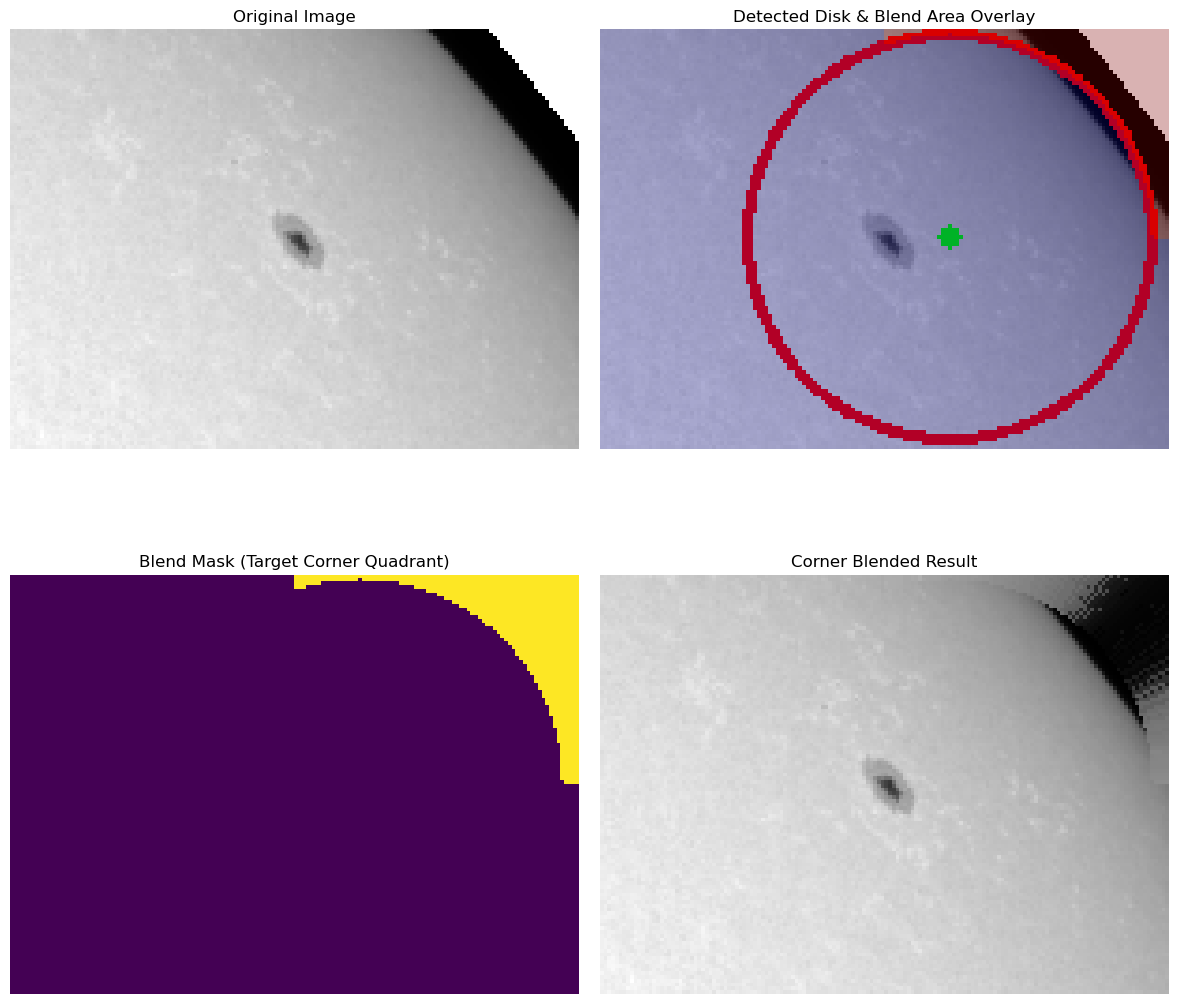

In [288]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from skimage.transform import hough_circle, hough_circle_peaks
import glob
import math

def process_image_with_corner_blending(image_path, radius_margin=10):
    """
    Process a solar image to detect the solar disk and replace pixel values
    outside the disk *only in the corner quadrant nearest to the disk edge*
    with values sampled from inside the disk. Blending only occurs if the
    disk is close to at least one image boundary.

    Args:
        image_path (str): Path to the solar image.
        radius_margin (int): How close the circle center needs to be to an edge
                             (relative to radius) to trigger potential blending.
                             A positive value means blending starts even if the
                             circle doesn't strictly overlap the edge.

    Returns:
        tuple: Original image, annotated image, processed image, and mask.
              Returns (None, None, None, None) if file not found or
              if essential steps like Hough transform fail.
    """
    # --- Load and Prepare the Image ---
    try:
        solar_image = Image.open(image_path).convert("L")
    except FileNotFoundError:
        print(f"Error: Image file not found at {image_path}")
        return None, None, None, None
    original = np.array(solar_image, dtype=np.uint8)
    height, width = original.shape
    img_center_x, img_center_y = width / 2.0, height / 2.0 # Use float for potentially non-integer center

    # --- Sobel Edge Detection ---
    # Using ksize=5 can sometimes help with noisier images or less defined edges
    sobel_x = cv2.Sobel(original, cv2.CV_64F, 1, 0, ksize=5)
    sobel_y = cv2.Sobel(original, cv2.CV_64F, 0, 1, ksize=5)
    abs_sobel_x = cv2.convertScaleAbs(sobel_x)
    abs_sobel_y = cv2.convertScaleAbs(sobel_y)
    edge_image = cv2.addWeighted(abs_sobel_x, 0.5, abs_sobel_y, 0.5, 0)
    # Adjust threshold based on typical edge strength in your images
    _, edge_thresh = cv2.threshold(edge_image, 40, 255, cv2.THRESH_BINARY)

    # --- Hough Circle Detection ---
    # Dynamic radius range based on image size
    min_r = int(min(height, width) * 0.15) # E.g., disk radius is at least 15% of smallest dimension
    max_r = int(min(height, width) * 0.55) # E.g., disk radius is at most 55% of smallest dimension
    step = 2 # Step size for radius search
    radii = np.arange(min_r, max_r, step)

    if len(radii) == 0:
        print(f"Warning: Calculated radii range is empty ({min_r} to {max_r} with step {step}). Check image dimensions or range calculation.")
        # Return gracefully if no radii to check
        annotated_image = cv2.cvtColor(original, cv2.COLOR_GRAY2BGR)
        return original, annotated_image, original.copy(), np.zeros((height, width), dtype=np.float32)

    # Perform Hough Transform
    hough_res = hough_circle(edge_thresh, radii, normalize=False) # Normalize=True might help sometimes

    # Check if Hough accumulator array is valid
    if hough_res is None or np.max(hough_res) == 0:
         print("Hough transform did not yield any results (accumulator array is empty or all zero).")
         annotated_image = cv2.cvtColor(original, cv2.COLOR_GRAY2BGR)
         return original, annotated_image, original.copy(), np.zeros((height, width), dtype=np.float32)

    # Find peaks (circles) in the Hough accumulator
    accums, cx, cy, detected_radii = hough_circle_peaks(
        hough_res, radii,
        min_xdistance=int(width * 0.1), min_ydistance=int(height * 0.1), # Dynamic minimum distance between circle centers
        threshold=0.4 * np.max(hough_res), # Adjust threshold relative to max accumulator value
        total_num_peaks=1 # Focus on the single most likely solar disk
    )

    # --- Initialize Outputs ---
    annotated_image = cv2.cvtColor(original, cv2.COLOR_GRAY2BGR)
    blended_image = original.copy()
    # Use uint8 for mask internally, easier for indexing and visualization
    blend_mask = np.zeros((height, width), dtype=np.uint8)

    if len(accums) > 0:
        # Get the parameters of the best detected circle
        x, y, r = cx[0], cy[0], detected_radii[0]
        r = max(1, r) # Ensure radius is at least 1

        print(f"Detected solar disk at ({x:.2f}, {y:.2f}) with radius {r:.2f}")

        # Draw the detected circle on the annotated image for visualization
        cv2.circle(annotated_image, (int(round(x)), int(round(y))), int(round(r)), (0, 0, 255), 2) # Blue circle edge
        cv2.circle(annotated_image, (int(round(x)), int(round(y))), 3, (0, 255, 0), -1)    # Green center point

        # --- Determine proximity to edges (to decide IF blending is needed at all) ---
        dist_top = y
        dist_bottom = height - y
        dist_left = x
        dist_right = width - x

        # Check if the circle boundary (center +/- radius) is close to or beyond the image edge
        is_close_top = dist_top < r + radius_margin
        is_close_bottom = dist_bottom < r + radius_margin
        is_close_left = dist_left < r + radius_margin
        is_close_right = dist_right < r + radius_margin

        # Blending is only necessary if the circle is close to at least one edge
        needs_blending = is_close_top or is_close_bottom or is_close_left or is_close_right

        if needs_blending:
            print("Circle is close to an edge. Determining closest corner for blending.")

            # --- Identify the closest corner to the circle's EDGE ---
            # Define corner coordinates
            corners = {
                "top-left": (0, 0),
                "top-right": (width - 1, 0),
                "bottom-left": (0, height - 1),
                "bottom-right": (width - 1, height - 1)
            }
            min_dist_to_circumference = float('inf')
            closest_corner_name = None

            # Calculate distance from each corner to the *nearest point on the circle's circumference*
            for name, (corner_x, corner_y) in corners.items():
                # Distance from circle center to this corner
                dist_center_to_corner = math.sqrt((corner_x - x)**2 + (corner_y - y)**2)
                # Distance from the corner to the circumference (absolute difference)
                dist_circumference_to_corner = abs(dist_center_to_corner - r)

                # Keep track of the corner with the minimum distance to the circumference
                if dist_circumference_to_corner < min_dist_to_circumference:
                    min_dist_to_circumference = dist_circumference_to_corner
                    closest_corner_name = name

            print(f"Closest corner identified: {closest_corner_name} (Min distance to circumference: {min_dist_to_circumference:.2f})")

            # --- Create the blend mask for the specific corner quadrant ---
            # Efficiently get coordinates of all pixels
            Y_coords, X_coords = np.ogrid[:height, :width]

            # 1. Mask for pixels strictly outside the detected circle radius
            dist_from_center_sq = (X_coords - x)**2 + (Y_coords - y)**2
            outside_circle_mask = dist_from_center_sq > r**2

            # 2. Mask for the identified corner quadrant (based on image center)
            corner_mask = np.zeros((height, width), dtype=bool) # Initialize as False
            if closest_corner_name == "top-left":
                # Pixels strictly above center-y and strictly left of center-x
                corner_mask = (Y_coords < img_center_y) & (X_coords < img_center_x)
            elif closest_corner_name == "top-right":
                # Pixels strictly above center-y and right of or at center-x
                corner_mask = (Y_coords < img_center_y) & (X_coords >= img_center_x)
            elif closest_corner_name == "bottom-left":
                # Pixels below or at center-y and strictly left of center-x
                corner_mask = (Y_coords >= img_center_y) & (X_coords < img_center_x)
            elif closest_corner_name == "bottom-right":
                 # Pixels below or at center-y and right of or at center-x
                corner_mask = (Y_coords >= img_center_y) & (X_coords >= img_center_x)

            # 3. Final mask: Pixels must be BOTH outside the circle AND within the target corner quadrant
            # Convert boolean result to uint8 (0 or 1)
            blend_mask = (outside_circle_mask & corner_mask).astype(np.uint8)

            # --- Apply Blending using the corner-specific mask ---
            # Get the coordinates (row, col) where the final mask is active (value is 1)
            indices_to_blend = np.argwhere(blend_mask > 0)

            # Define how far inside the radius to sample from
            sampling_offset = 3
            inside_r = max(1, r - sampling_offset) # Ensure sample radius is positive

            if len(indices_to_blend) > 0:
                print(f"Blending {len(indices_to_blend)} pixels in the {closest_corner_name} quadrant...")
                for i, j in indices_to_blend: # i = row (y), j = column (x)
                    # Calculate vector from circle center (x, y) to the pixel (j, i)
                    vec_x = j - x
                    vec_y = i - y
                    dist = math.sqrt(vec_x**2 + vec_y**2) # Magnitude of the vector

                    if dist > 0: # Avoid division by zero for safety
                        # Normalize the direction vector
                        norm_vec_x = vec_x / dist
                        norm_vec_y = vec_y / dist

                        # Calculate the corresponding sample point coordinates inside the disk
                        sample_x = x + norm_vec_x * inside_r
                        sample_y = y + norm_vec_y * inside_r

                        # Convert to integer coordinates and clamp to ensure they are within image bounds
                        sample_x_int = max(0, min(width - 1, int(round(sample_x))))
                        sample_y_int = max(0, min(height - 1, int(round(sample_y))))

                        # Replace the pixel value in the blended image
                        blended_image[i, j] = original[sample_y_int, sample_x_int]
            else:
                 # This might happen if the circle edge is close, but all pixels outside it fall outside the corner quadrant mask
                print(f"No pixels identified for blending within the {closest_corner_name} quadrant (that are also outside the circle).")

            # --- Visualize the specific replaced corner area in the annotated image ---
            if np.any(blend_mask): # Check if the mask has any active pixels
                # Use a distinct colormap for visualization overlay
                blend_viz_color = cv2.applyColorMap(blend_mask * 255, cv2.COLORMAP_JET)
                alpha = 0.3 # Transparency of the overlay
                # Add the colored overlay to the annotated image
                cv2.addWeighted(blend_viz_color, alpha, annotated_image, 1 - alpha, 0, annotated_image)

        else: # needs_blending is False
            print("Circle is fully contained within margins relative to edges. No corner blending applied.")

    else: # No circle detected from Hough peaks
        print("No suitable circle detected after Hough peaks analysis.")
        # annotated_image is already initialized
        # blended_image is a copy of original
        # blend_mask is all zeros

    # Return results, converting mask to float32 if needed by downstream processes or display expectations
    return original, annotated_image, blended_image, blend_mask.astype(np.float32)


def display_results(orig, annotated, blended, blend_mask):
    """
    Display the results from image processing. Handles cases where inputs might be None.
    """
    if orig is None:
        print("Cannot display results because input images are None.")
        return

    fig, axs = plt.subplots(2, 2, figsize=(12, 12)) # Adjust figure size as needed

    # Original image
    axs[0, 0].imshow(orig, cmap="gray")
    axs[0, 0].set_title("Original Image")
    axs[0, 0].axis("off")

    # Annotated image showing circle and blend region overlay
    axs[0, 1].imshow(cv2.cvtColor(annotated, cv2.COLOR_BGR2RGB))
    axs[0, 1].set_title("Detected Disk & Blend Area Overlay")
    axs[0, 1].axis("off")

    # Blend mask (showing the area targeted for blending)
    # Use 'viridis' or 'gray' for better perception of the binary mask area
    axs[1, 0].imshow(blend_mask, cmap="viridis", vmin=0, vmax=1) # Ensure scaling is 0 to 1
    axs[1, 0].set_title("Blend Mask (Target Corner Quadrant)")
    axs[1, 0].axis("off")

    # Blended image (final result)
    axs[1, 1].imshow(blended, cmap="gray")
    axs[1, 1].set_title("Corner Blended Result")
    axs[1, 1].axis("off")

    plt.tight_layout(pad=1.5) # Add some padding between subplots
    plt.show()


# --- Example Usage ---
if __name__ == "__main__":
    # IMPORTANT: Adjust this path to point to your image folder
    image_folder_path = "../Solar_disk_hough_transformation/sample_images/"

    # --- Choose Image Pattern ---
    # Option 1: Process all PNG images in the folder
    # image_pattern = "*.png"

    # Option 2: Process a specific file (ensure it exists!)
    image_pattern = "20110110_065810_AR11140 copy.png" # Replace with your test image name

    # Option 3: Add more specific filenames if needed
    # image_pattern = "image_near_top_left.png"


    image_files = glob.glob(image_folder_path + image_pattern)

    if not image_files:
         print(f"Error: No image files found matching pattern '{image_pattern}' in folder '{image_folder_path}'.")
         print("Please check the path and pattern.")
    else:
        print(f"Found {len(image_files)} image(s) to process.")
        # Process each image found
        for image_path in image_files:
            print(f"\n--- Processing: {image_path} ---")
            # Use the updated function name and pass the radius_margin
            orig, annotated, blended, blend_mask = process_image_with_corner_blending(
                image_path,
                radius_margin=15 # Adjust this margin: larger values make it more likely to trigger blending
            )

            # Display the results only if processing was successful
            if orig is not None:
                display_results(orig, annotated, blended, blend_mask)
            else:
                print(f"Skipping display for {image_path} due to processing error.")

Found 1 image(s) to process.

--- Processing: ../Solar_disk_hough_transformation/sample_images/20110110_065810_AR11140 copy.png ---
Detected solar disk at (110.00, 40.00) with radius 40.00
Circle is close to an edge. Determining closest corner for blending.
Closest corner identified: top-right (Min distance to circumference: 17.28)
Blending 680 pixels in the top-right quadrant...


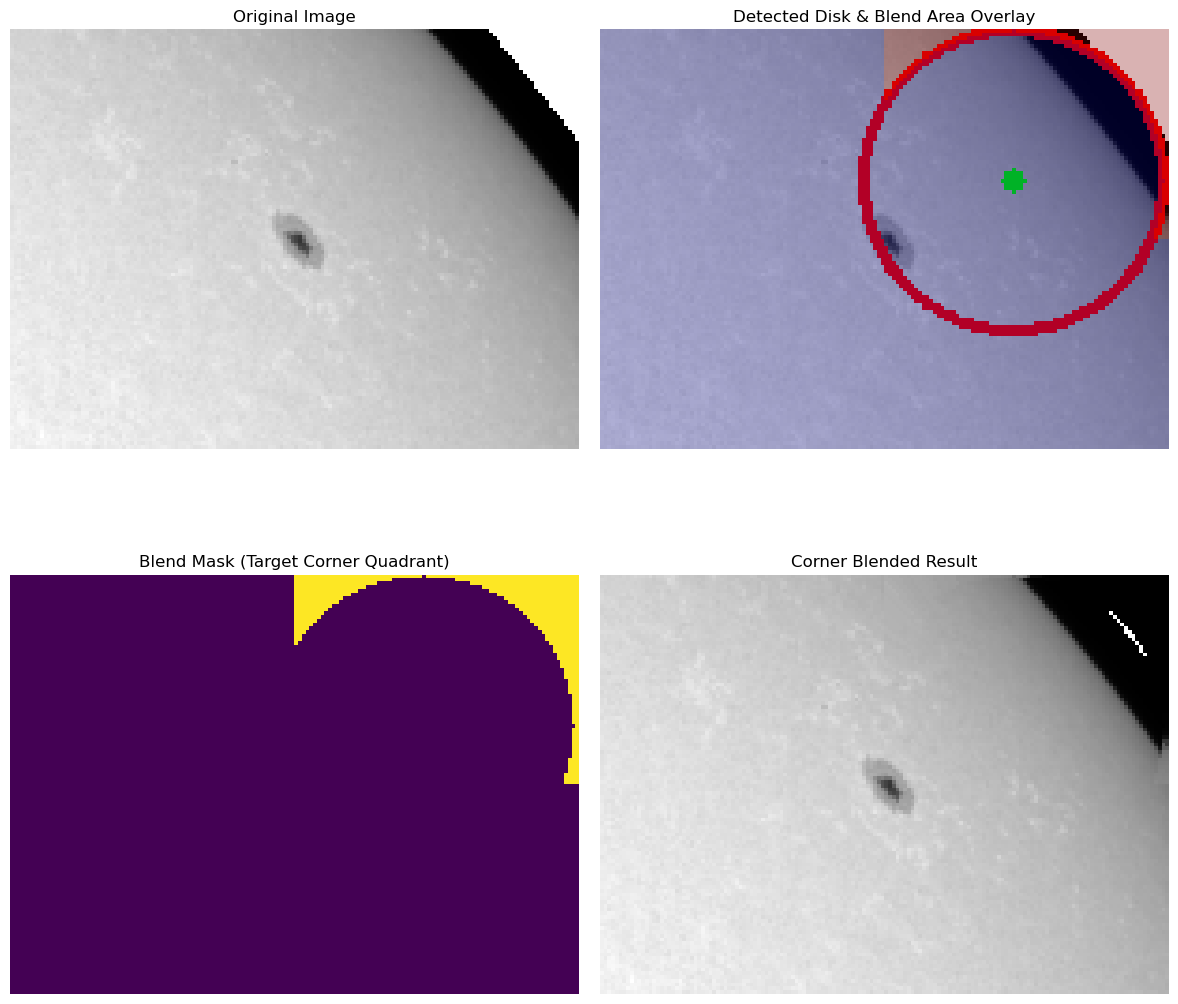

In [292]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from skimage.transform import hough_circle, hough_circle_peaks
import glob
import math

def process_image_with_corner_blending(image_path, radius_margin=10):
    """
    Process a solar image to detect the solar disk and replace pixel values
    outside the disk *only in the corner quadrant nearest to the disk edge*
    with values sampled from inside the disk. Blending only occurs if the
    disk is close to at least one image boundary.

    Args:
        image_path (str): Path to the solar image.
        radius_margin (int): How close the circle center needs to be to an edge
                             (relative to radius) to trigger potential blending.
                             A positive value means blending starts even if the
                             circle doesn't strictly overlap the edge.

    Returns:
        tuple: Original image, annotated image, processed image, and mask.
              Returns (None, None, None, None) if file not found or
              if essential steps like Hough transform fail.
    """
    # --- Load and Prepare the Image ---
    try:
        solar_image = Image.open(image_path).convert("L")
    except FileNotFoundError:
        print(f"Error: Image file not found at {image_path}")
        return None, None, None, None
    original = np.array(solar_image, dtype=np.uint8)
    height, width = original.shape
    img_center_x, img_center_y = width / 2.0, height / 2.0 # Use float for potentially non-integer center

    # --- Sobel Edge Detection ---
    # Using ksize=5 can sometimes help with noisier images or less defined edges
    sobel_x = cv2.Sobel(original, cv2.CV_64F, 1, 0, ksize=3)
    sobel_y = cv2.Sobel(original, cv2.CV_64F, 0, 1, ksize=3)
    abs_sobel_x = cv2.convertScaleAbs(sobel_x)
    abs_sobel_y = cv2.convertScaleAbs(sobel_y)
    edge_image = cv2.addWeighted(abs_sobel_x, 0.5, abs_sobel_y, 0.5, 0)
    # Adjust threshold based on typical edge strength in your images
    _, edge_thresh = cv2.threshold(edge_image, 40, 255, cv2.THRESH_BINARY)

    # --- Hough Circle Detection ---
    # Dynamic radius range based on image size
    min_r = int(min(height, width) * 0.15) # E.g., disk radius is at least 15% of smallest dimension
    max_r = int(min(height, width) * 0.55) # E.g., disk radius is at most 55% of smallest dimension
    step = 2 # Step size for radius search
    radii = np.arange(min_r, max_r, step)

    if len(radii) == 0:
        print(f"Warning: Calculated radii range is empty ({min_r} to {max_r} with step {step}). Check image dimensions or range calculation.")
        # Return gracefully if no radii to check
        annotated_image = cv2.cvtColor(original, cv2.COLOR_GRAY2BGR)
        return original, annotated_image, original.copy(), np.zeros((height, width), dtype=np.float32)

    # Perform Hough Transform
    hough_res = hough_circle(edge_thresh, radii, normalize=False) # Normalize=True might help sometimes

    # Check if Hough accumulator array is valid
    if hough_res is None or np.max(hough_res) == 0:
         print("Hough transform did not yield any results (accumulator array is empty or all zero).")
         annotated_image = cv2.cvtColor(original, cv2.COLOR_GRAY2BGR)
         return original, annotated_image, original.copy(), np.zeros((height, width), dtype=np.float32)

    # Find peaks (circles) in the Hough accumulator
    accums, cx, cy, detected_radii = hough_circle_peaks(
        hough_res, radii,
        min_xdistance=int(width * 0.1), min_ydistance=int(height * 0.1), # Dynamic minimum distance between circle centers
        threshold=0.4 * np.max(hough_res), # Adjust threshold relative to max accumulator value
        total_num_peaks=1 # Focus on the single most likely solar disk
    )

    # --- Initialize Outputs ---
    annotated_image = cv2.cvtColor(original, cv2.COLOR_GRAY2BGR)
    blended_image = original.copy()
    # Use uint8 for mask internally, easier for indexing and visualization
    blend_mask = np.zeros((height, width), dtype=np.uint8)

    if len(accums) > 0:
        # Get the parameters of the best detected circle
        x, y, r = cx[0], cy[0], detected_radii[0]
        r = max(1, r) # Ensure radius is at least 1

        print(f"Detected solar disk at ({x:.2f}, {y:.2f}) with radius {r:.2f}")

        # Draw the detected circle on the annotated image for visualization
        cv2.circle(annotated_image, (int(round(x)), int(round(y))), int(round(r)), (0, 0, 255), 2) # Blue circle edge
        cv2.circle(annotated_image, (int(round(x)), int(round(y))), 3, (0, 255, 0), -1)    # Green center point

        # --- Determine proximity to edges (to decide IF blending is needed at all) ---
        dist_top = y
        dist_bottom = height - y
        dist_left = x
        dist_right = width - x

        # Check if the circle boundary (center +/- radius) is close to or beyond the image edge
        is_close_top = dist_top < r + radius_margin
        is_close_bottom = dist_bottom < r + radius_margin
        is_close_left = dist_left < r + radius_margin
        is_close_right = dist_right < r + radius_margin

        # Blending is only necessary if the circle is close to at least one edge
        needs_blending = is_close_top or is_close_bottom or is_close_left or is_close_right

        if needs_blending:
            print("Circle is close to an edge. Determining closest corner for blending.")

            # --- Identify the closest corner to the circle's EDGE ---
            # Define corner coordinates
            corners = {
                "top-left": (0, 0),
                "top-right": (width - 1, 0),
                "bottom-left": (0, height - 1),
                "bottom-right": (width - 1, height - 1)
            }
            min_dist_to_circumference = float('inf')
            closest_corner_name = None

            # Calculate distance from each corner to the *nearest point on the circle's circumference*
            for name, (corner_x, corner_y) in corners.items():
                # Distance from circle center to this corner
                dist_center_to_corner = math.sqrt((corner_x - x)**2 + (corner_y - y)**2)
                # Distance from the corner to the circumference (absolute difference)
                dist_circumference_to_corner = abs(dist_center_to_corner - r)

                # Keep track of the corner with the minimum distance to the circumference
                if dist_circumference_to_corner < min_dist_to_circumference:
                    min_dist_to_circumference = dist_circumference_to_corner
                    closest_corner_name = name

            print(f"Closest corner identified: {closest_corner_name} (Min distance to circumference: {min_dist_to_circumference:.2f})")

            # --- Create the blend mask for the specific corner quadrant ---
            # Efficiently get coordinates of all pixels
            Y_coords, X_coords = np.ogrid[:height, :width]

            # 1. Mask for pixels strictly outside the detected circle radius
            dist_from_center_sq = (X_coords - x)**2 + (Y_coords - y)**2
            outside_circle_mask = dist_from_center_sq > r**2

            # 2. Mask for the identified corner quadrant (based on image center)
            corner_mask = np.zeros((height, width), dtype=bool) # Initialize as False
            if closest_corner_name == "top-left":
                # Pixels strictly above center-y and strictly left of center-x
                corner_mask = (Y_coords < img_center_y) & (X_coords < img_center_x)
            elif closest_corner_name == "top-right":
                # Pixels strictly above center-y and right of or at center-x
                corner_mask = (Y_coords < img_center_y) & (X_coords >= img_center_x)
            elif closest_corner_name == "bottom-left":
                # Pixels below or at center-y and strictly left of center-x
                corner_mask = (Y_coords >= img_center_y) & (X_coords < img_center_x)
            elif closest_corner_name == "bottom-right":
                 # Pixels below or at center-y and right of or at center-x
                corner_mask = (Y_coords >= img_center_y) & (X_coords >= img_center_x)

            # 3. Final mask: Pixels must be BOTH outside the circle AND within the target corner quadrant
            # Convert boolean result to uint8 (0 or 1)
            blend_mask = (outside_circle_mask & corner_mask).astype(np.uint8)

            # --- Apply Blending using the corner-specific mask ---
            # Get the coordinates (row, col) where the final mask is active (value is 1)
            indices_to_blend = np.argwhere(blend_mask > 0)

            # Define how far inside the radius to sample from
            sampling_offset = 3
            inside_r = max(1, r - sampling_offset) # Ensure sample radius is positive

            if len(indices_to_blend) > 0:
                print(f"Blending {len(indices_to_blend)} pixels in the {closest_corner_name} quadrant...")
                for i, j in indices_to_blend: # i = row (y), j = column (x)
                    # Calculate vector from circle center (x, y) to the pixel (j, i)
                    vec_x = j - x
                    vec_y = i - y
                    dist = math.sqrt(vec_x**2 + vec_y**2) # Magnitude of the vector

                    if dist > 0: # Avoid division by zero for safety
                        # Normalize the direction vector
                        norm_vec_x = vec_x / dist
                        norm_vec_y = vec_y / dist

                        # Calculate the corresponding sample point coordinates inside the disk
                        sample_x = x + norm_vec_x * inside_r
                        sample_y = y + norm_vec_y * inside_r

                        # Convert to integer coordinates and clamp to ensure they are within image bounds
                        sample_x_int = max(0, min(width - 1, int(round(sample_x))))
                        sample_y_int = max(0, min(height - 1, int(round(sample_y))))

                        # Replace the pixel value in the blended image
                        blended_image[i, j] = original[sample_y_int, sample_x_int]
            else:
                 # This might happen if the circle edge is close, but all pixels outside it fall outside the corner quadrant mask
                print(f"No pixels identified for blending within the {closest_corner_name} quadrant (that are also outside the circle).")

            # --- Visualize the specific replaced corner area in the annotated image ---
            if np.any(blend_mask): # Check if the mask has any active pixels
                # Use a distinct colormap for visualization overlay
                blend_viz_color = cv2.applyColorMap(blend_mask * 255, cv2.COLORMAP_JET)
                alpha = 0.3 # Transparency of the overlay
                # Add the colored overlay to the annotated image
                cv2.addWeighted(blend_viz_color, alpha, annotated_image, 1 - alpha, 0, annotated_image)

        else: # needs_blending is False
            print("Circle is fully contained within margins relative to edges. No corner blending applied.")

    else: # No circle detected from Hough peaks
        print("No suitable circle detected after Hough peaks analysis.")
        # annotated_image is already initialized
        # blended_image is a copy of original
        # blend_mask is all zeros

    # Return results, converting mask to float32 if needed by downstream processes or display expectations
    return original, annotated_image, blended_image, blend_mask.astype(np.float32)


def display_results(orig, annotated, blended, blend_mask):
    """
    Display the results from image processing. Handles cases where inputs might be None.
    """
    if orig is None:
        print("Cannot display results because input images are None.")
        return

    fig, axs = plt.subplots(2, 2, figsize=(12, 12)) # Adjust figure size as needed

    # Original image
    axs[0, 0].imshow(orig, cmap="gray")
    axs[0, 0].set_title("Original Image")
    axs[0, 0].axis("off")

    # Annotated image showing circle and blend region overlay
    axs[0, 1].imshow(cv2.cvtColor(annotated, cv2.COLOR_BGR2RGB))
    axs[0, 1].set_title("Detected Disk & Blend Area Overlay")
    axs[0, 1].axis("off")

    # Blend mask (showing the area targeted for blending)
    # Use 'viridis' or 'gray' for better perception of the binary mask area
    axs[1, 0].imshow(blend_mask, cmap="viridis", vmin=0, vmax=1) # Ensure scaling is 0 to 1
    axs[1, 0].set_title("Blend Mask (Target Corner Quadrant)")
    axs[1, 0].axis("off")

    # Blended image (final result)
    axs[1, 1].imshow(blended, cmap="gray")
    axs[1, 1].set_title("Corner Blended Result")
    axs[1, 1].axis("off")

    plt.tight_layout(pad=1.5) # Add some padding between subplots
    plt.show()


# --- Example Usage ---
if __name__ == "__main__":
    # IMPORTANT: Adjust this path to point to your image folder
    image_folder_path = "../Solar_disk_hough_transformation/sample_images/"

    # --- Choose Image Pattern ---
    # Option 1: Process all PNG images in the folder
    # image_pattern = "*.png"

    # Option 2: Process a specific file (ensure it exists!)
    image_pattern = "20110110_065810_AR11140 copy.png" # Replace with your test image name

    # Option 3: Add more specific filenames if needed
    # image_pattern = "image_near_top_left.png"


    image_files = glob.glob(image_folder_path + image_pattern)

    if not image_files:
         print(f"Error: No image files found matching pattern '{image_pattern}' in folder '{image_folder_path}'.")
         print("Please check the path and pattern.")
    else:
        print(f"Found {len(image_files)} image(s) to process.")
        # Process each image found
        for image_path in image_files:
            print(f"\n--- Processing: {image_path} ---")
            # Use the updated function name and pass the radius_margin
            orig, annotated, blended, blend_mask = process_image_with_corner_blending(
                image_path,
                radius_margin=15 # Adjust this margin: larger values make it more likely to trigger blending
            )

            # Display the results only if processing was successful
            if orig is not None:
                display_results(orig, annotated, blended, blend_mask)
            else:
                print(f"Skipping display for {image_path} due to processing error.")

Found 1 image(s) to process.

--- Processing: ../Solar_disk_hough_transformation/sample_images/20110110_065810_AR11140 copy.png ---
Detected solar disk at (93.00, 55.00) with radius 54.00
Circle is close to an edge. Determining closest corner and relative quadrant for blending.
Closest corner identified: top-right
Blending 959 pixels in the quadrant relative to circle center (top-right direction)...


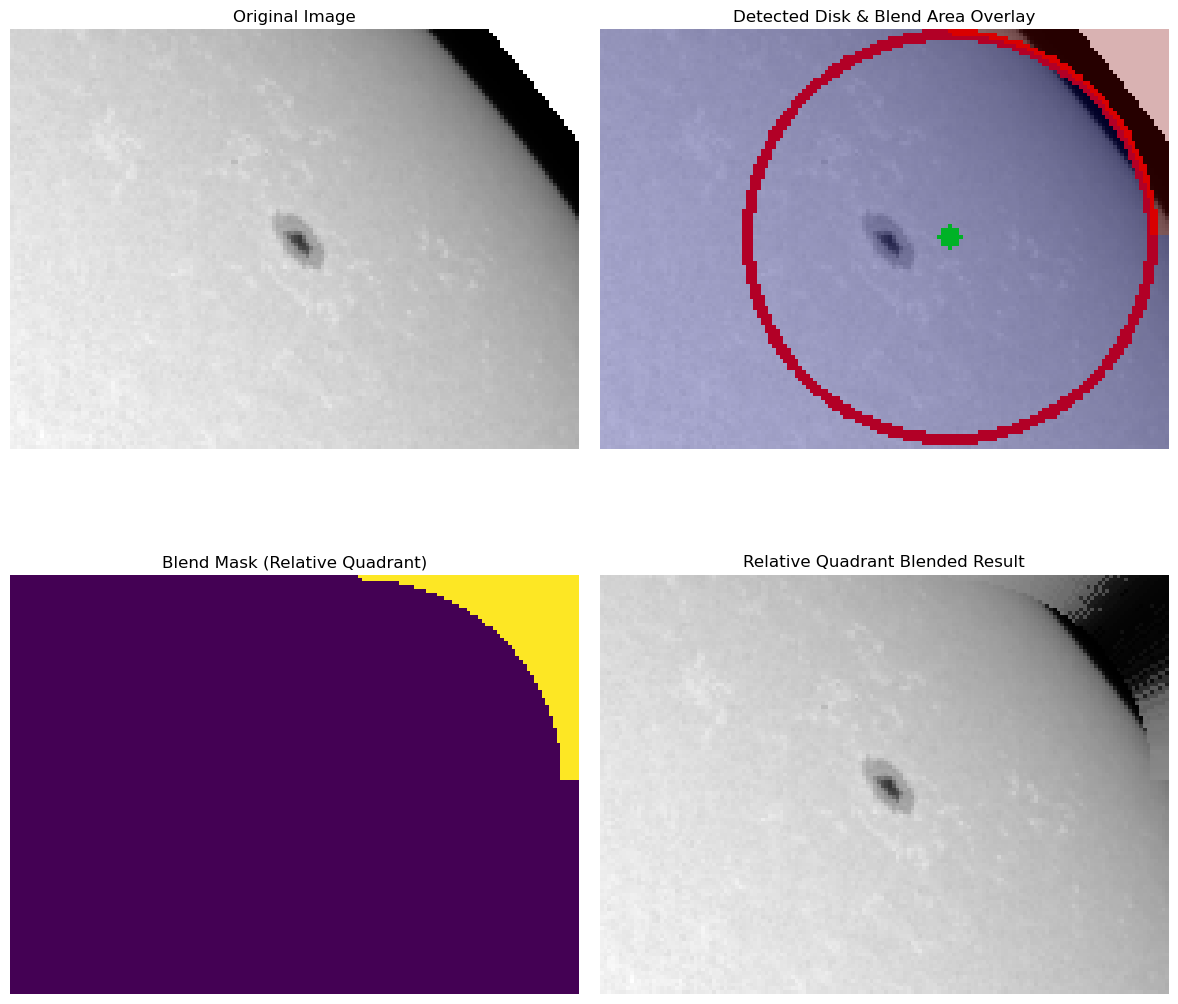

In [296]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from skimage.transform import hough_circle, hough_circle_peaks
import glob
import math

def process_image_with_corner_blending_relative(image_path, radius_margin=10): # Renamed slightly
    """
    Process a solar image to detect the solar disk and replace pixel values
    outside the disk *only in the quadrant relative to the circle's center*
    that corresponds to the image corner nearest to the disk edge.
    Blending only occurs if the disk is close to at least one image boundary.

    Args:
        image_path (str): Path to the solar image.
        radius_margin (int): How close the circle center needs to be to an edge
                             (relative to radius) to trigger potential blending.

    Returns:
        tuple: Original image, annotated image, processed image, and mask.
              Returns (None, None, None, None) if file not found or processing fails.
    """
    # --- Load and Prepare the Image ---
    try:
        solar_image = Image.open(image_path).convert("L")
    except FileNotFoundError:
        print(f"Error: Image file not found at {image_path}")
        return None, None, None, None
    original = np.array(solar_image, dtype=np.uint8)
    height, width = original.shape
    # img_center_x, img_center_y are no longer needed for masking

    # --- Sobel Edge Detection ---
    sobel_x = cv2.Sobel(original, cv2.CV_64F, 1, 0, ksize=5)
    sobel_y = cv2.Sobel(original, cv2.CV_64F, 0, 1, ksize=5)
    abs_sobel_x = cv2.convertScaleAbs(sobel_x)
    abs_sobel_y = cv2.convertScaleAbs(sobel_y)
    edge_image = cv2.addWeighted(abs_sobel_x, 0.5, abs_sobel_y, 0.5, 0)
    _, edge_thresh = cv2.threshold(edge_image, 40, 255, cv2.THRESH_BINARY)

    # --- Hough Circle Detection ---
    min_r = int(min(height, width) * 0.15)
    max_r = int(min(height, width) * 0.55)
    step = 2
    radii = np.arange(min_r, max_r, step)

    if len(radii) == 0:
        print(f"Warning: Calculated radii range is empty ({min_r} to {max_r} with step {step}).")
        annotated_image = cv2.cvtColor(original, cv2.COLOR_GRAY2BGR)
        return original, annotated_image, original.copy(), np.zeros((height, width), dtype=np.float32)

    hough_res = hough_circle(edge_thresh, radii, normalize=False)

    if hough_res is None or np.max(hough_res) == 0:
         print("Hough transform did not yield any results.")
         annotated_image = cv2.cvtColor(original, cv2.COLOR_GRAY2BGR)
         return original, annotated_image, original.copy(), np.zeros((height, width), dtype=np.float32)

    accums, cx, cy, detected_radii = hough_circle_peaks(
        hough_res, radii,
        min_xdistance=int(width * 0.1), min_ydistance=int(height * 0.1),
        threshold=0.4 * np.max(hough_res),
        total_num_peaks=1
    )

    # --- Initialize Outputs ---
    annotated_image = cv2.cvtColor(original, cv2.COLOR_GRAY2BGR)
    blended_image = original.copy()
    blend_mask = np.zeros((height, width), dtype=np.uint8)

    if len(accums) > 0:
        x, y, r = cx[0], cy[0], detected_radii[0]
        r = max(1, r)

        print(f"Detected solar disk at ({x:.2f}, {y:.2f}) with radius {r:.2f}")

        cv2.circle(annotated_image, (int(round(x)), int(round(y))), int(round(r)), (0, 0, 255), 2)
        cv2.circle(annotated_image, (int(round(x)), int(round(y))), 3, (0, 255, 0), -1)

        # --- Determine proximity to edges ---
        dist_top = y
        dist_bottom = height - y
        dist_left = x
        dist_right = width - x
        is_close_top = dist_top < r + radius_margin
        is_close_bottom = dist_bottom < r + radius_margin
        is_close_left = dist_left < r + radius_margin
        is_close_right = dist_right < r + radius_margin
        needs_blending = is_close_top or is_close_bottom or is_close_left or is_close_right

        if needs_blending:
            print("Circle is close to an edge. Determining closest corner and relative quadrant for blending.")

            # --- Identify the closest corner to the circle's EDGE (Same as before) ---
            corners = {
                "top-left": (0, 0), "top-right": (width - 1, 0),
                "bottom-left": (0, height - 1), "bottom-right": (width - 1, height - 1)
            }
            min_dist_to_circumference = float('inf')
            closest_corner_name = None
            for name, (corner_x, corner_y) in corners.items():
                dist_center_to_corner = math.sqrt((corner_x - x)**2 + (corner_y - y)**2)
                dist_circumference_to_corner = abs(dist_center_to_corner - r)
                if dist_circumference_to_corner < min_dist_to_circumference:
                    min_dist_to_circumference = dist_circumference_to_corner
                    closest_corner_name = name
            print(f"Closest corner identified: {closest_corner_name}")

            # --- Create the blend mask using circle center (x,y) for quadrant definition ---
            Y_coords, X_coords = np.ogrid[:height, :width]

            # 1. Mask for pixels strictly outside the detected circle radius
            dist_from_center_sq = (X_coords - x)**2 + (Y_coords - y)**2
            outside_circle_mask = dist_from_center_sq > r**2

            # 2. Mask for the quadrant RELATIVE TO CIRCLE CENTER (x, y) matching the closest corner
            #    Initialize as False, then set True for the relevant quadrant
            relative_quadrant_mask = np.zeros((height, width), dtype=bool)

            # Define quadrants based on circle center (x, y)
            # Using < and >= for stricter quadrant definitions (adjust if needed)
            if closest_corner_name == "top-left":
                # Pixels strictly above circle center y AND strictly left of circle center x
                relative_quadrant_mask = (Y_coords < y) & (X_coords < x)
            elif closest_corner_name == "top-right":
                # Pixels strictly above circle center y AND right of or at circle center x
                relative_quadrant_mask = (Y_coords < y) & (X_coords >= x)
            elif closest_corner_name == "bottom-left":
                # Pixels below or at circle center y AND strictly left of circle center x
                relative_quadrant_mask = (Y_coords >= y) & (X_coords < x)
            elif closest_corner_name == "bottom-right":
                 # Pixels below or at circle center y AND right of or at circle center x
                relative_quadrant_mask = (Y_coords >= y) & (X_coords >= x)

            # 3. Final mask: Pixels must be BOTH outside the circle AND within the target quadrant relative to circle center
            blend_mask = (outside_circle_mask & relative_quadrant_mask).astype(np.uint8)

            # --- Apply Blending using the relative quadrant mask (Loop logic is the same) ---
            indices_to_blend = np.argwhere(blend_mask > 0)
            sampling_offset = 3
            inside_r = max(1, r - sampling_offset)

            if len(indices_to_blend) > 0:
                print(f"Blending {len(indices_to_blend)} pixels in the quadrant relative to circle center ({closest_corner_name} direction)...")
                for i, j in indices_to_blend: # i = row (y), j = column (x)
                    vec_x = j - x
                    vec_y = i - y
                    dist = math.sqrt(vec_x**2 + vec_y**2)
                    if dist > 0:
                        norm_vec_x = vec_x / dist
                        norm_vec_y = vec_y / dist
                        sample_x = x + norm_vec_x * inside_r
                        sample_y = y + norm_vec_y * inside_r
                        sample_x_int = max(0, min(width - 1, int(round(sample_x))))
                        sample_y_int = max(0, min(height - 1, int(round(sample_y))))
                        blended_image[i, j] = original[sample_y_int, sample_x_int]
            else:
                print(f"No pixels identified for blending in the target relative quadrant outside the circle.")

            # --- Visualize the specific replaced area ---
            if np.any(blend_mask):
                blend_viz_color = cv2.applyColorMap(blend_mask * 255, cv2.COLORMAP_JET)
                alpha = 0.3
                cv2.addWeighted(blend_viz_color, alpha, annotated_image, 1 - alpha, 0, annotated_image)

        else: # needs_blending is False
            print("Circle is fully contained within margins relative to edges. No blending applied.")

    else: # No circle detected
        print("No suitable circle detected after Hough peaks analysis.")

    # Return results
    return original, annotated_image, blended_image, blend_mask.astype(np.float32)

# --- Display Function (remains the same) ---
def display_results(orig, annotated, blended, blend_mask):
    if orig is None:
        print("Cannot display results because input images are None.")
        return
    fig, axs = plt.subplots(2, 2, figsize=(12, 12))
    axs[0, 0].imshow(orig, cmap="gray")
    axs[0, 0].set_title("Original Image")
    axs[0, 0].axis("off")
    axs[0, 1].imshow(cv2.cvtColor(annotated, cv2.COLOR_BGR2RGB))
    axs[0, 1].set_title("Detected Disk & Blend Area Overlay")
    axs[0, 1].axis("off")
    axs[1, 0].imshow(blend_mask, cmap="viridis", vmin=0, vmax=1)
    axs[1, 0].set_title("Blend Mask (Relative Quadrant)") # Updated title
    axs[1, 0].axis("off")
    axs[1, 1].imshow(blended, cmap="gray")
    axs[1, 1].set_title("Relative Quadrant Blended Result") # Updated title
    axs[1, 1].axis("off")
    plt.tight_layout(pad=1.5)
    plt.show()

# --- Example Usage (remains the same) ---
if __name__ == "__main__":
    image_folder_path = "../Solar_disk_hough_transformation/sample_images/"
    image_pattern = "20110110_065810_AR11140 copy.png" # Your test image

    image_files = glob.glob(image_folder_path + image_pattern)

    if not image_files:
         print(f"Error: No image files found matching pattern '{image_pattern}' in folder '{image_folder_path}'.")
    else:
        print(f"Found {len(image_files)} image(s) to process.")
        for image_path in image_files:
            print(f"\n--- Processing: {image_path} ---")
            # Use the new function name
            orig, annotated, blended, blend_mask = process_image_with_corner_blending_relative(
                image_path,
                radius_margin=15 # Adjust margin
            )
            if orig is not None:
                display_results(orig, annotated, blended, blend_mask)
            else:
                print(f"Skipping display for {image_path} due to processing error.")

Found 1 image(s) to process.

--- Processing: ../Solar_disk_hough_transformation/sample_images/20110110_065810_AR11140 copy.png ---
Detected solar disk at (93.00, 55.00) with radius 54.00
Circle is close to an edge. Determining closest corner and image quadrant for blending.
Closest corner identified: top-right
Blending 1007 pixels in the top-right image quadrant...


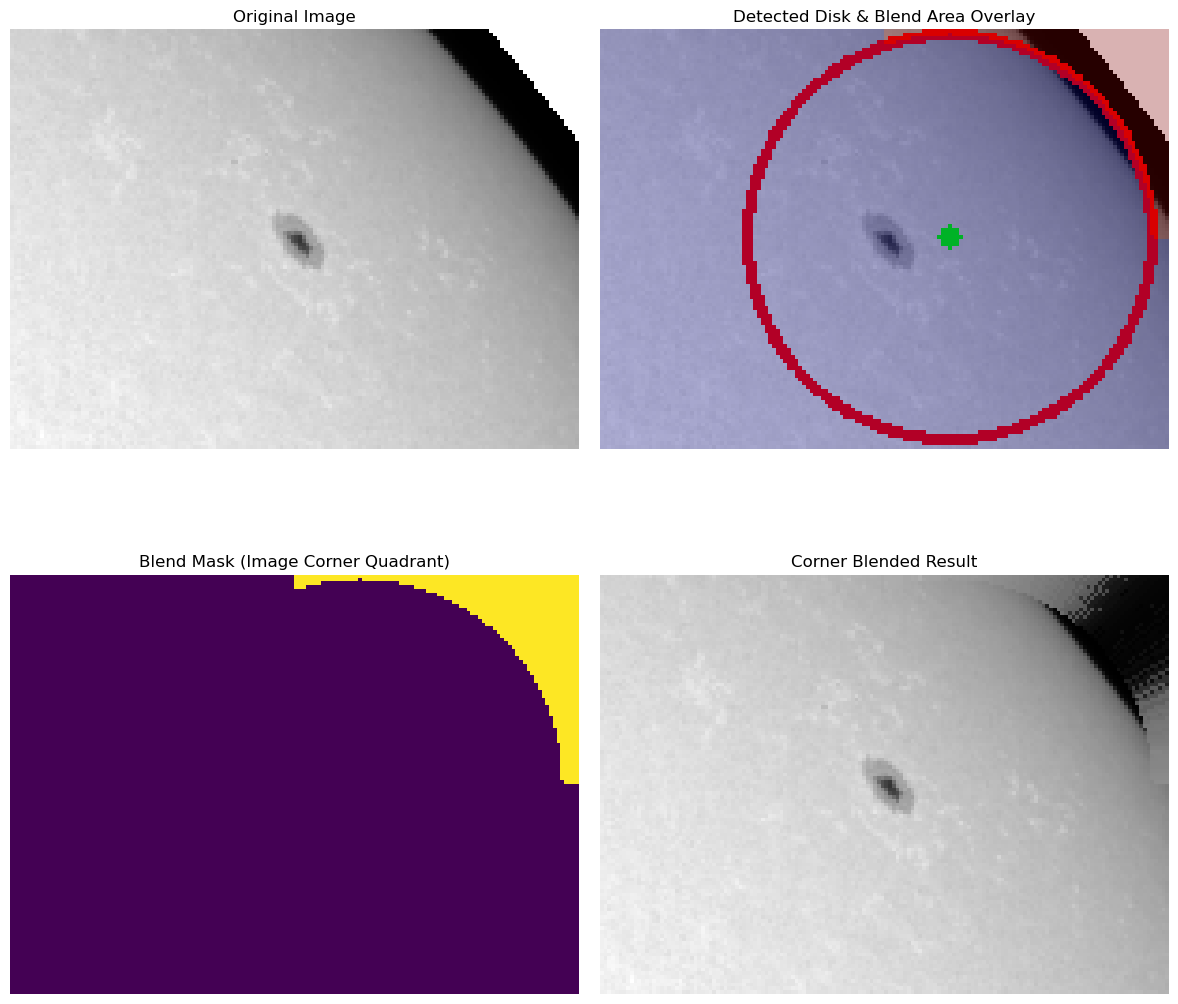

In [300]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from skimage.transform import hough_circle, hough_circle_peaks
import glob
import math

# Use the previous function name that used image center for quadrants
def process_image_with_corner_blending(image_path, radius_margin=10):
    """
    Process a solar image to detect the solar disk and replace pixel values
    outside the disk *only in the IMAGE corner quadrant nearest to the disk edge*
    with values sampled from inside the disk. Blending only occurs if the
    disk is close to at least one image boundary.

    Args:
        image_path (str): Path to the solar image.
        radius_margin (int): How close the circle center needs to be to an edge
                             (relative to radius) to trigger potential blending.

    Returns:
        tuple: Original image, annotated image, processed image, and mask.
              Returns (None, None, None, None) if file not found or processing fails.
    """
    # --- Load and Prepare the Image ---
    try:
        solar_image = Image.open(image_path).convert("L")
    except FileNotFoundError:
        print(f"Error: Image file not found at {image_path}")
        return None, None, None, None
    original = np.array(solar_image, dtype=np.uint8)
    height, width = original.shape
    # Define image center - THIS WILL BE USED FOR MASKING QUADRANT
    img_center_x, img_center_y = width / 2.0, height / 2.0

    # --- Sobel Edge Detection ---
    sobel_x = cv2.Sobel(original, cv2.CV_64F, 1, 0, ksize=5)
    sobel_y = cv2.Sobel(original, cv2.CV_64F, 0, 1, ksize=5)
    abs_sobel_x = cv2.convertScaleAbs(sobel_x)
    abs_sobel_y = cv2.convertScaleAbs(sobel_y)
    edge_image = cv2.addWeighted(abs_sobel_x, 0.5, abs_sobel_y, 0.5, 0)
    _, edge_thresh = cv2.threshold(edge_image, 40, 255, cv2.THRESH_BINARY)

    # --- Hough Circle Detection ---
    min_r = int(min(height, width) * 0.15)
    max_r = int(min(height, width) * 0.55)
    step = 2
    radii = np.arange(min_r, max_r, step)

    if len(radii) == 0:
        print(f"Warning: Calculated radii range is empty ({min_r} to {max_r} with step {step}).")
        annotated_image = cv2.cvtColor(original, cv2.COLOR_GRAY2BGR)
        return original, annotated_image, original.copy(), np.zeros((height, width), dtype=np.float32)

    hough_res = hough_circle(edge_thresh, radii, normalize=False)

    if hough_res is None or np.max(hough_res) == 0:
         print("Hough transform did not yield any results.")
         annotated_image = cv2.cvtColor(original, cv2.COLOR_GRAY2BGR)
         return original, annotated_image, original.copy(), np.zeros((height, width), dtype=np.float32)

    accums, cx, cy, detected_radii = hough_circle_peaks(
        hough_res, radii, # <--- CORRECT VARIABLE NAME
        min_xdistance=int(width * 0.1), min_ydistance=int(height * 0.1),
        threshold=0.4 * np.max(hough_res), # Ensure this one is also correct
        total_num_peaks=1
    )

    # --- Initialize Outputs ---
    annotated_image = cv2.cvtColor(original, cv2.COLOR_GRAY2BGR)
    blended_image = original.copy()
    blend_mask = np.zeros((height, width), dtype=np.uint8)

    if len(accums) > 0:
        x, y, r = cx[0], cy[0], detected_radii[0]
        r = max(1, r)

        print(f"Detected solar disk at ({x:.2f}, {y:.2f}) with radius {r:.2f}")

        cv2.circle(annotated_image, (int(round(x)), int(round(y))), int(round(r)), (0, 0, 255), 2)
        cv2.circle(annotated_image, (int(round(x)), int(round(y))), 3, (0, 255, 0), -1)

        # --- Determine proximity to edges ---
        dist_top = y
        dist_bottom = height - y
        dist_left = x
        dist_right = width - x
        is_close_top = dist_top < r + radius_margin
        is_close_bottom = dist_bottom < r + radius_margin
        is_close_left = dist_left < r + radius_margin
        is_close_right = dist_right < r + radius_margin
        needs_blending = is_close_top or is_close_bottom or is_close_left or is_close_right

        if needs_blending:
            print("Circle is close to an edge. Determining closest corner and image quadrant for blending.")

            # --- Identify the closest corner to the circle's EDGE (Same calculation) ---
            corners = {
                "top-left": (0, 0), "top-right": (width - 1, 0),
                "bottom-left": (0, height - 1), "bottom-right": (width - 1, height - 1)
            }
            min_dist_to_circumference = float('inf')
            closest_corner_name = None
            for name, (corner_x_coord, corner_y_coord) in corners.items(): # Use different var names
                dist_center_to_corner = math.sqrt((corner_x_coord - x)**2 + (corner_y_coord - y)**2)
                dist_circumference_to_corner = abs(dist_center_to_corner - r)
                if dist_circumference_to_corner < min_dist_to_circumference:
                    min_dist_to_circumference = dist_circumference_to_corner
                    closest_corner_name = name
            print(f"Closest corner identified: {closest_corner_name}")

            # --- Create the blend mask using IMAGE CENTER for quadrant definition ---
            Y_coords, X_coords = np.ogrid[:height, :width]

            # 1. Mask for pixels strictly outside the detected circle radius
            dist_from_center_sq = (X_coords - x)**2 + (Y_coords - y)**2
            outside_circle_mask = dist_from_center_sq > r**2

            # 2. Mask for the IMAGE corner quadrant corresponding to closest_corner_name
            #    Initialize as False, then set True for the relevant quadrant
            image_corner_quadrant_mask = np.zeros((height, width), dtype=bool)
            if closest_corner_name == "top-left":
                image_corner_quadrant_mask = (Y_coords < img_center_y) & (X_coords < img_center_x)
            elif closest_corner_name == "top-right":
                image_corner_quadrant_mask = (Y_coords < img_center_y) & (X_coords >= img_center_x)
            elif closest_corner_name == "bottom-left":
                image_corner_quadrant_mask = (Y_coords >= img_center_y) & (X_coords < img_center_x)
            elif closest_corner_name == "bottom-right":
                image_corner_quadrant_mask = (Y_coords >= img_center_y) & (X_coords >= img_center_x)

            # 3. Final mask: Pixels must be BOTH outside the circle AND within the target IMAGE corner quadrant
            blend_mask = (outside_circle_mask & image_corner_quadrant_mask).astype(np.uint8)

            # --- Apply Blending using the image corner quadrant mask (Loop logic is the same) ---
            indices_to_blend = np.argwhere(blend_mask > 0)
            sampling_offset = 3
            inside_r = max(1, r - sampling_offset)

            if len(indices_to_blend) > 0:
                print(f"Blending {len(indices_to_blend)} pixels in the {closest_corner_name} image quadrant...")
                for i, j in indices_to_blend: # i = row (y), j = column (x)
                    vec_x = j - x
                    vec_y = i - y
                    dist = math.sqrt(vec_x**2 + vec_y**2)
                    if dist > 0:
                        norm_vec_x = vec_x / dist
                        norm_vec_y = vec_y / dist
                        sample_x = x + norm_vec_x * inside_r
                        sample_y = y + norm_vec_y * inside_r
                        sample_x_int = max(0, min(width - 1, int(round(sample_x))))
                        sample_y_int = max(0, min(height - 1, int(round(sample_y))))
                        blended_image[i, j] = original[sample_y_int, sample_x_int]
            else:
                print(f"No pixels identified for blending in the target image quadrant outside the circle.")

            # --- Visualize the specific replaced area ---
            if np.any(blend_mask):
                blend_viz_color = cv2.applyColorMap(blend_mask * 255, cv2.COLORMAP_JET)
                alpha = 0.3
                cv2.addWeighted(blend_viz_color, alpha, annotated_image, 1 - alpha, 0, annotated_image)

        else: # needs_blending is False
            print("Circle is fully contained within margins relative to edges. No blending applied.")

    else: # No circle detected
        print("No suitable circle detected after Hough peaks analysis.")

    # Return results
    return original, annotated_image, blended_image, blend_mask.astype(np.float32)

# --- Display Function (Adjust titles back) ---
def display_results(orig, annotated, blended, blend_mask):
    if orig is None:
        print("Cannot display results because input images are None.")
        return
    fig, axs = plt.subplots(2, 2, figsize=(12, 12))
    axs[0, 0].imshow(orig, cmap="gray")
    axs[0, 0].set_title("Original Image")
    axs[0, 0].axis("off")
    axs[0, 1].imshow(cv2.cvtColor(annotated, cv2.COLOR_BGR2RGB))
    axs[0, 1].set_title("Detected Disk & Blend Area Overlay")
    axs[0, 1].axis("off")
    axs[1, 0].imshow(blend_mask, cmap="viridis", vmin=0, vmax=1)
    axs[1, 0].set_title("Blend Mask (Image Corner Quadrant)") # Updated title
    axs[1, 0].axis("off")
    axs[1, 1].imshow(blended, cmap="gray")
    axs[1, 1].set_title("Corner Blended Result") # Updated title
    axs[1, 1].axis("off")
    plt.tight_layout(pad=1.5)
    plt.show()

# --- Example Usage ---
if __name__ == "__main__":
    image_folder_path = "../Solar_disk_hough_transformation/sample_images/"
    image_pattern = "20110110_065810_AR11140 copy.png" # Your test image

    image_files = glob.glob(image_folder_path + image_pattern)

    if not image_files:
         print(f"Error: No image files found matching pattern '{image_pattern}' in folder '{image_folder_path}'.")
    else:
        print(f"Found {len(image_files)} image(s) to process.")
        for image_path in image_files:
            print(f"\n--- Processing: {image_path} ---")
            # Use the function name corresponding to this logic
            orig, annotated, blended, blend_mask = process_image_with_corner_blending(
                image_path,
                radius_margin=15 # Adjust margin
            )
            if orig is not None:
                display_results(orig, annotated, blended, blend_mask)
            else:
                print(f"Skipping display for {image_path} due to processing error.")

Found 1 image(s) to process.

--- Processing: ../Solar_disk_hough_transformation/sample_images/20110110_065810_AR11140 copy.png ---
Detected solar disk at (93.00, 55.00) with radius 54.00
Circle is close to an edge. Determining closest corner and image quadrant for blending.
Closest corner identified: top-right
Using sampling offset: 7
Blending 1007 pixels in the top-right image quadrant...


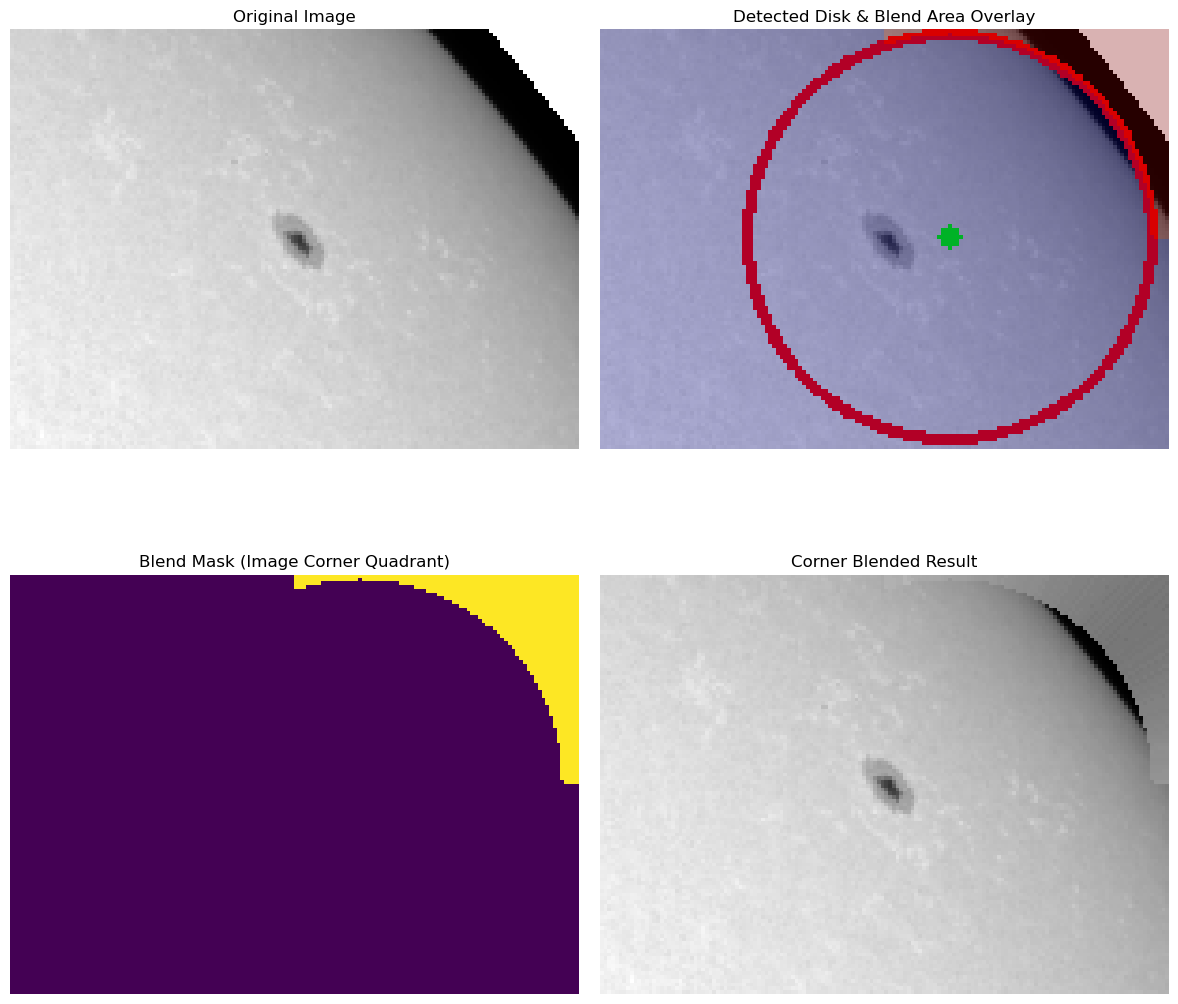

In [304]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from skimage.transform import hough_circle, hough_circle_peaks
import glob
import math

# Use the previous function name that used image center for quadrants
def process_image_with_corner_blending(image_path, radius_margin=10, sampling_offset_val=7): # Added sampling_offset_val arg
    """
    Process a solar image to detect the solar disk and replace pixel values
    outside the disk *only in the IMAGE corner quadrant nearest to the disk edge*
    with values sampled from further inside the disk. Blending only occurs if the
    disk is close to at least one image boundary.

    Args:
        image_path (str): Path to the solar image.
        radius_margin (int): How close the circle center needs to be to an edge
                             (relative to radius) to trigger potential blending.
        sampling_offset_val (int): How many pixels inside the radius 'r' to sample from.

    Returns:
        tuple: Original image, annotated image, processed image, and mask.
              Returns (None, None, None, None) if file not found or processing fails.
    """
    # --- Load and Prepare the Image ---
    try:
        solar_image = Image.open(image_path).convert("L")
    except FileNotFoundError:
        print(f"Error: Image file not found at {image_path}")
        return None, None, None, None
    original = np.array(solar_image, dtype=np.uint8)
    height, width = original.shape
    # Define image center - THIS WILL BE USED FOR MASKING QUADRANT
    img_center_x, img_center_y = width / 2.0, height / 2.0

    # --- Sobel Edge Detection ---
    sobel_x = cv2.Sobel(original, cv2.CV_64F, 1, 0, ksize=5)
    sobel_y = cv2.Sobel(original, cv2.CV_64F, 0, 1, ksize=5)
    abs_sobel_x = cv2.convertScaleAbs(sobel_x)
    abs_sobel_y = cv2.convertScaleAbs(sobel_y)
    edge_image = cv2.addWeighted(abs_sobel_x, 0.5, abs_sobel_y, 0.5, 0)
    _, edge_thresh = cv2.threshold(edge_image, 40, 255, cv2.THRESH_BINARY)

    # --- Hough Circle Detection ---
    min_r = int(min(height, width) * 0.15)
    max_r = int(min(height, width) * 0.55)
    step = 2
    radii = np.arange(min_r, max_r, step)

    if len(radii) == 0:
        print(f"Warning: Calculated radii range is empty ({min_r} to {max_r} with step {step}).")
        annotated_image = cv2.cvtColor(original, cv2.COLOR_GRAY2BGR)
        return original, annotated_image, original.copy(), np.zeros((height, width), dtype=np.float32)

    hough_res = hough_circle(edge_thresh, radii, normalize=False)

    if hough_res is None or np.max(hough_res) == 0:
         print("Hough transform did not yield any results.")
         annotated_image = cv2.cvtColor(original, cv2.COLOR_GRAY2BGR)
         return original, annotated_image, original.copy(), np.zeros((height, width), dtype=np.float32)

    accums, cx, cy, detected_radii = hough_circle_peaks(
        hough_res, radii, # Corrected variable name here
        min_xdistance=int(width * 0.1), min_ydistance=int(height * 0.1),
        threshold=0.4 * np.max(hough_res),
        total_num_peaks=1
    )

    # --- Initialize Outputs ---
    annotated_image = cv2.cvtColor(original, cv2.COLOR_GRAY2BGR)
    blended_image = original.copy()
    blend_mask = np.zeros((height, width), dtype=np.uint8)

    if len(accums) > 0:
        x, y, r = cx[0], cy[0], detected_radii[0]
        r = max(1, r)

        print(f"Detected solar disk at ({x:.2f}, {y:.2f}) with radius {r:.2f}")

        cv2.circle(annotated_image, (int(round(x)), int(round(y))), int(round(r)), (0, 0, 255), 2)
        cv2.circle(annotated_image, (int(round(x)), int(round(y))), 3, (0, 255, 0), -1)

        # --- Determine proximity to edges ---
        dist_top = y
        dist_bottom = height - y
        dist_left = x
        dist_right = width - x
        is_close_top = dist_top < r + radius_margin
        is_close_bottom = dist_bottom < r + radius_margin
        is_close_left = dist_left < r + radius_margin
        is_close_right = dist_right < r + radius_margin
        needs_blending = is_close_top or is_close_bottom or is_close_left or is_close_right

        if needs_blending:
            print("Circle is close to an edge. Determining closest corner and image quadrant for blending.")

            # --- Identify the closest corner to the circle's EDGE (Same calculation) ---
            corners = {
                "top-left": (0, 0), "top-right": (width - 1, 0),
                "bottom-left": (0, height - 1), "bottom-right": (width - 1, height - 1)
            }
            min_dist_to_circumference = float('inf')
            closest_corner_name = None
            for name, (corner_x_coord, corner_y_coord) in corners.items():
                dist_center_to_corner = math.sqrt((corner_x_coord - x)**2 + (corner_y_coord - y)**2)
                dist_circumference_to_corner = abs(dist_center_to_corner - r)
                if dist_circumference_to_corner < min_dist_to_circumference:
                    min_dist_to_circumference = dist_circumference_to_corner
                    closest_corner_name = name
            print(f"Closest corner identified: {closest_corner_name}")

            # --- Create the blend mask using IMAGE CENTER for quadrant definition ---
            Y_coords, X_coords = np.ogrid[:height, :width]

            # 1. Mask for pixels strictly outside the detected circle radius
            dist_from_center_sq = (X_coords - x)**2 + (Y_coords - y)**2
            outside_circle_mask = dist_from_center_sq > r**2

            # 2. Mask for the IMAGE corner quadrant corresponding to closest_corner_name
            image_corner_quadrant_mask = np.zeros((height, width), dtype=bool)
            if closest_corner_name == "top-left":
                image_corner_quadrant_mask = (Y_coords < img_center_y) & (X_coords < img_center_x)
            elif closest_corner_name == "top-right":
                image_corner_quadrant_mask = (Y_coords < img_center_y) & (X_coords >= img_center_x)
            elif closest_corner_name == "bottom-left":
                image_corner_quadrant_mask = (Y_coords >= img_center_y) & (X_coords < img_center_x)
            elif closest_corner_name == "bottom-right":
                image_corner_quadrant_mask = (Y_coords >= img_center_y) & (X_coords >= img_center_x)

            # 3. Final mask: Pixels must be BOTH outside the circle AND within the target IMAGE corner quadrant
            blend_mask = (outside_circle_mask & image_corner_quadrant_mask).astype(np.uint8)

            # --- Apply Blending using the image corner quadrant mask ---
            indices_to_blend = np.argwhere(blend_mask > 0)

            # <<<--- INCREASED SAMPLING OFFSET ---<<<
            sampling_offset = sampling_offset_val # Use the function argument
            print(f"Using sampling offset: {sampling_offset}")
            # <<<--------------------------------->>>

            inside_r = max(1, r - sampling_offset) # Calculate sample radius

            if len(indices_to_blend) > 0:
                print(f"Blending {len(indices_to_blend)} pixels in the {closest_corner_name} image quadrant...")
                for i, j in indices_to_blend: # i = row (y), j = column (x)
                    vec_x = j - x
                    vec_y = i - y
                    dist = math.sqrt(vec_x**2 + vec_y**2)
                    if dist > 0:
                        norm_vec_x = vec_x / dist
                        norm_vec_y = vec_y / dist
                        sample_x = x + norm_vec_x * inside_r
                        sample_y = y + norm_vec_y * inside_r
                        sample_x_int = max(0, min(width - 1, int(round(sample_x))))
                        sample_y_int = max(0, min(height - 1, int(round(sample_y))))

                        # --- Check Sampled Value (Optional Debugging) ---
                        # sampled_value = original[sample_y_int, sample_x_int]
                        # if sampled_value < 20: # If sampling a very dark pixel
                        #    print(f"Warning: Sampled dark pixel ({sampled_value}) for target ({i},{j}). Sampled from ({sample_y_int},{sample_x_int})")
                        #    # Optionally: Use a default bright value or average of neighbors instead
                        #    # blended_image[i, j] = default_brightness
                        #    # continue # Skip assignment if using default
                        # blended_image[i, j] = sampled_value
                        # --- End Debugging ---

                        # Original assignment:
                        blended_image[i, j] = original[sample_y_int, sample_x_int]
            else:
                print(f"No pixels identified for blending in the target image quadrant outside the circle.")

            # --- Visualize the specific replaced area ---
            if np.any(blend_mask):
                blend_viz_color = cv2.applyColorMap(blend_mask * 255, cv2.COLORMAP_JET)
                alpha = 0.3
                cv2.addWeighted(blend_viz_color, alpha, annotated_image, 1 - alpha, 0, annotated_image)

        else: # needs_blending is False
            print("Circle is fully contained within margins relative to edges. No blending applied.")

    else: # No circle detected
        print("No suitable circle detected after Hough peaks analysis.")

    # Return results
    return original, annotated_image, blended_image, blend_mask.astype(np.float32)

# --- Display Function (remains the same) ---
def display_results(orig, annotated, blended, blend_mask):
    if orig is None:
        print("Cannot display results because input images are None.")
        return
    fig, axs = plt.subplots(2, 2, figsize=(12, 12))
    axs[0, 0].imshow(orig, cmap="gray")
    axs[0, 0].set_title("Original Image")
    axs[0, 0].axis("off")
    axs[0, 1].imshow(cv2.cvtColor(annotated, cv2.COLOR_BGR2RGB))
    axs[0, 1].set_title("Detected Disk & Blend Area Overlay")
    axs[0, 1].axis("off")
    axs[1, 0].imshow(blend_mask, cmap="viridis", vmin=0, vmax=1)
    axs[1, 0].set_title("Blend Mask (Image Corner Quadrant)")
    axs[1, 0].axis("off")
    axs[1, 1].imshow(blended, cmap="gray")
    axs[1, 1].set_title("Corner Blended Result")
    axs[1, 1].axis("off")
    plt.tight_layout(pad=1.5)
    plt.show()

# --- Example Usage ---
if __name__ == "__main__":
    image_folder_path = "../Solar_disk_hough_transformation/sample_images/"
    image_pattern = "20110110_065810_AR11140 copy.png" # Your test image

    image_files = glob.glob(image_folder_path + image_pattern)

    if not image_files:
         print(f"Error: No image files found matching pattern '{image_pattern}' in folder '{image_folder_path}'.")
    else:
        print(f"Found {len(image_files)} image(s) to process.")
        for image_path in image_files:
            print(f"\n--- Processing: {image_path} ---")
            # Use the function name corresponding to this logic
            # Pass the desired sampling offset
            orig, annotated, blended, blend_mask = process_image_with_corner_blending(
                image_path,
                radius_margin=15, # Adjust margin if needed
                sampling_offset_val=7 # TRY INCREASING THIS (e.g., 5, 7, 10)
            )
            if orig is not None:
                display_results(orig, annotated, blended, blend_mask)
            else:
                print(f"Skipping display for {image_path} due to processing error.")

Error: No image files found matching pattern 'Screenshot 2025-03-31 at 4.27.54 PM.jpg' in folder '../Solar_disk_hough_transformation/sample_images/'.
Trying default pattern '20110110_065810_AR11140 copy.png'...
Found 1 image(s) to process.

--- Processing: ../Solar_disk_hough_transformation/sample_images/20110110_065810_AR11140 copy.png ---
Detected solar disk at (93.00, 55.00) with radius 54.00
Circle is close to an edge. Determining target corner based on edge pixel density.
  Quadrant top-left: 3695 edge pixels
  Quadrant top-right: 3649 edge pixels
  Quadrant bottom-left: 3724 edge pixels
  Quadrant bottom-right: 3791 edge pixels
Target corner based on max edge pixels: bottom-right (3791 pixels)
Using sampling offset: 7
Blending 1079 pixels in the bottom-right image quadrant...


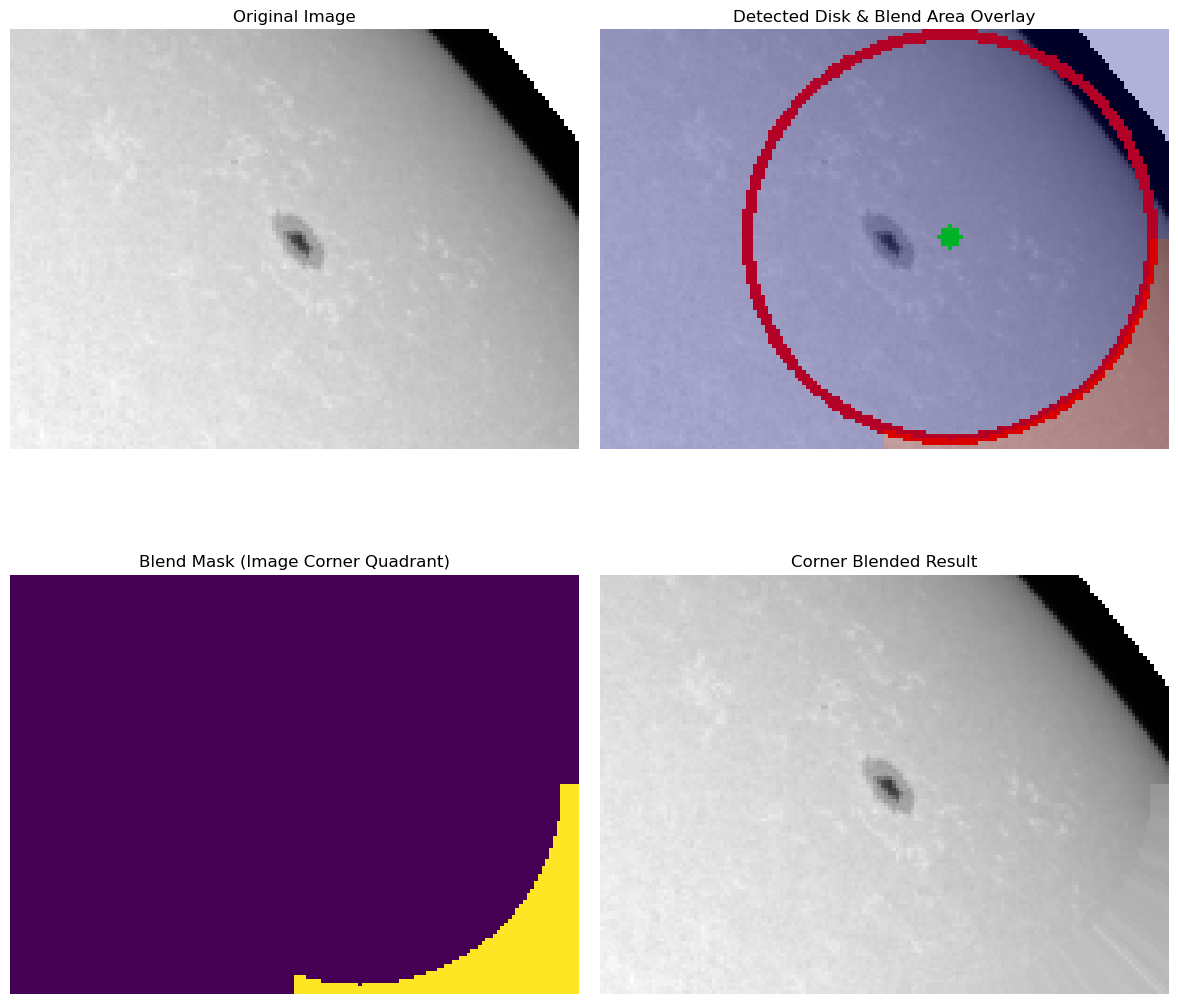

In [308]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from skimage.transform import hough_circle, hough_circle_peaks
import glob
import math

# Keep using the function that worked for blending, just change corner logic
def process_image_with_corner_blending_edge_density(image_path, radius_margin=10, sampling_offset_val=7): # New name
    """
    Process a solar image to detect the solar disk. Identifies the image corner
    quadrant containing the most edge pixels. Blends pixels outside the disk
    within that quadrant using values sampled from inside the disk.
    Blending only occurs if the disk is close to at least one image boundary.

    Args:
        image_path (str): Path to the solar image.
        radius_margin (int): How close the circle center needs to be to an edge
                             (relative to radius) to trigger potential blending.
        sampling_offset_val (int): How many pixels inside the radius 'r' to sample from.

    Returns:
        tuple: Original image, annotated image, processed image, and mask.
              Returns (None, None, None, None) if file not found or processing fails.
    """
    # --- Load and Prepare the Image ---
    try:
        solar_image = Image.open(image_path).convert("L")
    except FileNotFoundError:
        print(f"Error: Image file not found at {image_path}")
        return None, None, None, None
    original = np.array(solar_image, dtype=np.uint8)
    height, width = original.shape
    img_center_x_float, img_center_y_float = width / 2.0, height / 2.0 # Keep float for potential mask use later?
    img_center_x_int, img_center_y_int = width // 2, height // 2 # Integer for slicing

    # --- Sobel Edge Detection ---
    sobel_x = cv2.Sobel(original, cv2.CV_64F, 1, 0, ksize=5)
    sobel_y = cv2.Sobel(original, cv2.CV_64F, 0, 1, ksize=5)
    abs_sobel_x = cv2.convertScaleAbs(sobel_x)
    abs_sobel_y = cv2.convertScaleAbs(sobel_y)
    edge_image = cv2.addWeighted(abs_sobel_x, 0.5, abs_sobel_y, 0.5, 0)
    _, edge_thresh = cv2.threshold(edge_image, 40, 255, cv2.THRESH_BINARY) # Keep edge_thresh!

    # --- Hough Circle Detection ---
    min_r = int(min(height, width) * 0.15)
    max_r = int(min(height, width) * 0.55)
    step = 2
    radii = np.arange(min_r, max_r, step)

    if len(radii) == 0:
        print(f"Warning: Calculated radii range is empty.")
        annotated_image = cv2.cvtColor(original, cv2.COLOR_GRAY2BGR)
        return original, annotated_image, original.copy(), np.zeros((height, width), dtype=np.float32)

    hough_res = hough_circle(edge_thresh, radii, normalize=False)

    if hough_res is None or np.max(hough_res) == 0:
         print("Hough transform did not yield any results.")
         annotated_image = cv2.cvtColor(original, cv2.COLOR_GRAY2BGR)
         return original, annotated_image, original.copy(), np.zeros((height, width), dtype=np.float32)

    accums, cx, cy, detected_radii = hough_circle_peaks(
        hough_res, radii,
        min_xdistance=int(width * 0.1), min_ydistance=int(height * 0.1),
        threshold=0.4 * np.max(hough_res),
        total_num_peaks=1
    )

    # --- Initialize Outputs ---
    annotated_image = cv2.cvtColor(original, cv2.COLOR_GRAY2BGR)
    blended_image = original.copy()
    blend_mask = np.zeros((height, width), dtype=np.uint8)

    if len(accums) > 0:
        x, y, r = cx[0], cy[0], detected_radii[0]
        r = max(1, r)

        print(f"Detected solar disk at ({x:.2f}, {y:.2f}) with radius {r:.2f}")

        cv2.circle(annotated_image, (int(round(x)), int(round(y))), int(round(r)), (0, 0, 255), 2)
        cv2.circle(annotated_image, (int(round(x)), int(round(y))), 3, (0, 255, 0), -1)

        # --- Determine proximity to edges (still needed to decide *if* blending occurs) ---
        dist_top = y
        dist_bottom = height - y
        dist_left = x
        dist_right = width - x
        radius_margin_check = 10 # Keep a margin for this check
        is_close_top = dist_top < r + radius_margin_check
        is_close_bottom = dist_bottom < r + radius_margin_check
        is_close_left = dist_left < r + radius_margin_check
        is_close_right = dist_right < r + radius_margin_check
        needs_blending = is_close_top or is_close_bottom or is_close_left or is_close_right

        if needs_blending:
            print("Circle is close to an edge. Determining target corner based on edge pixel density.")

            # --- Identify corner based on MAX EDGE PIXELS in image quadrant ---
            # Use integer slicing indices based on image center
            quadrants = {
                "top-left": edge_thresh[0:img_center_y_int, 0:img_center_x_int],
                "top-right": edge_thresh[0:img_center_y_int, img_center_x_int:width],
                "bottom-left": edge_thresh[img_center_y_int:height, 0:img_center_x_int],
                "bottom-right": edge_thresh[img_center_y_int:height, img_center_x_int:width]
            }

            max_edge_pixels = -1
            target_corner_name = None # Renamed from closest_corner_name

            for name, quadrant_slice in quadrants.items():
                # Count white pixels (value > 0) in the quadrant
                edge_pixel_count = np.count_nonzero(quadrant_slice)
                print(f"  Quadrant {name}: {edge_pixel_count} edge pixels")
                # Select the quadrant with the most edge pixels
                if edge_pixel_count > max_edge_pixels:
                    max_edge_pixels = edge_pixel_count
                    target_corner_name = name
                # Simple tie-breaking: first one encountered with max wins.

            # Handle case where no edge pixels are found (highly unlikely if needs_blending is True)
            if target_corner_name is None:
                 print("Warning: No edge pixels detected in any quadrant, cannot determine target corner for blending.")
                 # Optionally return or default to a specific corner? For now, continue without mask.
                 target_corner_name = "top-left" # Example default, but likely won't blend

            print(f"Target corner based on max edge pixels: {target_corner_name} ({max_edge_pixels} pixels)")

            # --- Create the blend mask using IMAGE CENTER for quadrant definition (using the new target_corner_name) ---
            Y_coords, X_coords = np.ogrid[:height, :width]

            # 1. Mask for pixels strictly outside the detected circle radius
            dist_from_center_sq = (X_coords - x)**2 + (Y_coords - y)**2
            outside_circle_mask = dist_from_center_sq > r**2

            # 2. Mask for the IMAGE corner quadrant corresponding to target_corner_name
            image_corner_quadrant_mask = np.zeros((height, width), dtype=bool)
            if target_corner_name == "top-left":
                image_corner_quadrant_mask = (Y_coords < img_center_y_float) & (X_coords < img_center_x_float)
            elif target_corner_name == "top-right":
                image_corner_quadrant_mask = (Y_coords < img_center_y_float) & (X_coords >= img_center_x_float)
            elif target_corner_name == "bottom-left":
                image_corner_quadrant_mask = (Y_coords >= img_center_y_float) & (X_coords < img_center_x_float)
            elif target_corner_name == "bottom-right":
                image_corner_quadrant_mask = (Y_coords >= img_center_y_float) & (X_coords >= img_center_x_float)

            # 3. Final mask: Pixels must be BOTH outside the circle AND within the target IMAGE corner quadrant
            blend_mask = (outside_circle_mask & image_corner_quadrant_mask).astype(np.uint8)

            # --- Apply Blending using the image corner quadrant mask (using increased sampling offset) ---
            indices_to_blend = np.argwhere(blend_mask > 0)
            sampling_offset = sampling_offset_val # Use the function argument
            print(f"Using sampling offset: {sampling_offset}")
            inside_r = max(1, r - sampling_offset) # Calculate sample radius

            if len(indices_to_blend) > 0:
                print(f"Blending {len(indices_to_blend)} pixels in the {target_corner_name} image quadrant...")
                # Blending loop remains the same
                for i, j in indices_to_blend:
                    vec_x = j - x
                    vec_y = i - y
                    dist = math.sqrt(vec_x**2 + vec_y**2)
                    if dist > 0:
                        norm_vec_x = vec_x / dist
                        norm_vec_y = vec_y / dist
                        sample_x = x + norm_vec_x * inside_r
                        sample_y = y + norm_vec_y * inside_r
                        sample_x_int = max(0, min(width - 1, int(round(sample_x))))
                        sample_y_int = max(0, min(height - 1, int(round(sample_y))))
                        blended_image[i, j] = original[sample_y_int, sample_x_int]
            else:
                print(f"No pixels identified for blending in the target image quadrant outside the circle.")

            # --- Visualize the specific replaced area ---
            if np.any(blend_mask):
                blend_viz_color = cv2.applyColorMap(blend_mask * 255, cv2.COLORMAP_JET)
                alpha = 0.3
                cv2.addWeighted(blend_viz_color, alpha, annotated_image, 1 - alpha, 0, annotated_image)

        else: # needs_blending is False
            print("Circle is fully contained within margins relative to edges. No blending applied.")

    else: # No circle detected
        print("No suitable circle detected after Hough peaks analysis.")

    # Return results
    return original, annotated_image, blended_image, blend_mask.astype(np.float32)

# --- Display Function (remains the same) ---
def display_results(orig, annotated, blended, blend_mask):
    if orig is None:
        print("Cannot display results because input images are None.")
        return
    fig, axs = plt.subplots(2, 2, figsize=(12, 12))
    axs[0, 0].imshow(orig, cmap="gray")
    axs[0, 0].set_title("Original Image")
    axs[0, 0].axis("off")
    axs[0, 1].imshow(cv2.cvtColor(annotated, cv2.COLOR_BGR2RGB))
    axs[0, 1].set_title("Detected Disk & Blend Area Overlay")
    axs[0, 1].axis("off")
    axs[1, 0].imshow(blend_mask, cmap="viridis", vmin=0, vmax=1)
    axs[1, 0].set_title("Blend Mask (Image Corner Quadrant)")
    axs[1, 0].axis("off")
    axs[1, 1].imshow(blended, cmap="gray")
    axs[1, 1].set_title("Corner Blended Result")
    axs[1, 1].axis("off")
    plt.tight_layout(pad=1.5)
    plt.show()

# --- Example Usage ---
if __name__ == "__main__":
    image_folder_path = "../Solar_disk_hough_transformation/sample_images/"
    # Use the image from the screenshot where corner selection failed
    image_pattern = "Screenshot 2025-03-31 at 4.27.54 PM.jpg" #<-- Make sure this filename is correct or use the original name
    # Or use the original image file if the screenshot is not in the path
    # image_pattern = "original_filename_for_that_screenshot.png"

    image_files = glob.glob(image_folder_path + image_pattern)

    if not image_files:
         print(f"Error: No image files found matching pattern '{image_pattern}' in folder '{image_folder_path}'.")
         # Try the default pattern as a fallback if specific one not found
         print("Trying default pattern '20110110_065810_AR11140 copy.png'...")
         image_pattern = "20110110_065810_AR11140 copy.png"
         image_files = glob.glob(image_folder_path + image_pattern)
         if not image_files:
              print("Default pattern also not found. Please check path and filenames.")

    if image_files:
        print(f"Found {len(image_files)} image(s) to process.")
        for image_path in image_files:
            print(f"\n--- Processing: {image_path} ---")
            # Use the new function name
            orig, annotated, blended, blend_mask = process_image_with_corner_blending_edge_density(
                image_path,
                radius_margin=15, # This margin is just for the initial check if blending is needed
                sampling_offset_val=7 # Keep the increased offset that worked
            )
            if orig is not None:
                display_results(orig, annotated, blended, blend_mask)
            else:
                print(f"Skipping display for {image_path} due to processing error.")

Error: No image files found matching pattern 'Screenshot 2025-03-31 at 4.27.54 PM.jpg' in folder '../Solar_disk_hough_transformation/sample_images/'.
Trying default pattern '20110110_065810_AR11140 copy.png'...
Found 34 image(s) to process.

--- Processing: ../Solar_disk_hough_transformation/sample_images/20121022_235815_AR11598 copy.png ---
Detected solar disk at (54.00, 58.00) with radius 52.00
Circle is close to an edge. Determining target corner based on sum of gradient magnitudes.
  Quadrant top-left: Sum of gradients = 364387.00
  Quadrant top-right: Sum of gradients = 320010.00
  Quadrant bottom-left: Sum of gradients = 461671.00
  Quadrant bottom-right: Sum of gradients = 358026.00
Target corner based on max gradient sum: bottom-left (Sum: 461671.00)
Using sampling offset: 7
Blending 851 pixels in the bottom-left image quadrant...


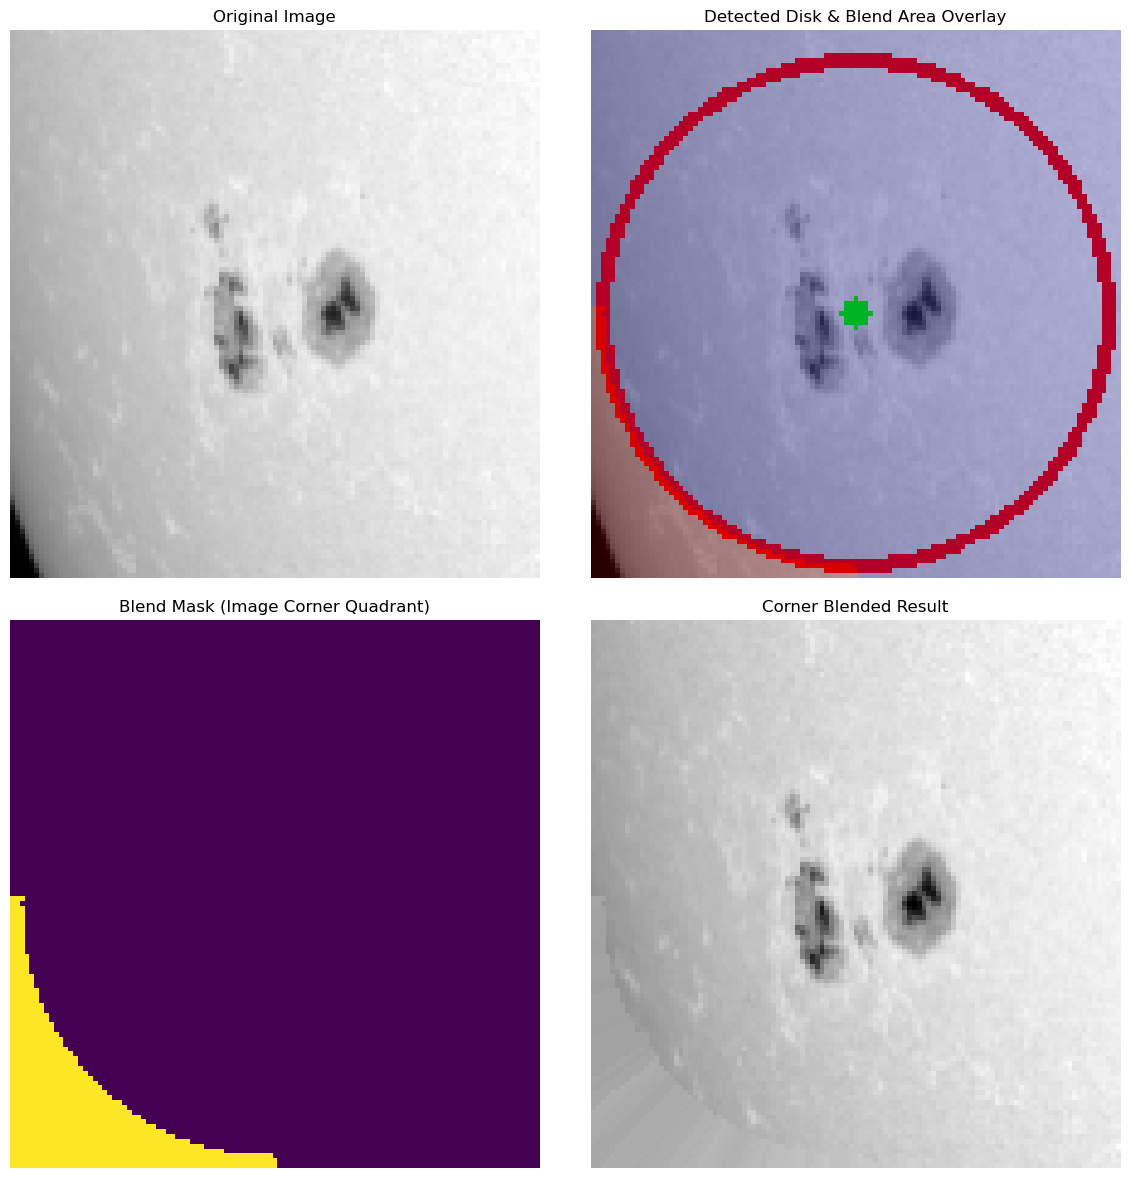


--- Processing: ../Solar_disk_hough_transformation/sample_images/20100720_185826_AR11089 copy.png ---
Detected solar disk at (78.00, 52.00) with radius 49.00
Circle is close to an edge. Determining target corner based on sum of gradient magnitudes.
  Quadrant top-left: Sum of gradients = 571377.00
  Quadrant top-right: Sum of gradients = 467774.00
  Quadrant bottom-left: Sum of gradients = 662500.00
  Quadrant bottom-right: Sum of gradients = 415550.00
Target corner based on max gradient sum: bottom-left (Sum: 662500.00)
Using sampling offset: 7
Blending 2066 pixels in the bottom-left image quadrant...


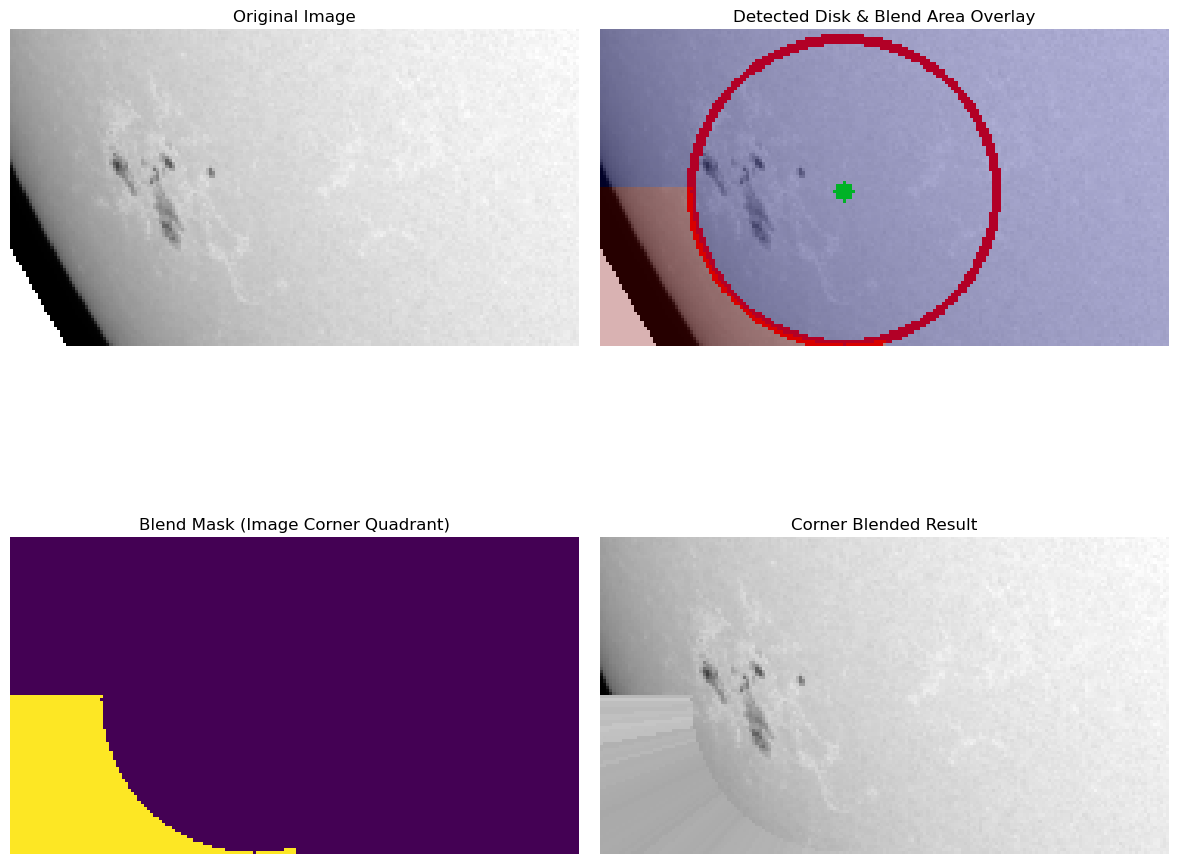


--- Processing: ../Solar_disk_hough_transformation/sample_images/20110808_211900_AR11263 copy.png ---
Detected solar disk at (44.00, 41.00) with radius 37.00
Circle is close to an edge. Determining target corner based on sum of gradient magnitudes.
  Quadrant top-left: Sum of gradients = 217613.00
  Quadrant top-right: Sum of gradients = 276603.00
  Quadrant bottom-left: Sum of gradients = 286539.00
  Quadrant bottom-right: Sum of gradients = 311188.00
Target corner based on max gradient sum: bottom-right (Sum: 311188.00)
Using sampling offset: 7
Blending 337 pixels in the bottom-right image quadrant...


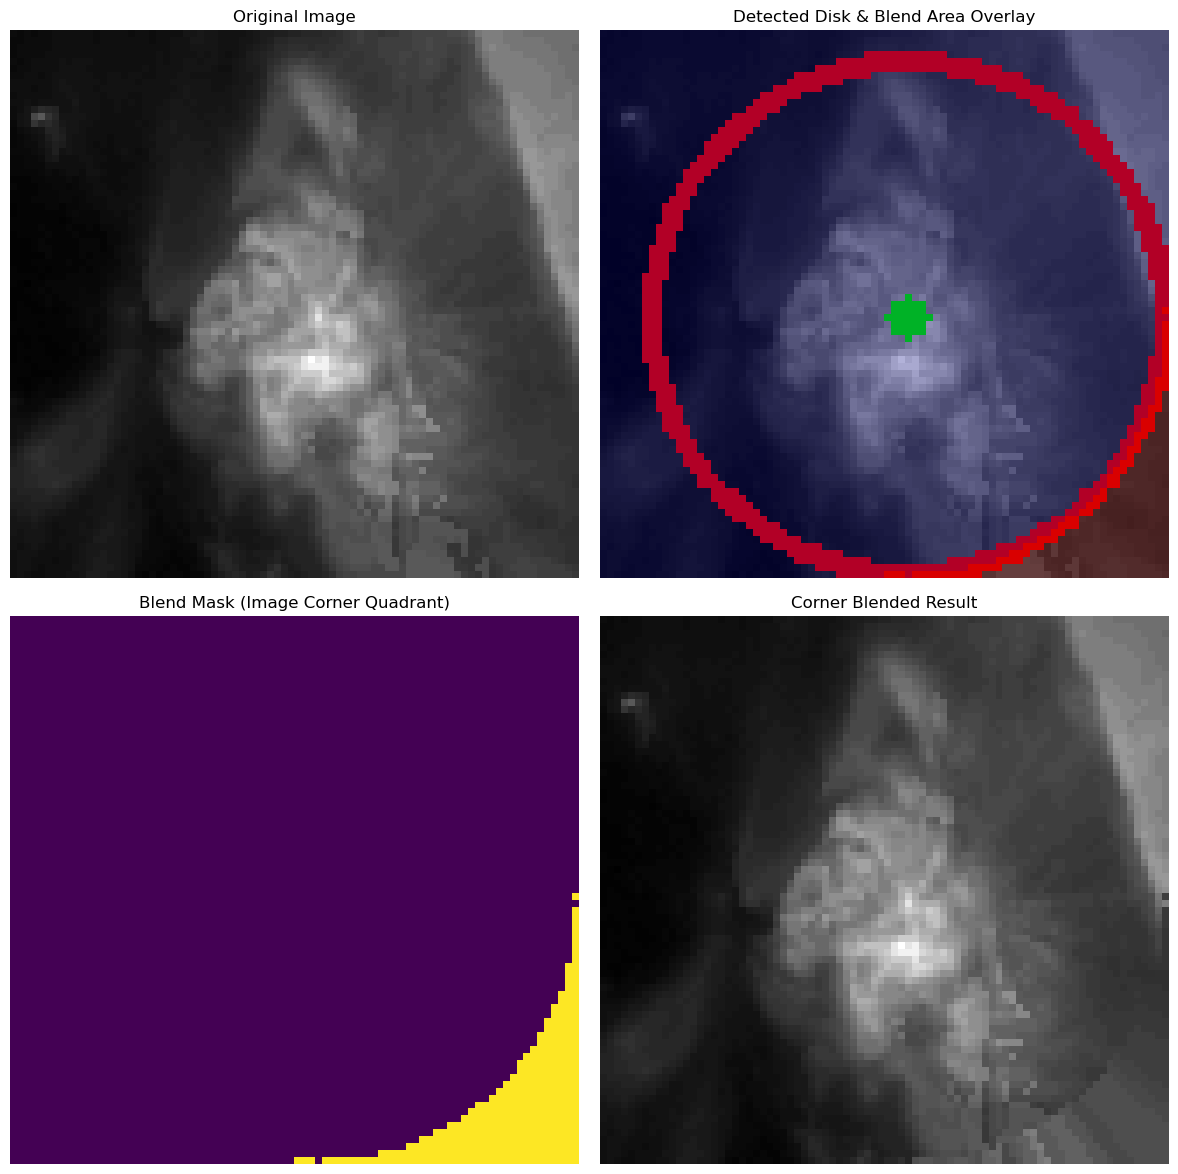


--- Processing: ../Solar_disk_hough_transformation/sample_images/20110808_190400_AR11263 copy.png ---
Detected solar disk at (47.00, 40.00) with radius 37.00
Circle is close to an edge. Determining target corner based on sum of gradient magnitudes.
  Quadrant top-left: Sum of gradients = 195830.00
  Quadrant top-right: Sum of gradients = 275120.00
  Quadrant bottom-left: Sum of gradients = 277174.00
  Quadrant bottom-right: Sum of gradients = 308018.00
Target corner based on max gradient sum: bottom-right (Sum: 308018.00)
Using sampling offset: 7
Blending 379 pixels in the bottom-right image quadrant...


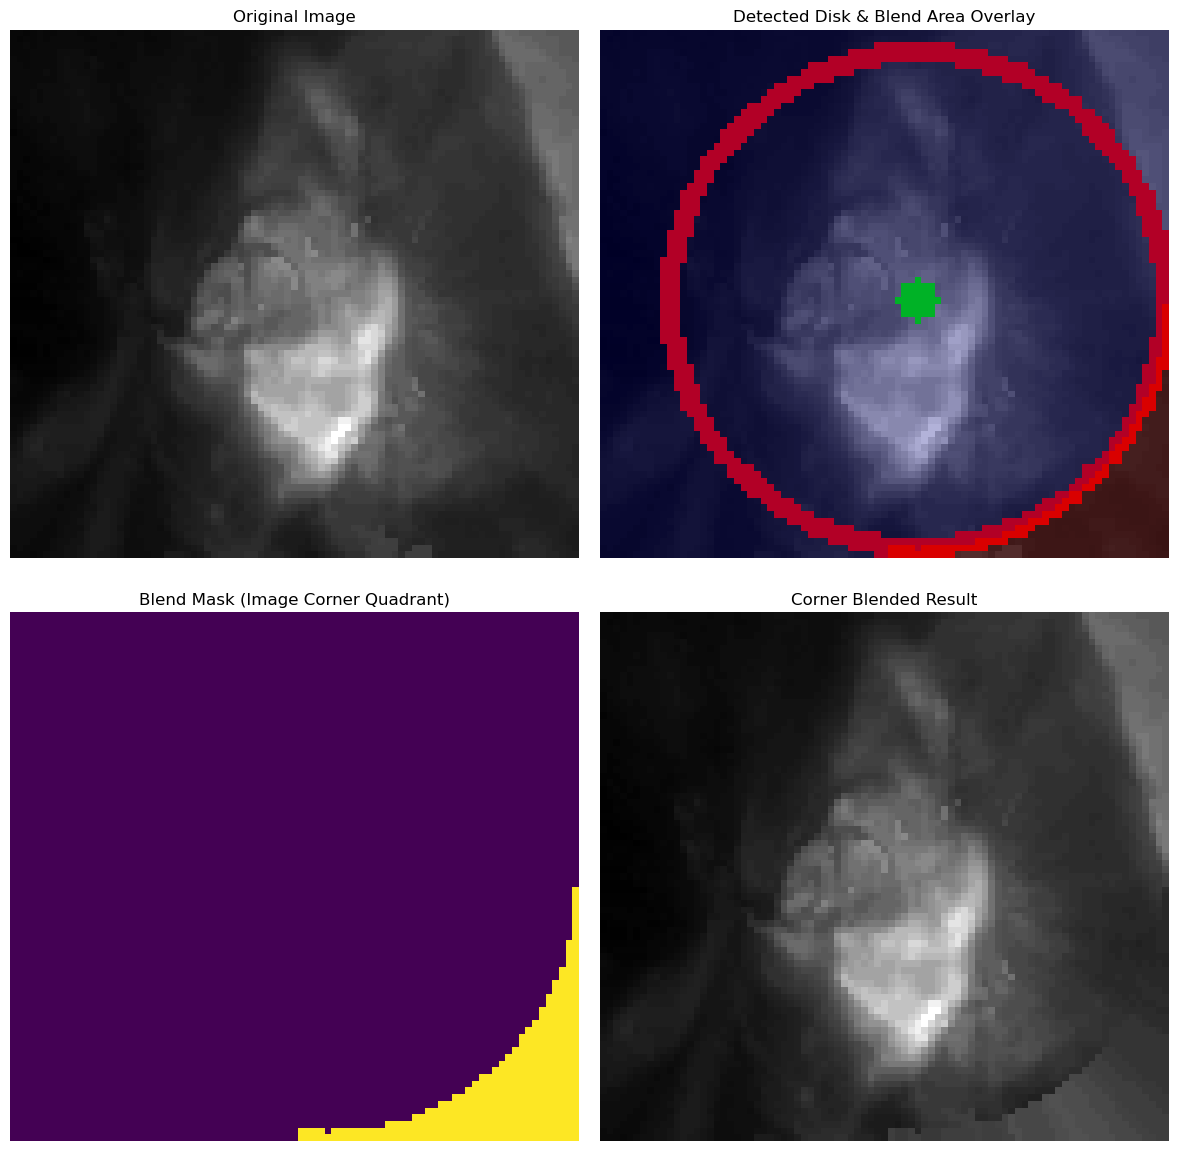


--- Processing: ../Solar_disk_hough_transformation/sample_images/20110109_175810_AR11140 copy.png ---
Detected solar disk at (109.00, 56.00) with radius 52.00
Circle is close to an edge. Determining target corner based on sum of gradient magnitudes.
  Quadrant top-left: Sum of gradients = 459808.00
  Quadrant top-right: Sum of gradients = 541755.00
  Quadrant bottom-left: Sum of gradients = 439189.00
  Quadrant bottom-right: Sum of gradients = 452194.00
Target corner based on max gradient sum: top-right (Sum: 541755.00)
Using sampling offset: 7
Blending 1089 pixels in the top-right image quadrant...


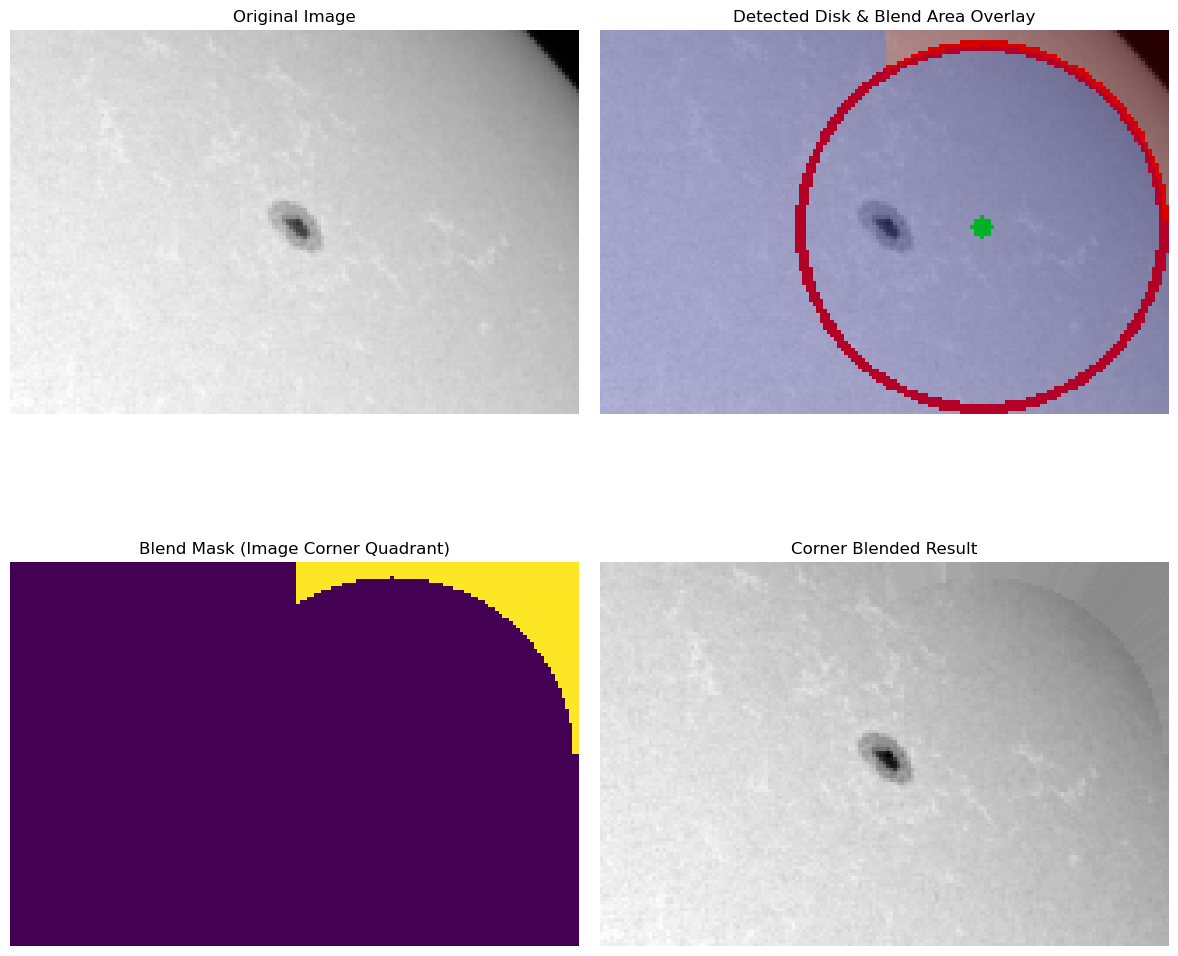


--- Processing: ../Solar_disk_hough_transformation/sample_images/20110809_060400_AR11263 copy.png ---
Detected solar disk at (34.00, 37.00) with radius 32.00
Circle is close to an edge. Determining target corner based on sum of gradient magnitudes.
  Quadrant top-left: Sum of gradients = 199293.00
  Quadrant top-right: Sum of gradients = 248991.00
  Quadrant bottom-left: Sum of gradients = 219595.00
  Quadrant bottom-right: Sum of gradients = 270829.00
Target corner based on max gradient sum: bottom-right (Sum: 270829.00)
Using sampling offset: 7
Blending 588 pixels in the bottom-right image quadrant...


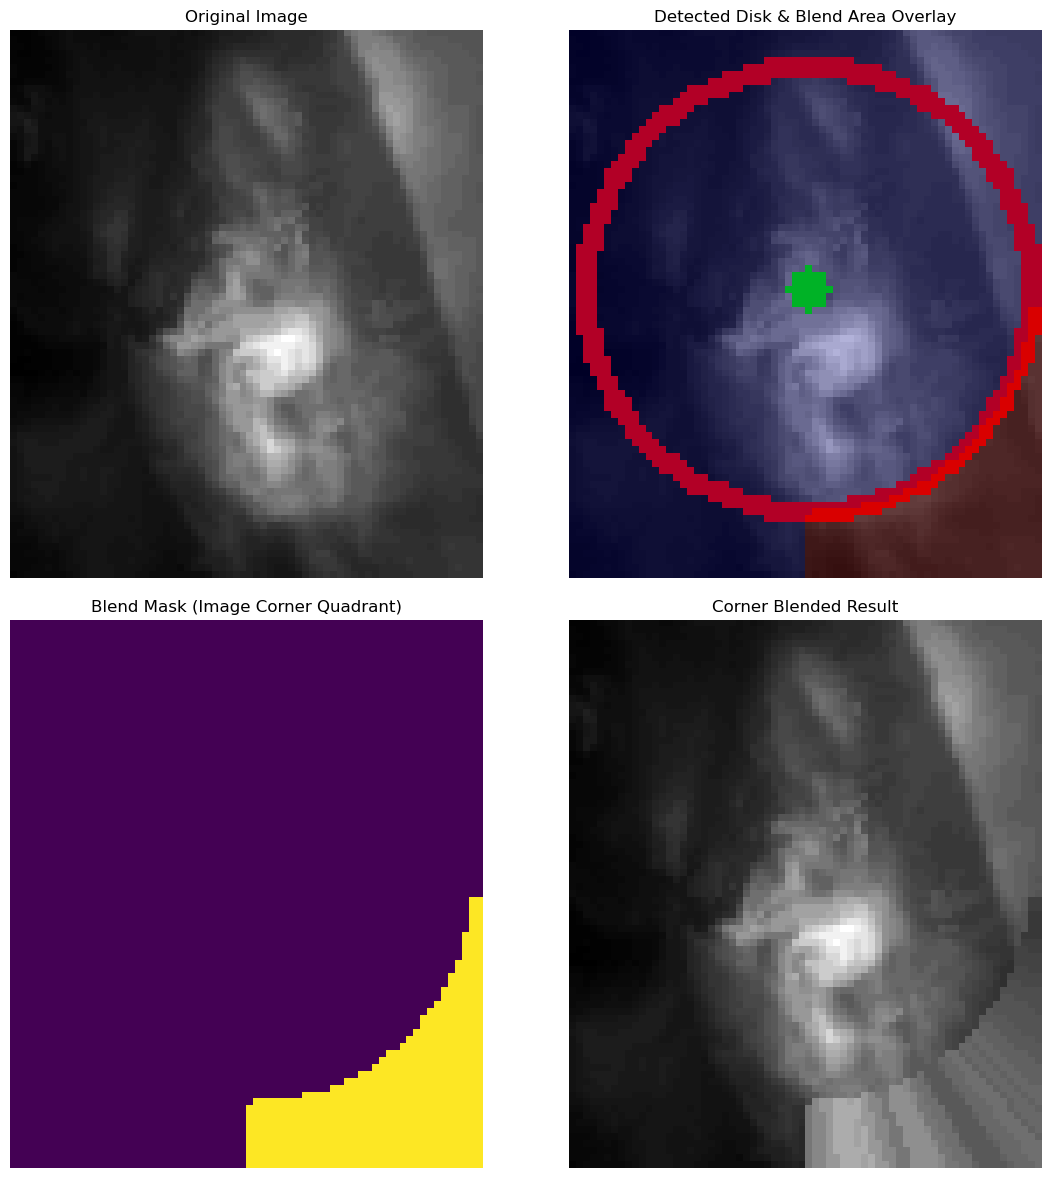


--- Processing: ../Solar_disk_hough_transformation/sample_images/20110110_065810_AR11140 copy_mirror_blended.png ---
Detected solar disk at (93.00, 55.00) with radius 54.00
Circle is close to an edge. Determining target corner based on sum of gradient magnitudes.
  Quadrant top-left: Sum of gradients = 448429.00
  Quadrant top-right: Sum of gradients = 598335.00
  Quadrant bottom-left: Sum of gradients = 435082.00
  Quadrant bottom-right: Sum of gradients = 466973.00
Target corner based on max gradient sum: top-right (Sum: 598335.00)
Using sampling offset: 7
Blending 1007 pixels in the top-right image quadrant...


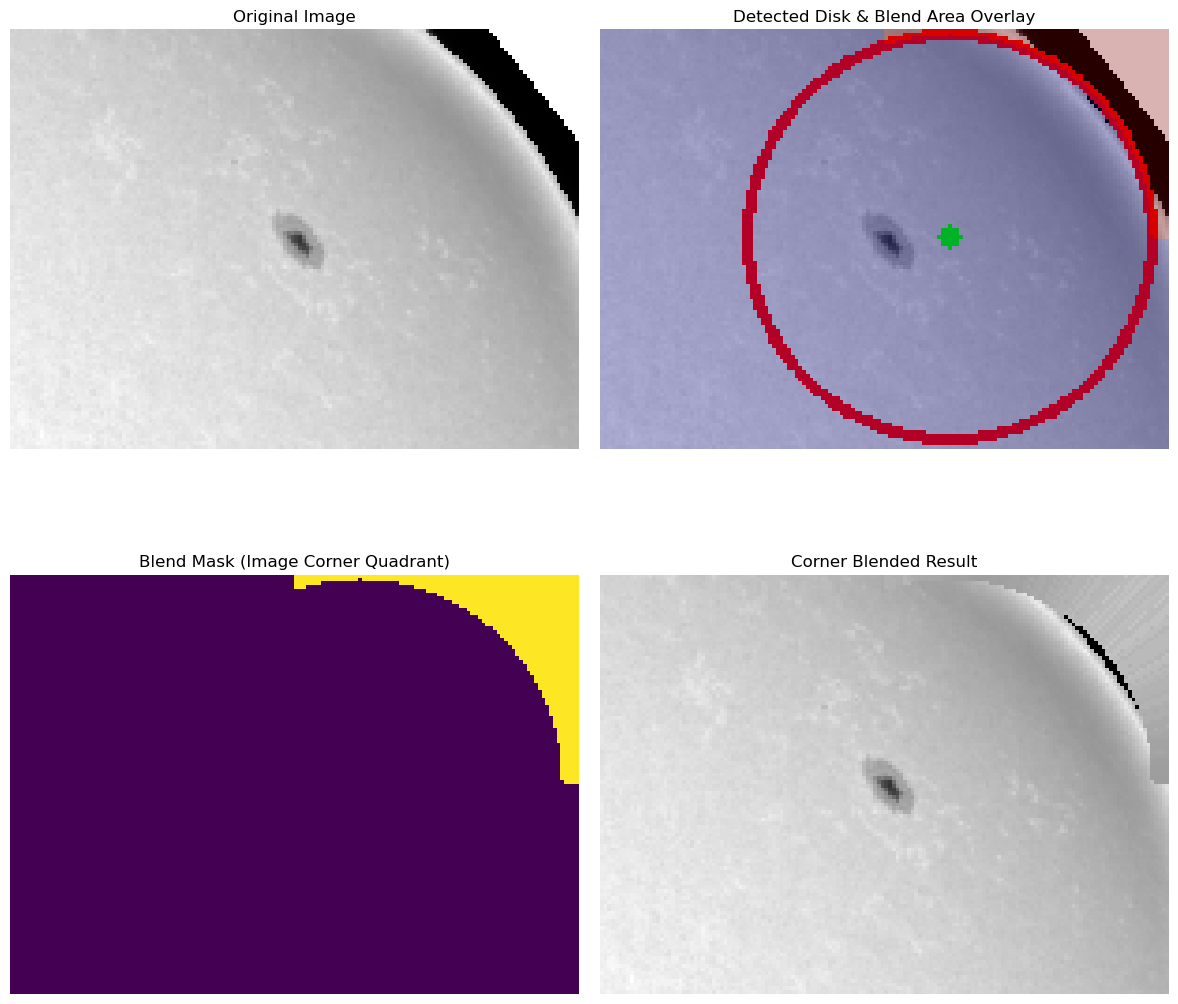


--- Processing: ../Solar_disk_hough_transformation/sample_images/20110110_085810_AR11140 copy.png ---
Detected solar disk at (68.00, 55.00) with radius 54.00
Circle is close to an edge. Determining target corner based on sum of gradient magnitudes.
  Quadrant top-left: Sum of gradients = 989227.00
  Quadrant top-right: Sum of gradients = 915422.00
  Quadrant bottom-left: Sum of gradients = 989495.00
  Quadrant bottom-right: Sum of gradients = 986989.00
Target corner based on max gradient sum: bottom-left (Sum: 989495.00)
Using sampling offset: 7
Blending 1596 pixels in the bottom-left image quadrant...


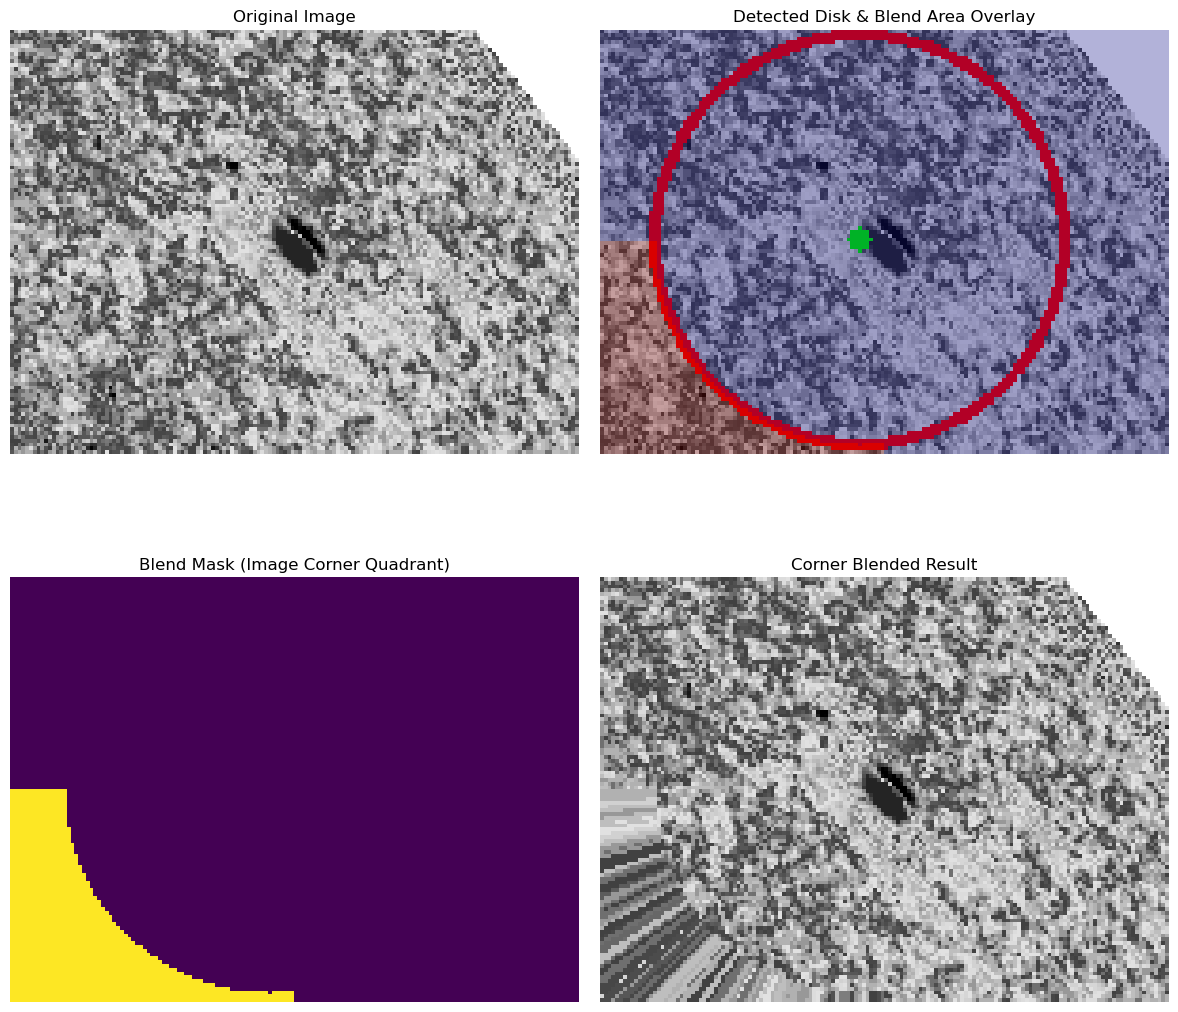


--- Processing: ../Solar_disk_hough_transformation/sample_images/20130104_030500_AR11639 copy.png ---
Detected solar disk at (70.00, 39.00) with radius 37.00
Circle is close to an edge. Determining target corner based on sum of gradient magnitudes.
  Quadrant top-left: Sum of gradients = 781314.00
  Quadrant top-right: Sum of gradients = 809718.00
  Quadrant bottom-left: Sum of gradients = 797273.00
  Quadrant bottom-right: Sum of gradients = 801055.00
Target corner based on max gradient sum: top-right (Sum: 809718.00)
Using sampling offset: 7
Blending 4368 pixels in the top-right image quadrant...


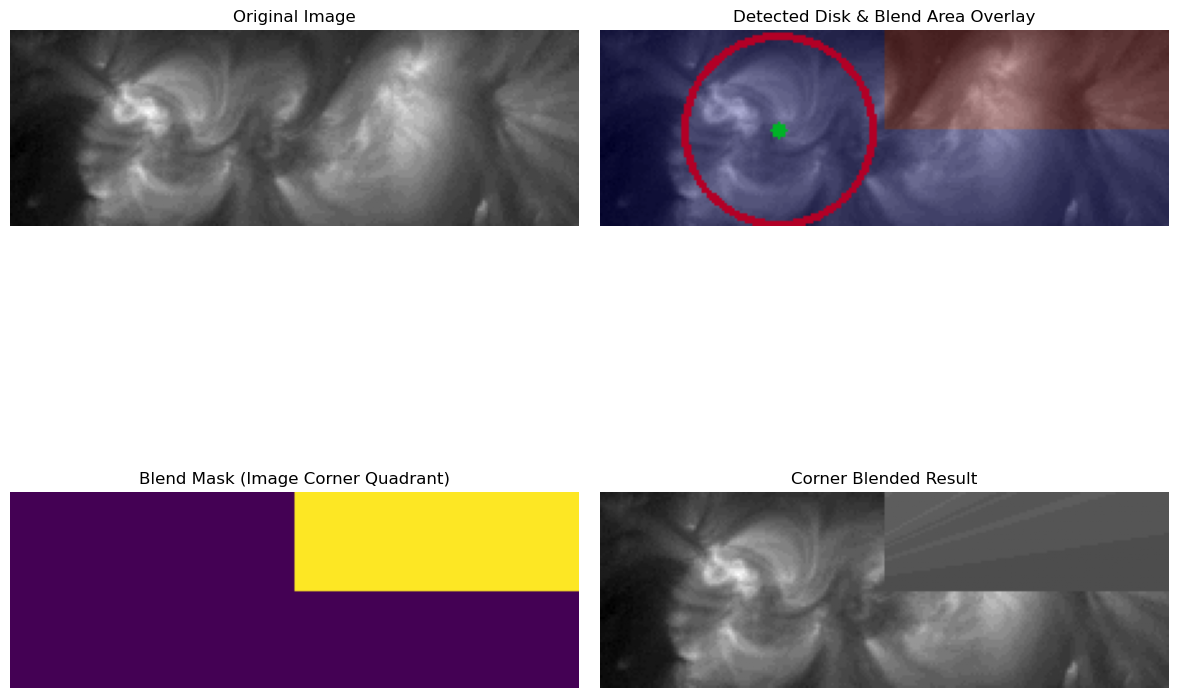


--- Processing: ../Solar_disk_hough_transformation/sample_images/20110110_025810_AR11140 copy.png ---
Detected solar disk at (74.00, 55.00) with radius 54.00
Circle is close to an edge. Determining target corner based on sum of gradient magnitudes.
  Quadrant top-left: Sum of gradients = 1031949.00
  Quadrant top-right: Sum of gradients = 1009055.00
  Quadrant bottom-left: Sum of gradients = 1032032.00
  Quadrant bottom-right: Sum of gradients = 1018256.00
Target corner based on max gradient sum: bottom-left (Sum: 1032032.00)
Using sampling offset: 7
Blending 1923 pixels in the bottom-left image quadrant...


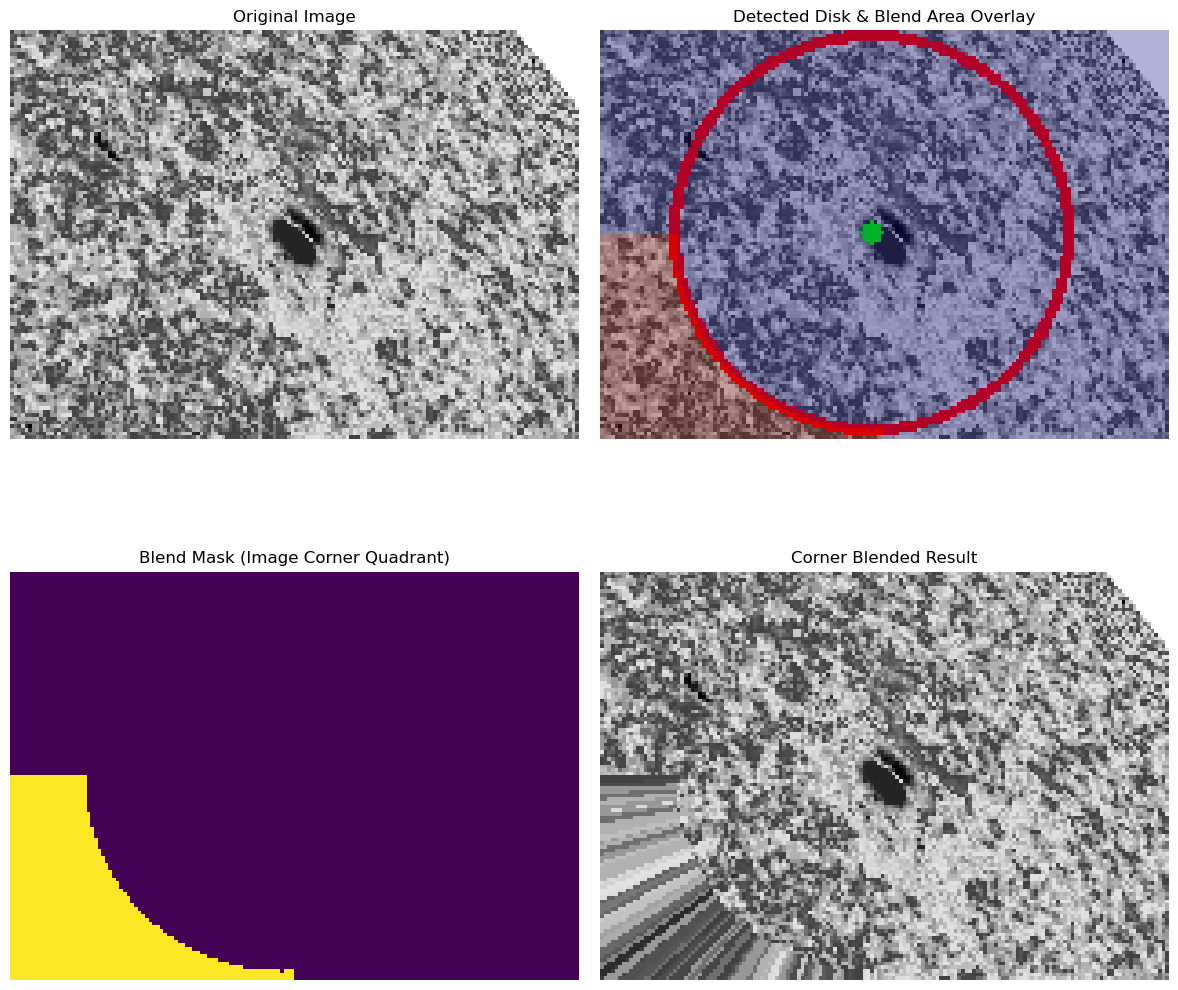


--- Processing: ../Solar_disk_hough_transformation/sample_images/20110925_020500_AR11302 copy.png ---
Detected solar disk at (106.00, 62.00) with radius 62.00
Circle is close to an edge. Determining target corner based on sum of gradient magnitudes.
  Quadrant top-left: Sum of gradients = 749159.00
  Quadrant top-right: Sum of gradients = 716480.00
  Quadrant bottom-left: Sum of gradients = 965363.00
  Quadrant bottom-right: Sum of gradients = 710662.00
Target corner based on max gradient sum: bottom-left (Sum: 965363.00)
Using sampling offset: 7
Blending 3591 pixels in the bottom-left image quadrant...


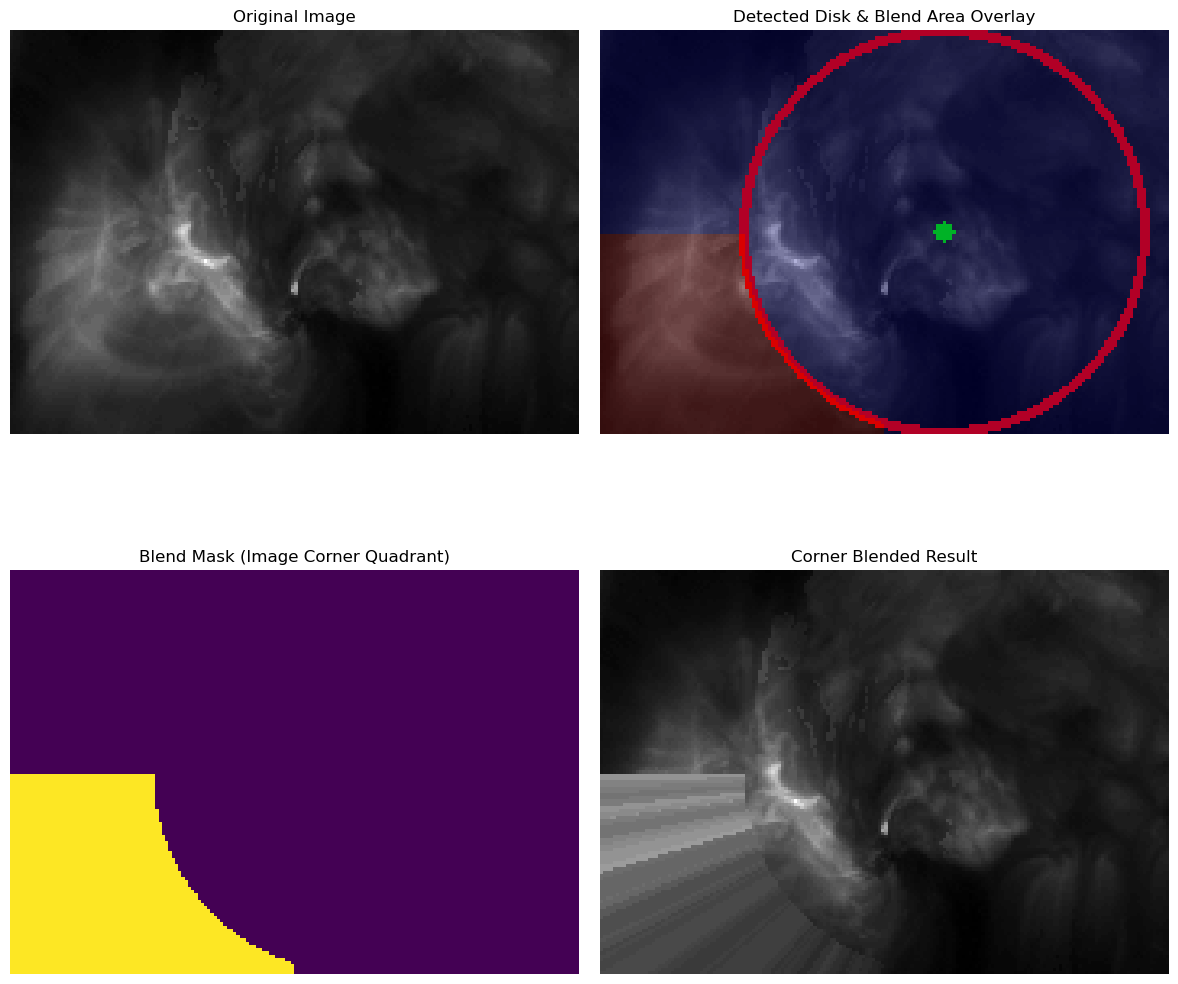


--- Processing: ../Solar_disk_hough_transformation/sample_images/20110808_235825_AR11263 copy.png ---
Detected solar disk at (45.00, 46.00) with radius 45.00
Circle is close to an edge. Determining target corner based on sum of gradient magnitudes.
  Quadrant top-left: Sum of gradients = 509118.00
  Quadrant top-right: Sum of gradients = 502655.00
  Quadrant bottom-left: Sum of gradients = 506366.00
  Quadrant bottom-right: Sum of gradients = 506099.00
Target corner based on max gradient sum: top-left (Sum: 509118.00)
Using sampling offset: 7
Blending 526 pixels in the top-left image quadrant...


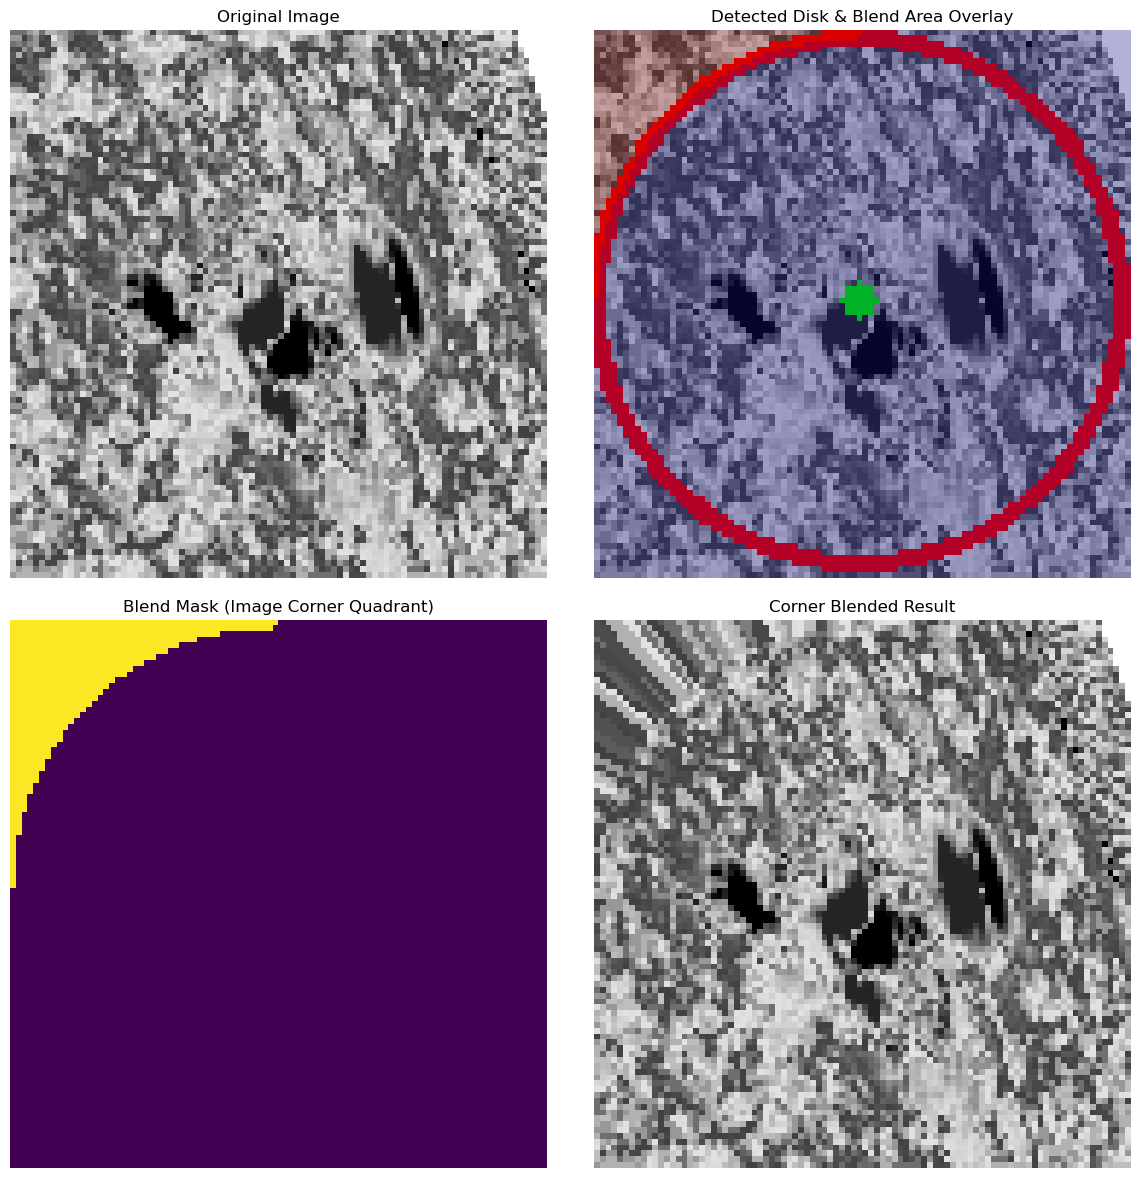


--- Processing: ../Solar_disk_hough_transformation/sample_images/20110306_165814_AR11165 copy.png ---
Detected solar disk at (59.00, 71.00) with radius 59.00
Circle is close to an edge. Determining target corner based on sum of gradient magnitudes.
  Quadrant top-left: Sum of gradients = 907200.00
  Quadrant top-right: Sum of gradients = 918166.00
  Quadrant bottom-left: Sum of gradients = 916725.00
  Quadrant bottom-right: Sum of gradients = 927732.00
Target corner based on max gradient sum: bottom-right (Sum: 927732.00)
Using sampling offset: 7
Blending 817 pixels in the bottom-right image quadrant...


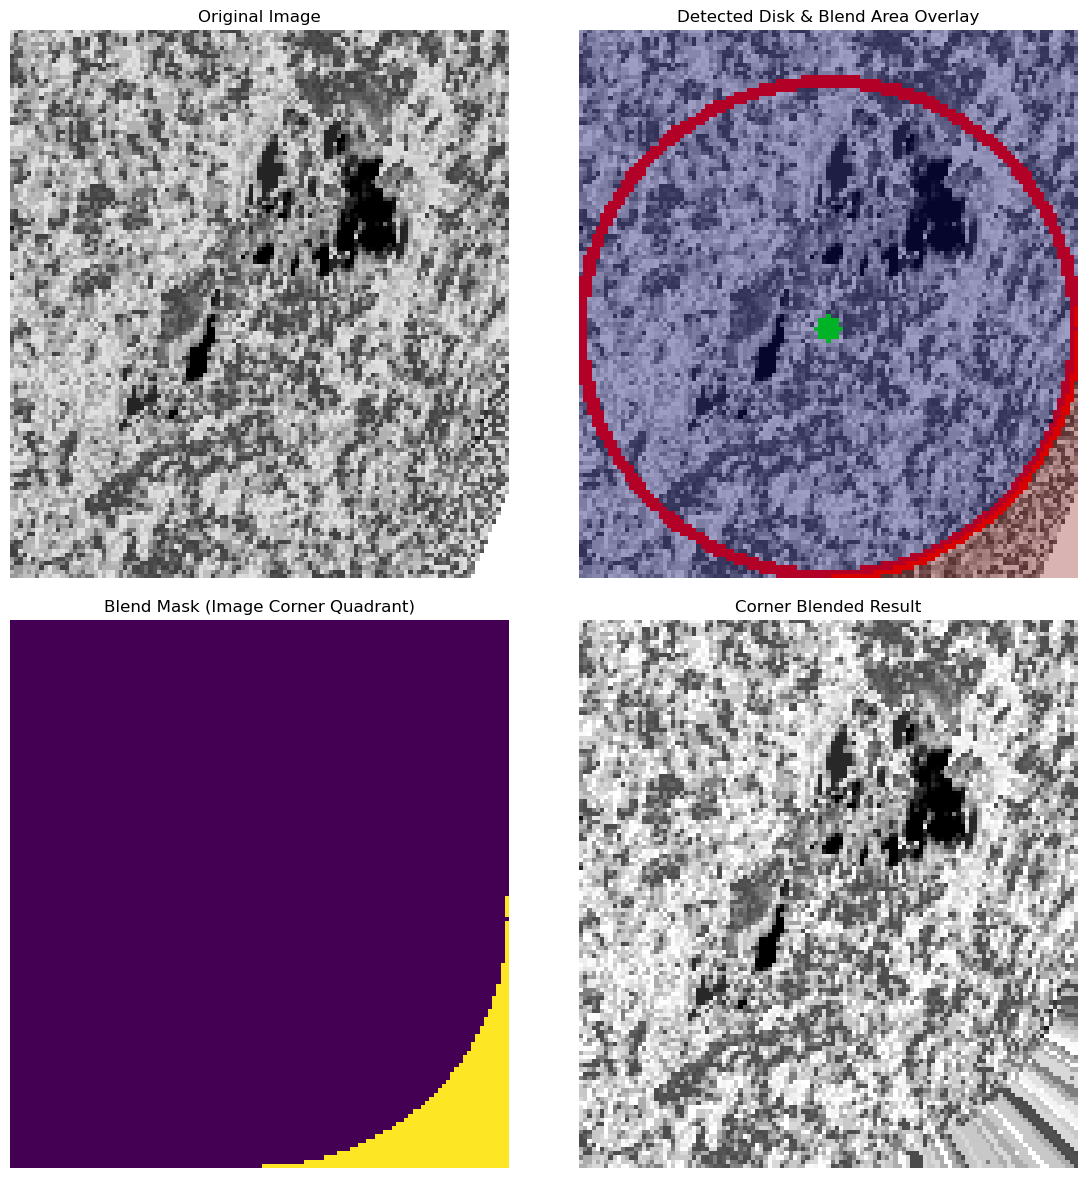


--- Processing: ../Solar_disk_hough_transformation/sample_images/20110110_065810_AR11140 copy.png ---
Detected solar disk at (93.00, 55.00) with radius 54.00
Circle is close to an edge. Determining target corner based on sum of gradient magnitudes.
  Quadrant top-left: Sum of gradients = 448429.00
  Quadrant top-right: Sum of gradients = 612995.00
  Quadrant bottom-left: Sum of gradients = 435082.00
  Quadrant bottom-right: Sum of gradients = 478581.00
Target corner based on max gradient sum: top-right (Sum: 612995.00)
Using sampling offset: 7
Blending 1007 pixels in the top-right image quadrant...


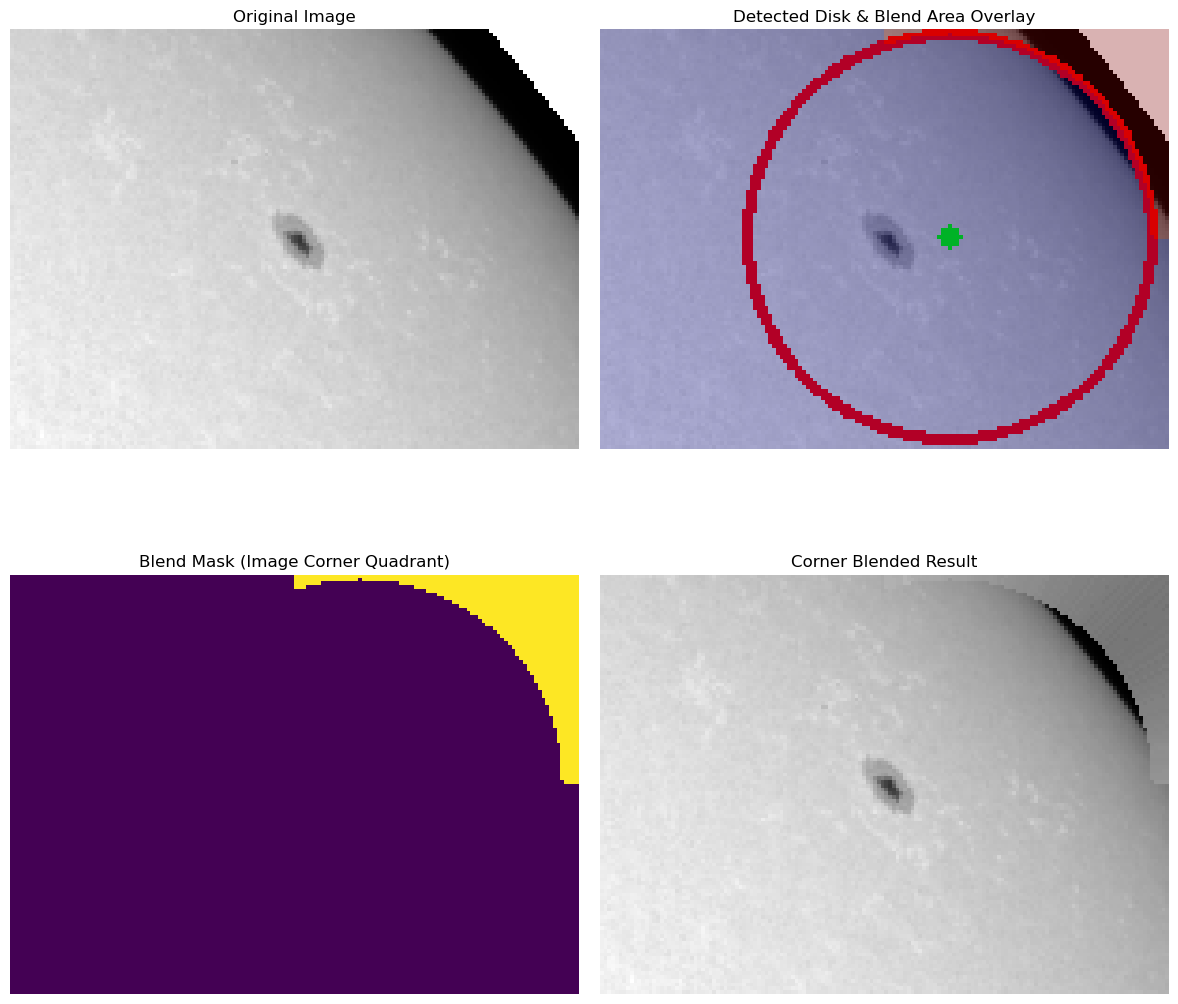


--- Processing: ../Solar_disk_hough_transformation/sample_images/20110109_190500_AR11140 copy.png ---
Detected solar disk at (66.00, 46.00) with radius 46.00
Circle is close to an edge. Determining target corner based on sum of gradient magnitudes.
  Quadrant top-left: Sum of gradients = 642378.00
  Quadrant top-right: Sum of gradients = 512874.00
  Quadrant bottom-left: Sum of gradients = 564917.00
  Quadrant bottom-right: Sum of gradients = 492489.00
Target corner based on max gradient sum: top-left (Sum: 642378.00)
Using sampling offset: 7
Blending 1448 pixels in the top-left image quadrant...


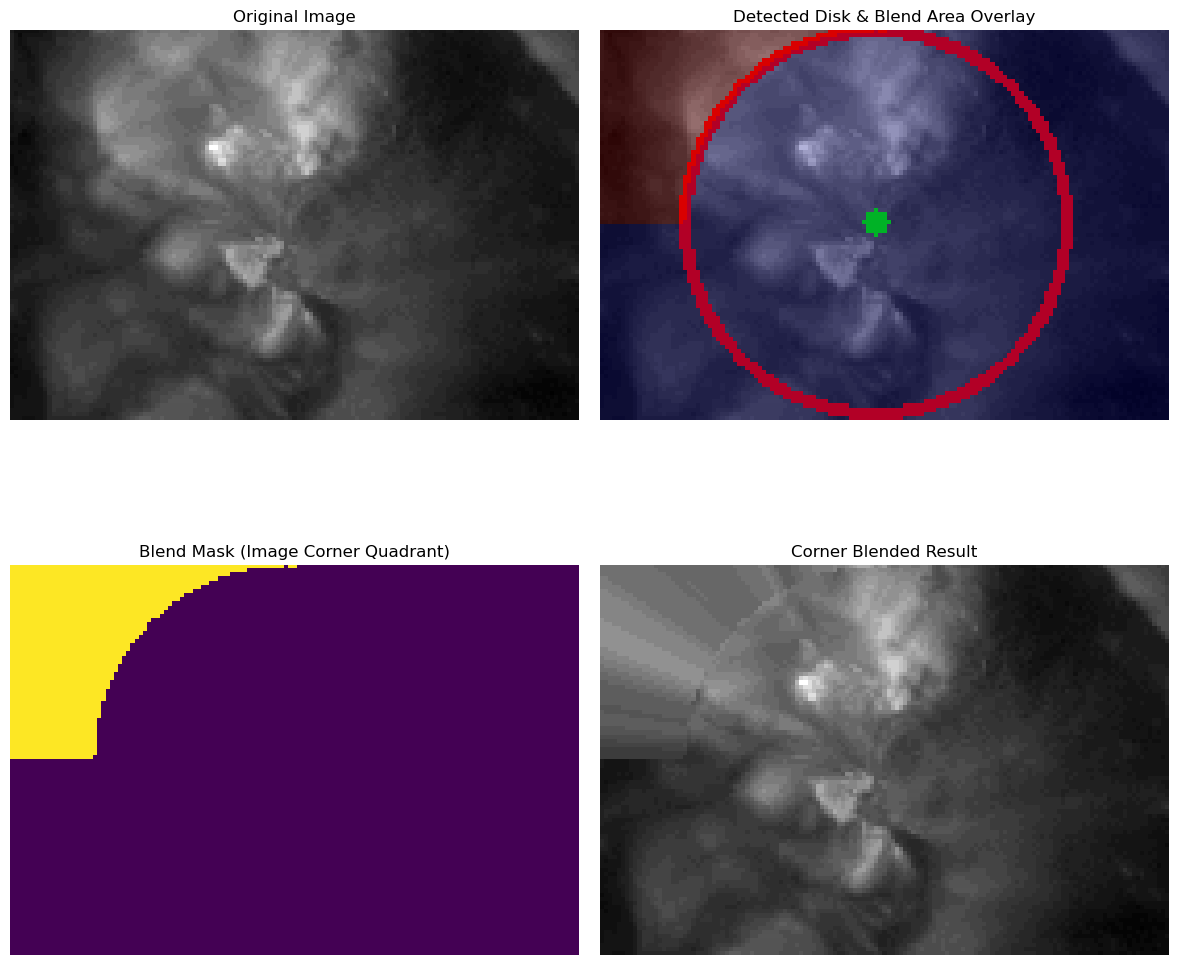


--- Processing: ../Solar_disk_hough_transformation/sample_images/20110110_035810_AR11140 copy.png ---
Detected solar disk at (99.00, 56.00) with radius 54.00
Circle is close to an edge. Determining target corner based on sum of gradient magnitudes.
  Quadrant top-left: Sum of gradients = 465714.00
  Quadrant top-right: Sum of gradients = 620538.00
  Quadrant bottom-left: Sum of gradients = 425705.00
  Quadrant bottom-right: Sum of gradients = 462768.00
Target corner based on max gradient sum: top-right (Sum: 620538.00)
Using sampling offset: 7
Blending 936 pixels in the top-right image quadrant...


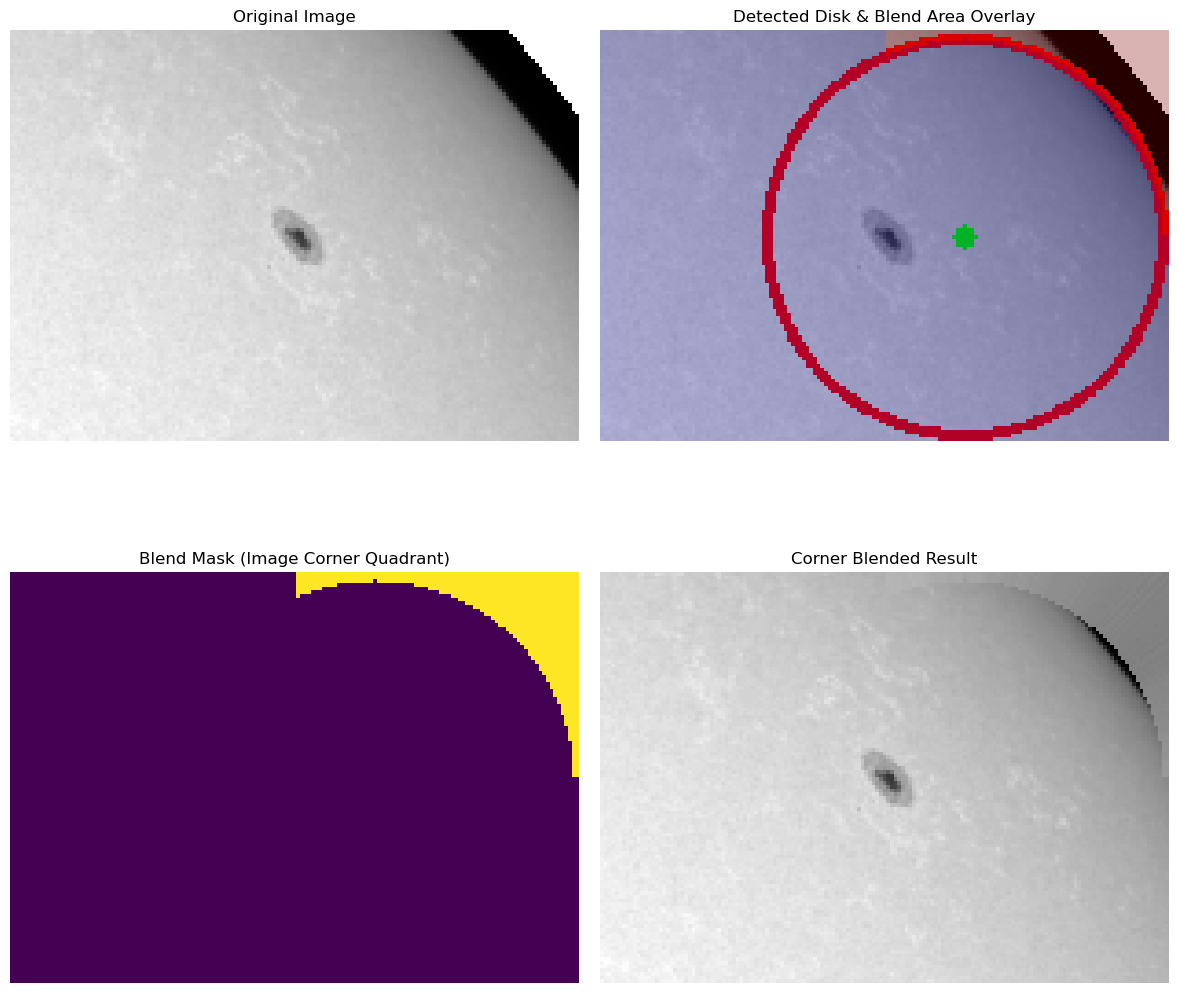


--- Processing: ../Solar_disk_hough_transformation/sample_images/20110307_065814_AR11165 copy.png ---
Detected solar disk at (48.00, 48.00) with radius 44.00
Circle is close to an edge. Determining target corner based on sum of gradient magnitudes.
  Quadrant top-left: Sum of gradients = 299186.00
  Quadrant top-right: Sum of gradients = 535105.00
  Quadrant bottom-left: Sum of gradients = 395294.00
  Quadrant bottom-right: Sum of gradients = 463850.00
Target corner based on max gradient sum: top-right (Sum: 535105.00)
Using sampling offset: 7
Blending 870 pixels in the top-right image quadrant...


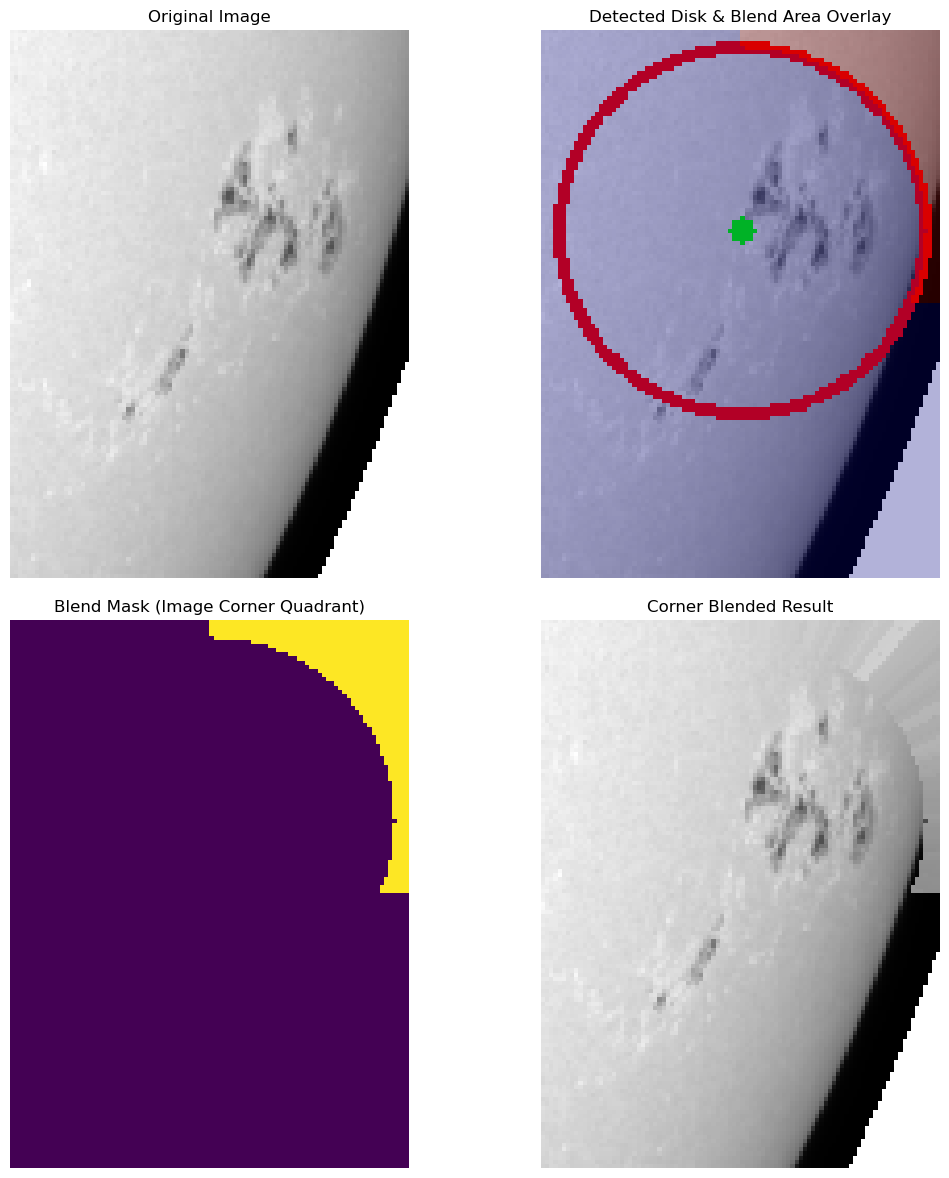


--- Processing: ../Solar_disk_hough_transformation/sample_images/20110809_045825_AR11263 copy.png ---
Detected solar disk at (41.00, 50.00) with radius 40.00
Circle is close to an edge. Determining target corner based on sum of gradient magnitudes.
  Quadrant top-left: Sum of gradients = 243643.00
  Quadrant top-right: Sum of gradients = 343131.00
  Quadrant bottom-left: Sum of gradients = 212678.00
  Quadrant bottom-right: Sum of gradients = 342993.00
Target corner based on max gradient sum: top-right (Sum: 343131.00)
Using sampling offset: 7
Blending 828 pixels in the top-right image quadrant...


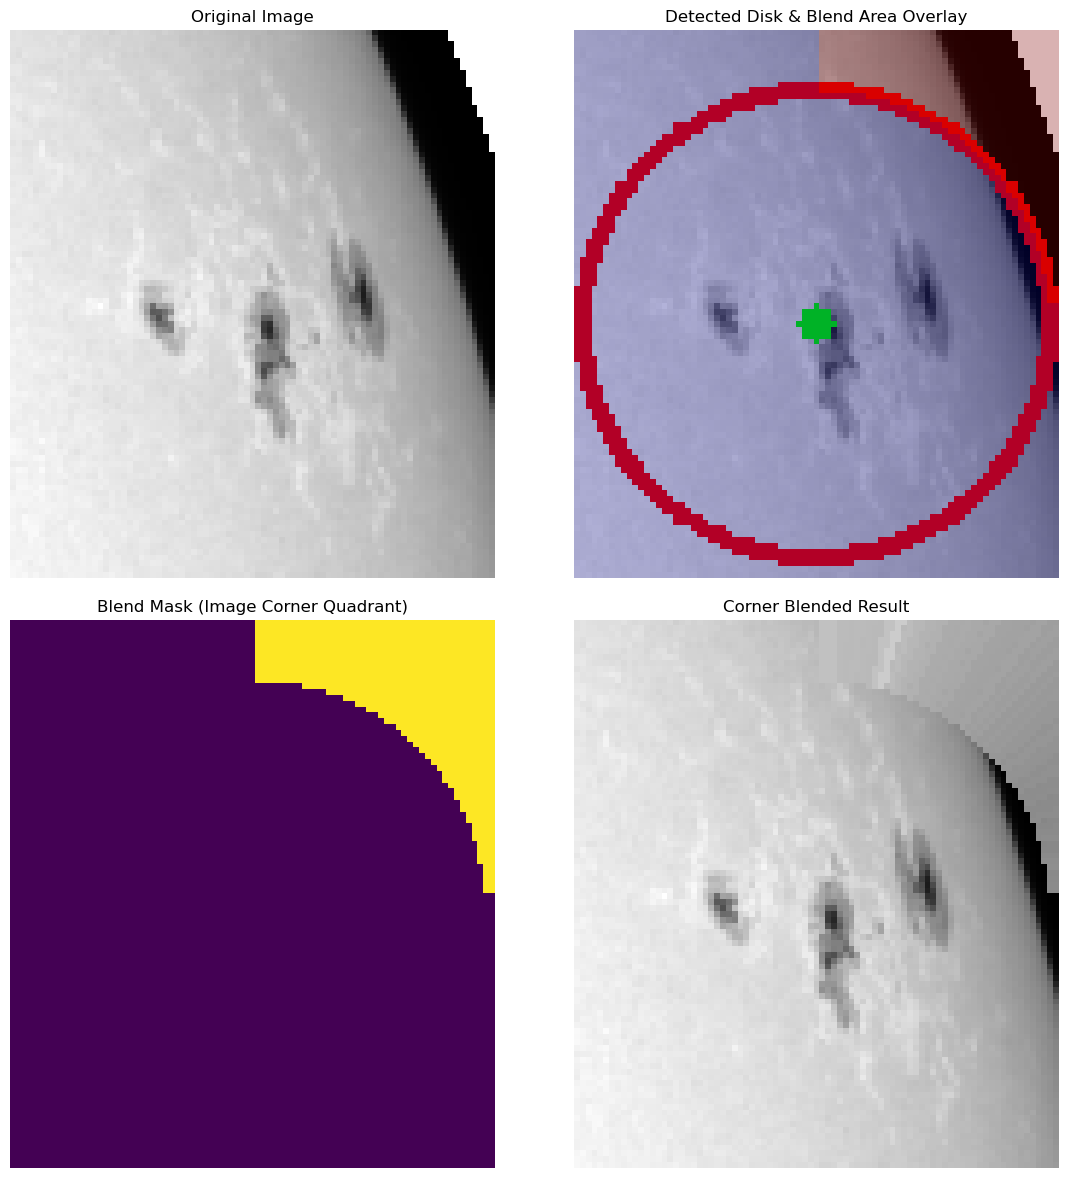


--- Processing: ../Solar_disk_hough_transformation/sample_images/20110924_085820_AR11302 copy.png ---
Detected solar disk at (100.00, 75.00) with radius 74.00
Circle is close to an edge. Determining target corner based on sum of gradient magnitudes.
  Quadrant top-left: Sum of gradients = 776156.00
  Quadrant top-right: Sum of gradients = 641407.00
  Quadrant bottom-left: Sum of gradients = 842722.00
  Quadrant bottom-right: Sum of gradients = 679505.00
Target corner based on max gradient sum: bottom-left (Sum: 842722.00)
Using sampling offset: 7
Blending 3190 pixels in the bottom-left image quadrant...


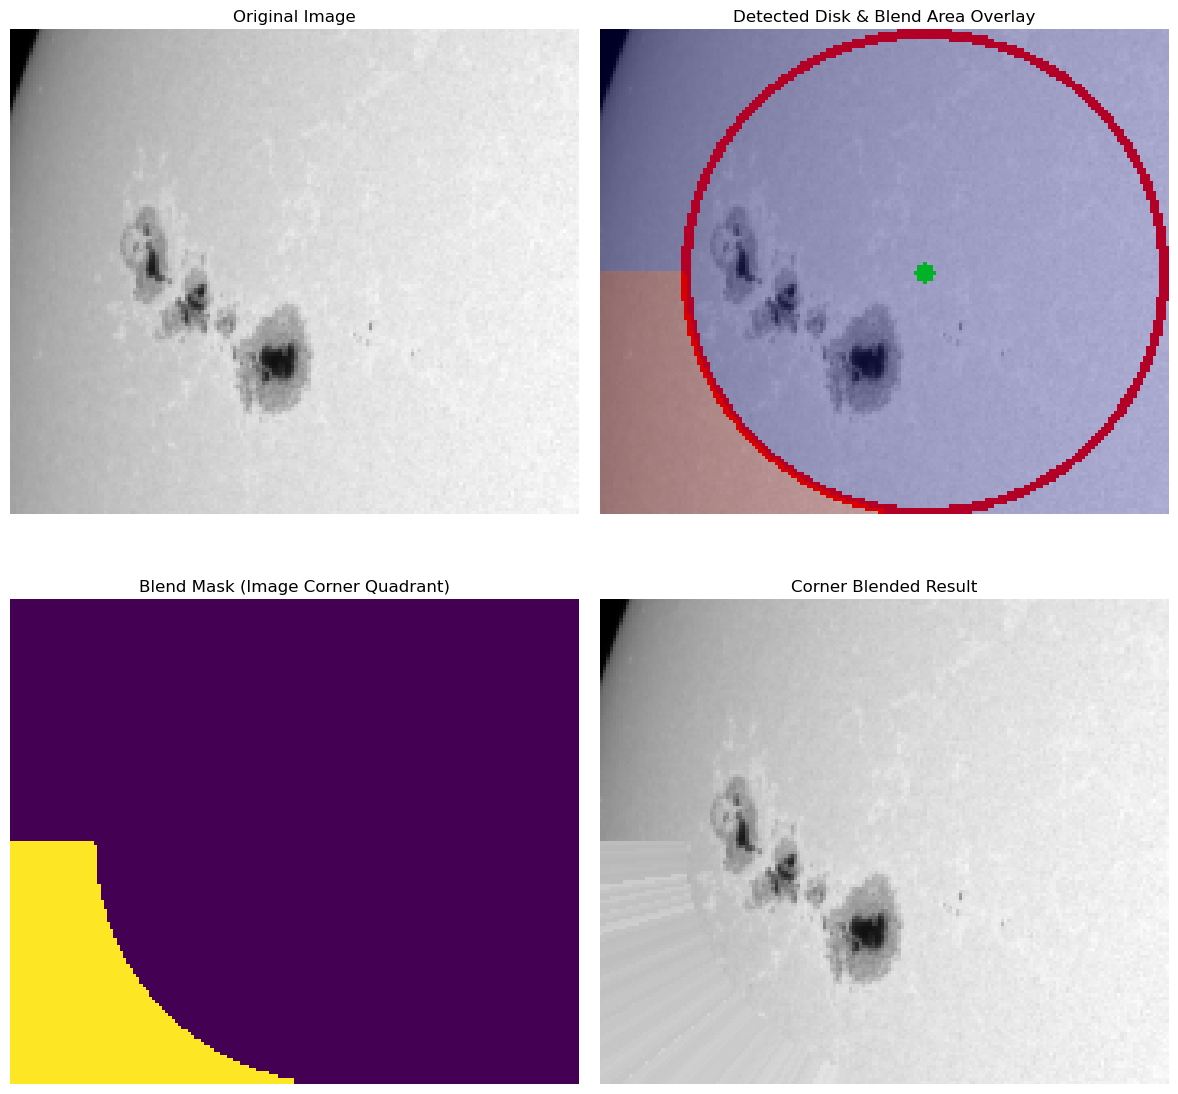


--- Processing: ../Solar_disk_hough_transformation/sample_images/20110307_055814_AR11165 copy.png ---
Detected solar disk at (48.00, 63.00) with radius 48.00
Circle is close to an edge. Determining target corner based on sum of gradient magnitudes.
  Quadrant top-left: Sum of gradients = 762955.00
  Quadrant top-right: Sum of gradients = 756040.00
  Quadrant bottom-left: Sum of gradients = 762044.00
  Quadrant bottom-right: Sum of gradients = 670174.00
Target corner based on max gradient sum: top-left (Sum: 762955.00)
Using sampling offset: 7
Blending 1286 pixels in the top-left image quadrant...


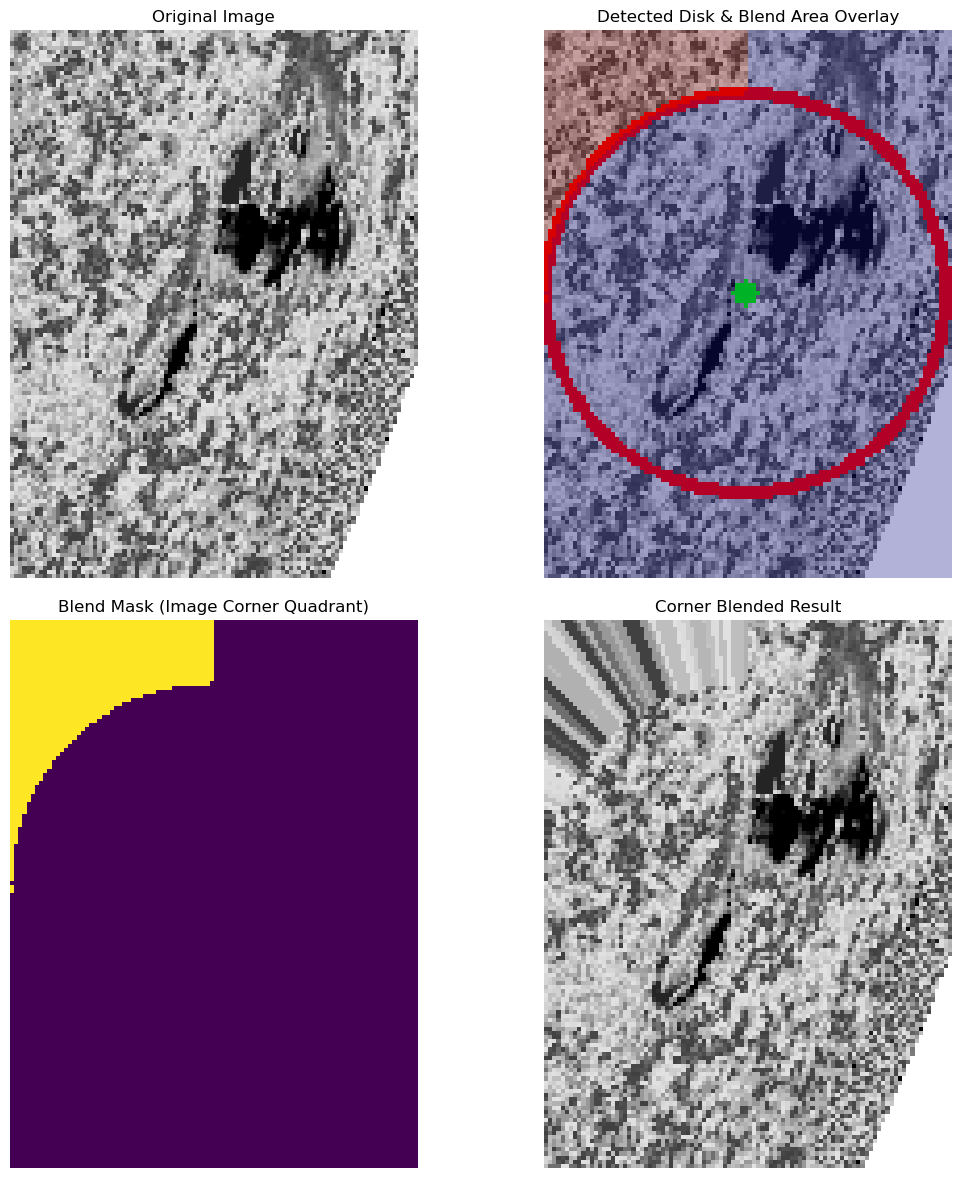


--- Processing: ../Solar_disk_hough_transformation/sample_images/20110110_060400_AR11140 copy.png ---
Detected solar disk at (74.00, 46.00) with radius 46.00
Circle is close to an edge. Determining target corner based on sum of gradient magnitudes.
  Quadrant top-left: Sum of gradients = 558272.00
  Quadrant top-right: Sum of gradients = 497300.00
  Quadrant bottom-left: Sum of gradients = 502164.00
  Quadrant bottom-right: Sum of gradients = 418106.00
Target corner based on max gradient sum: top-left (Sum: 558272.00)
Using sampling offset: 7
Blending 1813 pixels in the top-left image quadrant...


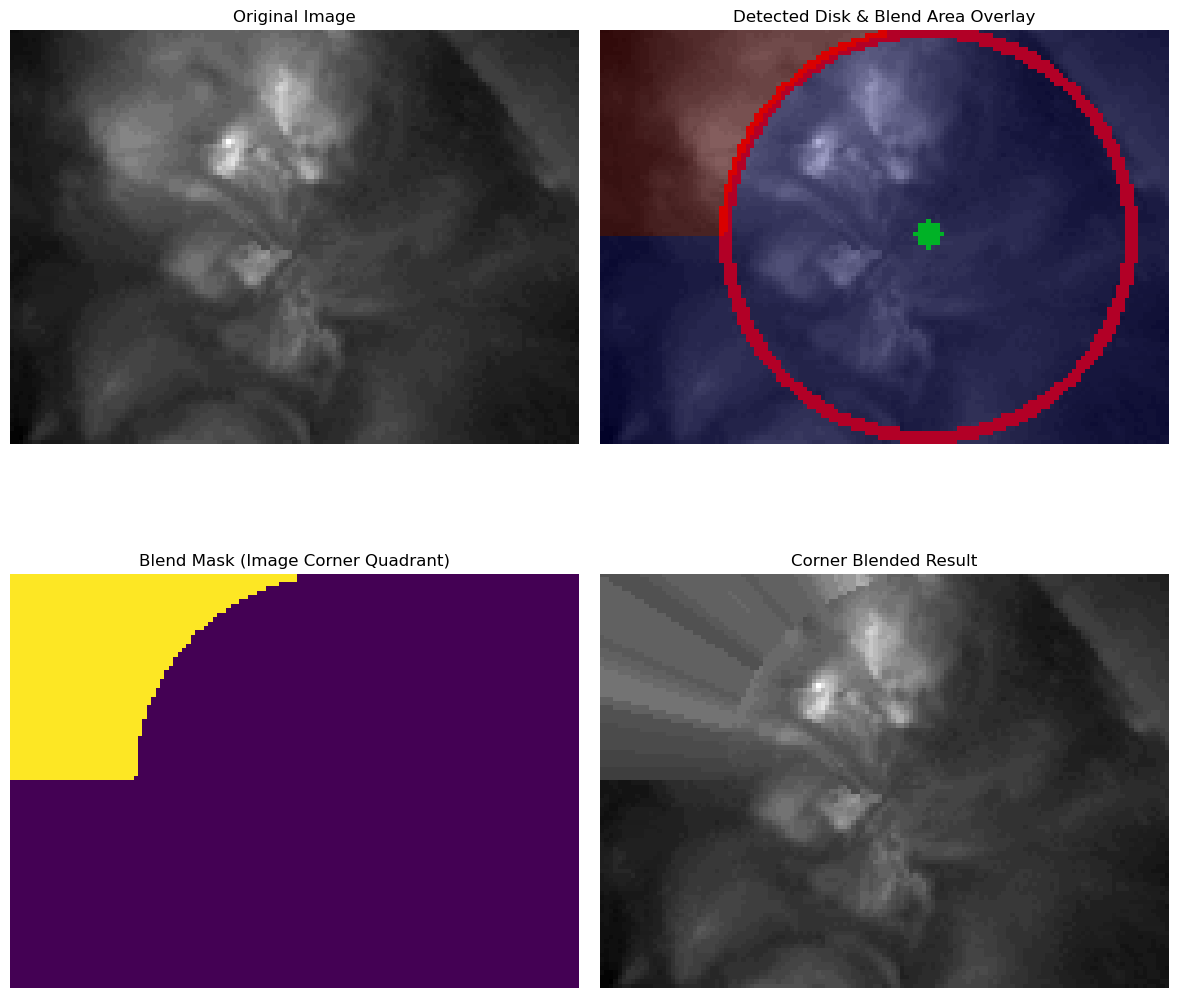


--- Processing: ../Solar_disk_hough_transformation/sample_images/20110803_080500_AR11261 copy.png ---
Detected solar disk at (92.00, 51.00) with radius 49.00
Circle is close to an edge. Determining target corner based on sum of gradient magnitudes.
  Quadrant top-left: Sum of gradients = 354560.00
  Quadrant top-right: Sum of gradients = 453656.00
  Quadrant bottom-left: Sum of gradients = 311035.00
  Quadrant bottom-right: Sum of gradients = 495540.00
Target corner based on max gradient sum: bottom-right (Sum: 495540.00)
Using sampling offset: 7
Blending 1961 pixels in the bottom-right image quadrant...


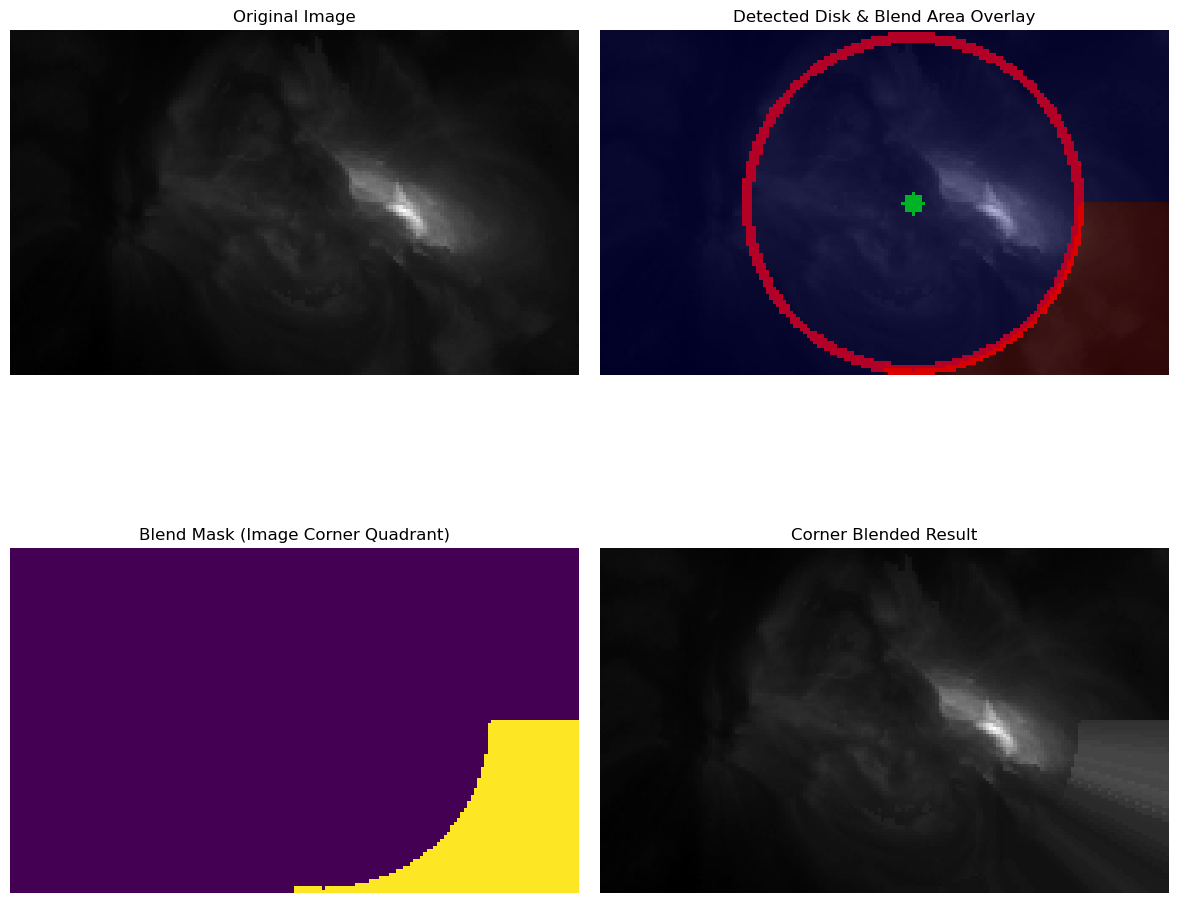


--- Processing: ../Solar_disk_hough_transformation/sample_images/20110306_105814_AR11165 copy.png ---
Detected solar disk at (65.00, 66.00) with radius 61.00
Circle is close to an edge. Determining target corner based on sum of gradient magnitudes.
  Quadrant top-left: Sum of gradients = 381802.00
  Quadrant top-right: Sum of gradients = 546761.00
  Quadrant bottom-left: Sum of gradients = 454859.00
  Quadrant bottom-right: Sum of gradients = 532976.00
Target corner based on max gradient sum: top-right (Sum: 546761.00)
Using sampling offset: 7
Blending 1304 pixels in the top-right image quadrant...


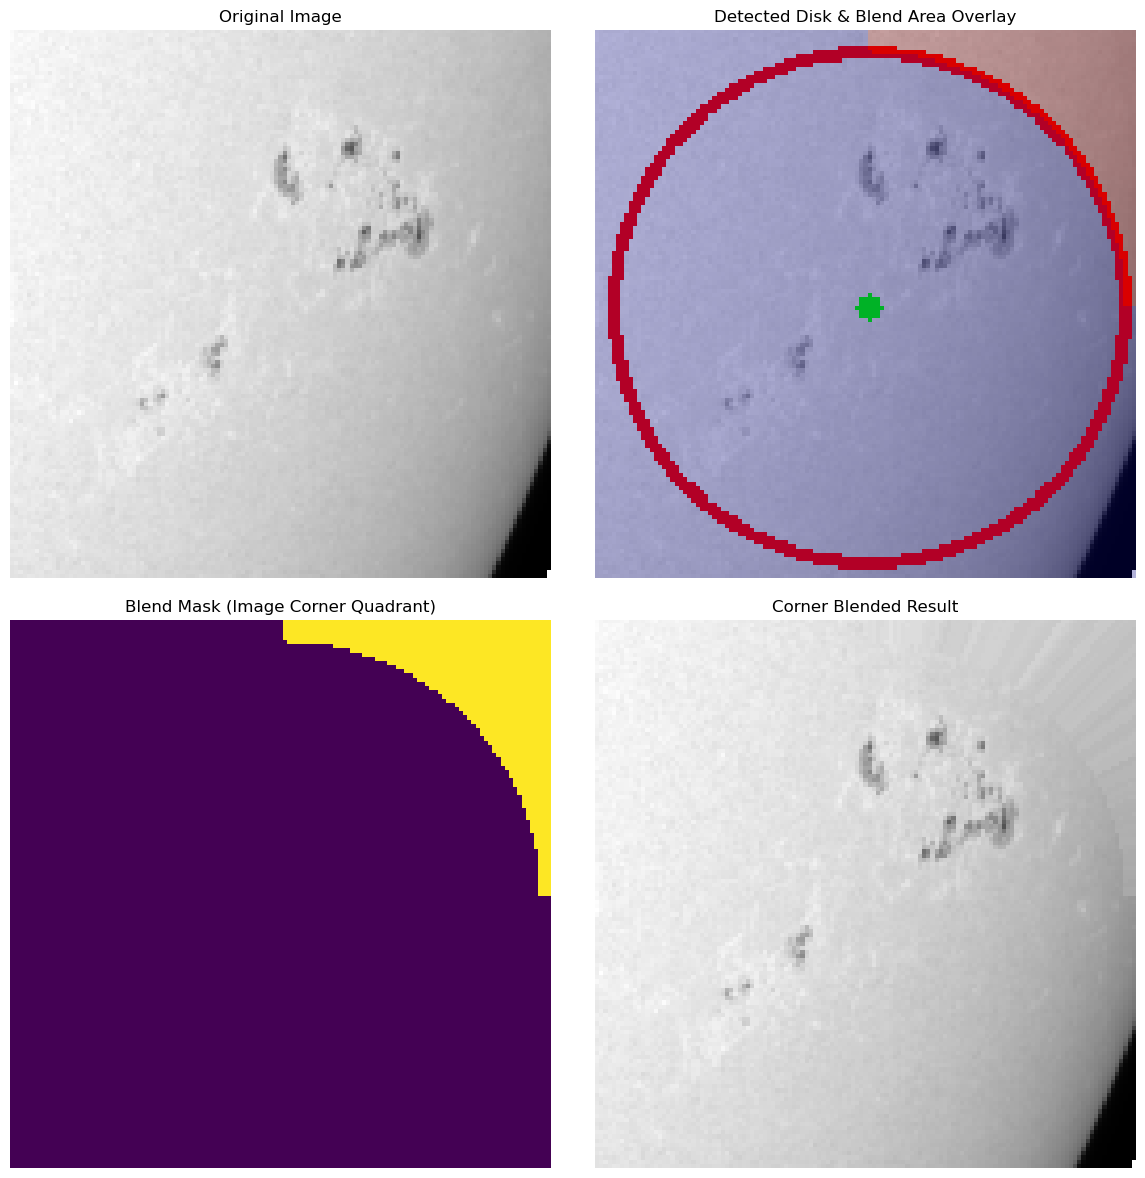


--- Processing: ../Solar_disk_hough_transformation/sample_images/20110307_000500_AR11165 copy.png ---
Detected solar disk at (45.00, 46.00) with radius 45.00
Circle is close to an edge. Determining target corner based on sum of gradient magnitudes.
  Quadrant top-left: Sum of gradients = 251891.00
  Quadrant top-right: Sum of gradients = 455674.00
  Quadrant bottom-left: Sum of gradients = 340042.00
  Quadrant bottom-right: Sum of gradients = 329762.00
Target corner based on max gradient sum: top-right (Sum: 455674.00)
Using sampling offset: 7
Blending 534 pixels in the top-right image quadrant...


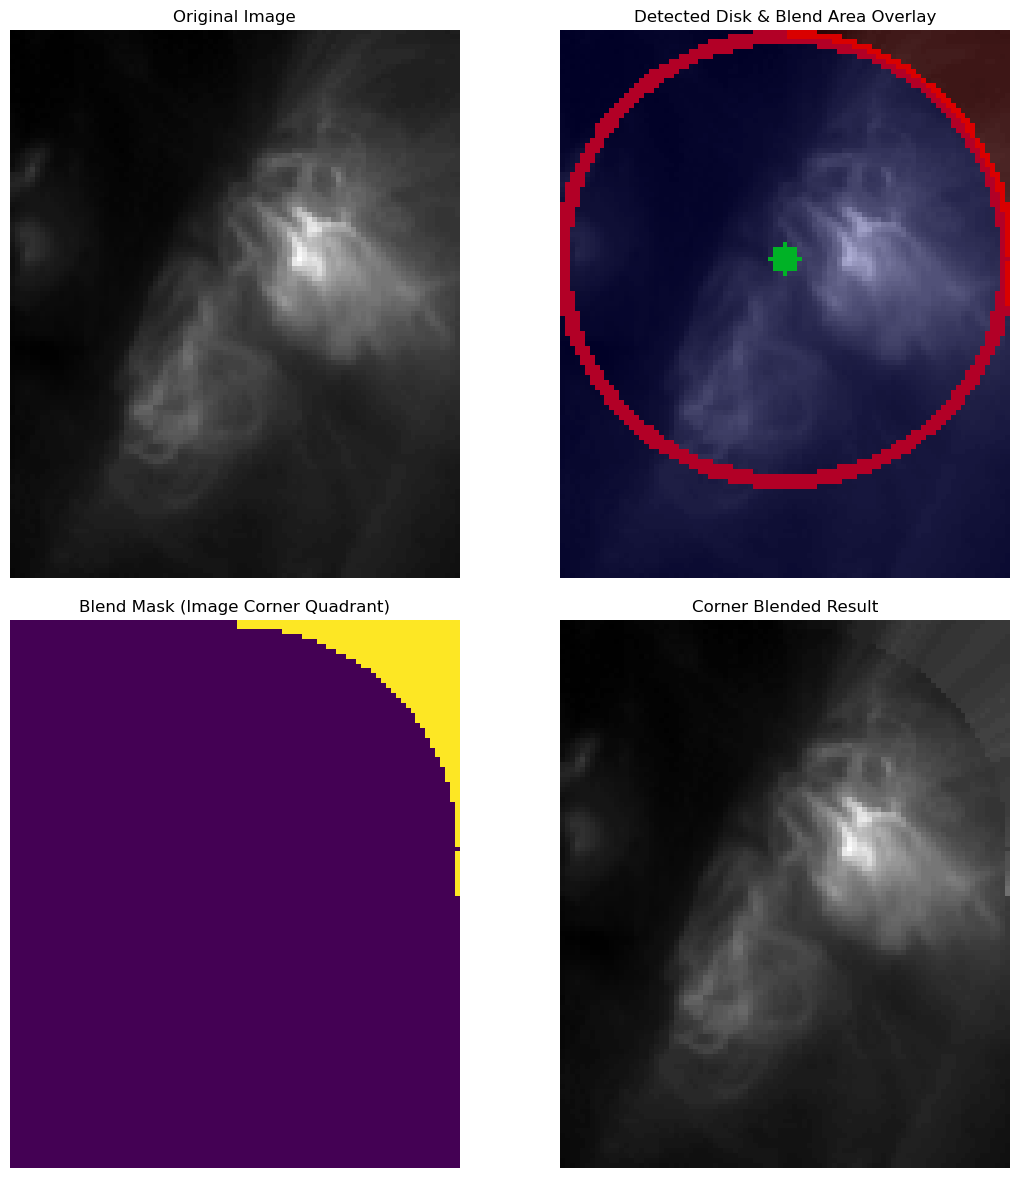


--- Processing: ../Solar_disk_hough_transformation/sample_images/20130519_100400_AR11750 copy.png ---
Detected solar disk at (43.00, 23.00) with radius 22.00
Circle is close to an edge. Determining target corner based on sum of gradient magnitudes.
  Quadrant top-left: Sum of gradients = 125144.00
  Quadrant top-right: Sum of gradients = 160187.00
  Quadrant bottom-left: Sum of gradients = 117912.00
  Quadrant bottom-right: Sum of gradients = 147887.00
Target corner based on max gradient sum: top-right (Sum: 160187.00)
Using sampling offset: 7
Blending 175 pixels in the top-right image quadrant...


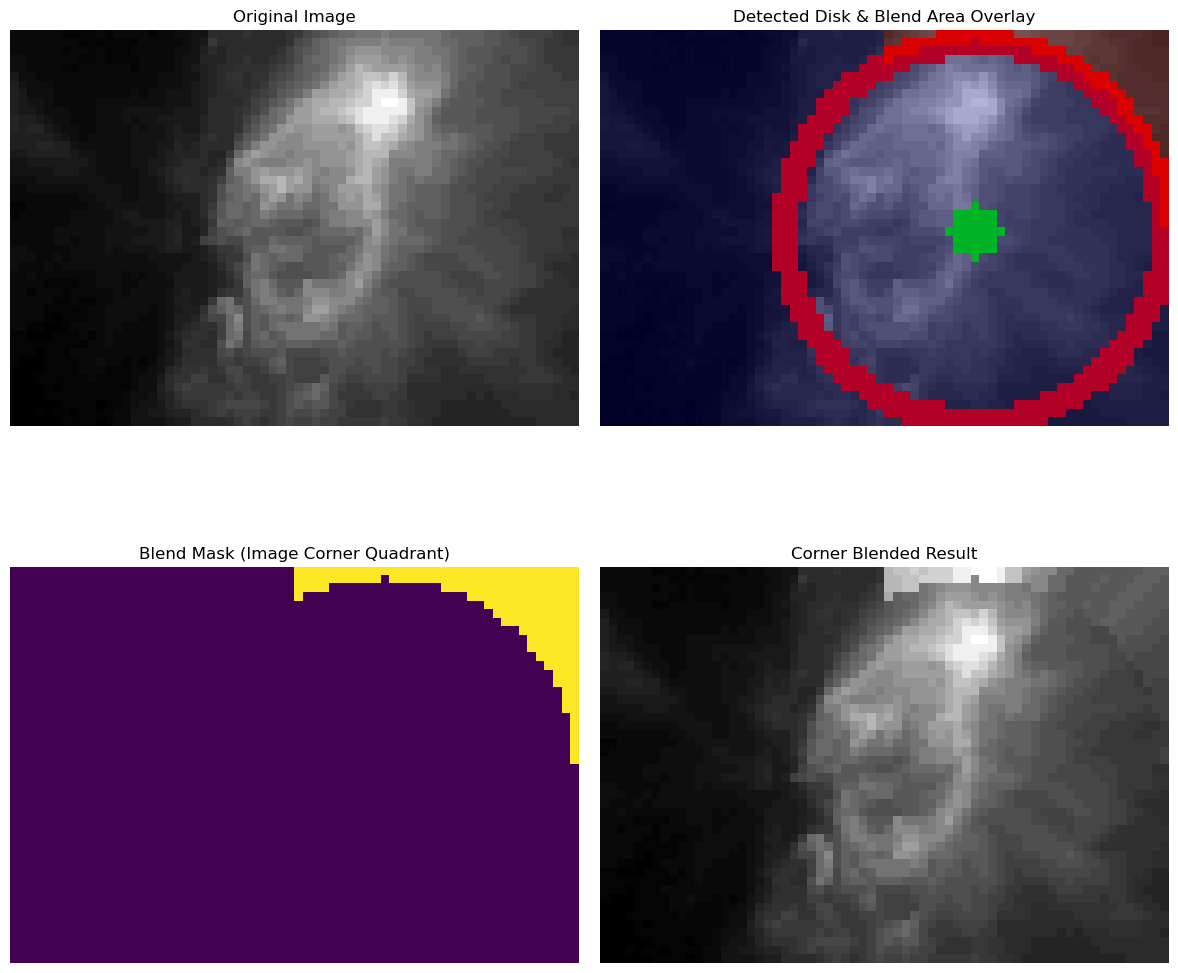


--- Processing: ../Solar_disk_hough_transformation/sample_images/20100527_075825_AR11072 copy.png ---
Detected solar disk at (48.00, 26.00) with radius 25.00
Circle is close to an edge. Determining target corner based on sum of gradient magnitudes.
  Quadrant top-left: Sum of gradients = 125249.00
  Quadrant top-right: Sum of gradients = 130983.00
  Quadrant bottom-left: Sum of gradients = 131127.00
  Quadrant bottom-right: Sum of gradients = 122958.00
Target corner based on max gradient sum: bottom-left (Sum: 131127.00)
Using sampling offset: 7
Blending 759 pixels in the bottom-left image quadrant...


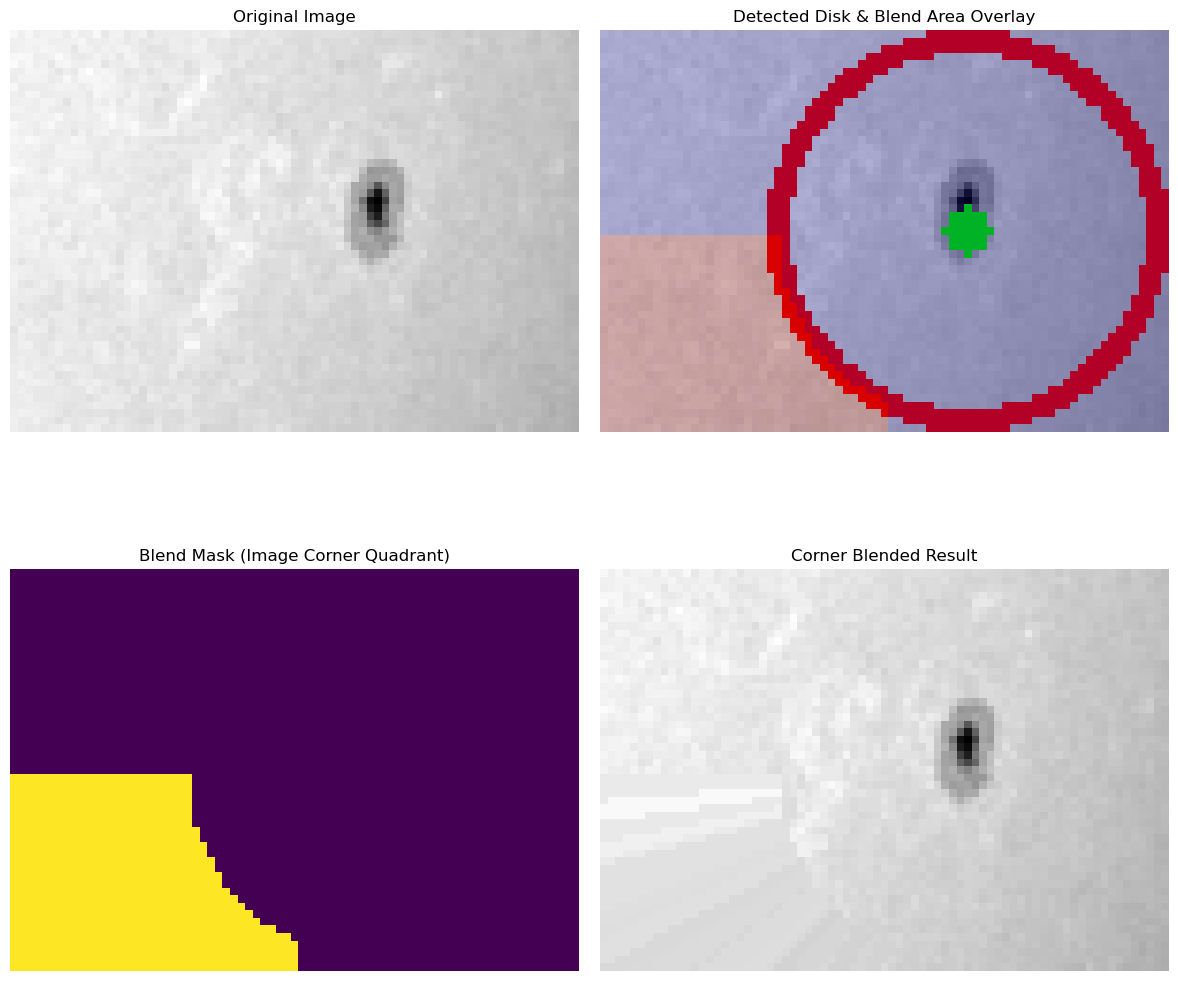


--- Processing: ../Solar_disk_hough_transformation/sample_images/20130104_075809_AR11639 copy.png ---
Detected solar disk at (180.00, 45.00) with radius 45.00
Circle is close to an edge. Determining target corner based on sum of gradient magnitudes.
  Quadrant top-left: Sum of gradients = 1132808.00
  Quadrant top-right: Sum of gradients = 1121127.00
  Quadrant bottom-left: Sum of gradients = 1123156.00
  Quadrant bottom-right: Sum of gradients = 1079819.00
Target corner based on max gradient sum: top-left (Sum: 1132808.00)
Using sampling offset: 7
Blending 5934 pixels in the top-left image quadrant...


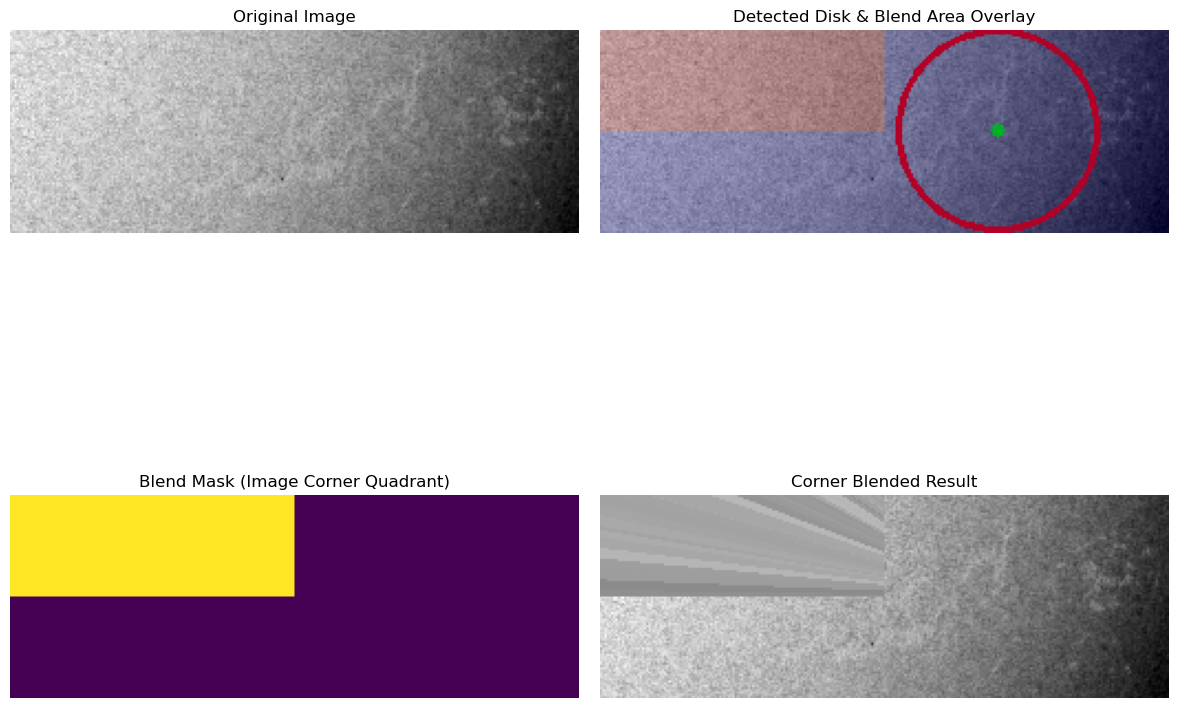


--- Processing: ../Solar_disk_hough_transformation/sample_images/20110809_065825_AR11263 copy.png ---
Detected solar disk at (39.00, 41.00) with radius 39.00
Circle is close to an edge. Determining target corner based on sum of gradient magnitudes.
  Quadrant top-left: Sum of gradients = 430500.00
  Quadrant top-right: Sum of gradients = 427350.00
  Quadrant bottom-left: Sum of gradients = 431543.00
  Quadrant bottom-right: Sum of gradients = 439931.00
Target corner based on max gradient sum: bottom-right (Sum: 439931.00)
Using sampling offset: 7
Blending 868 pixels in the bottom-right image quadrant...


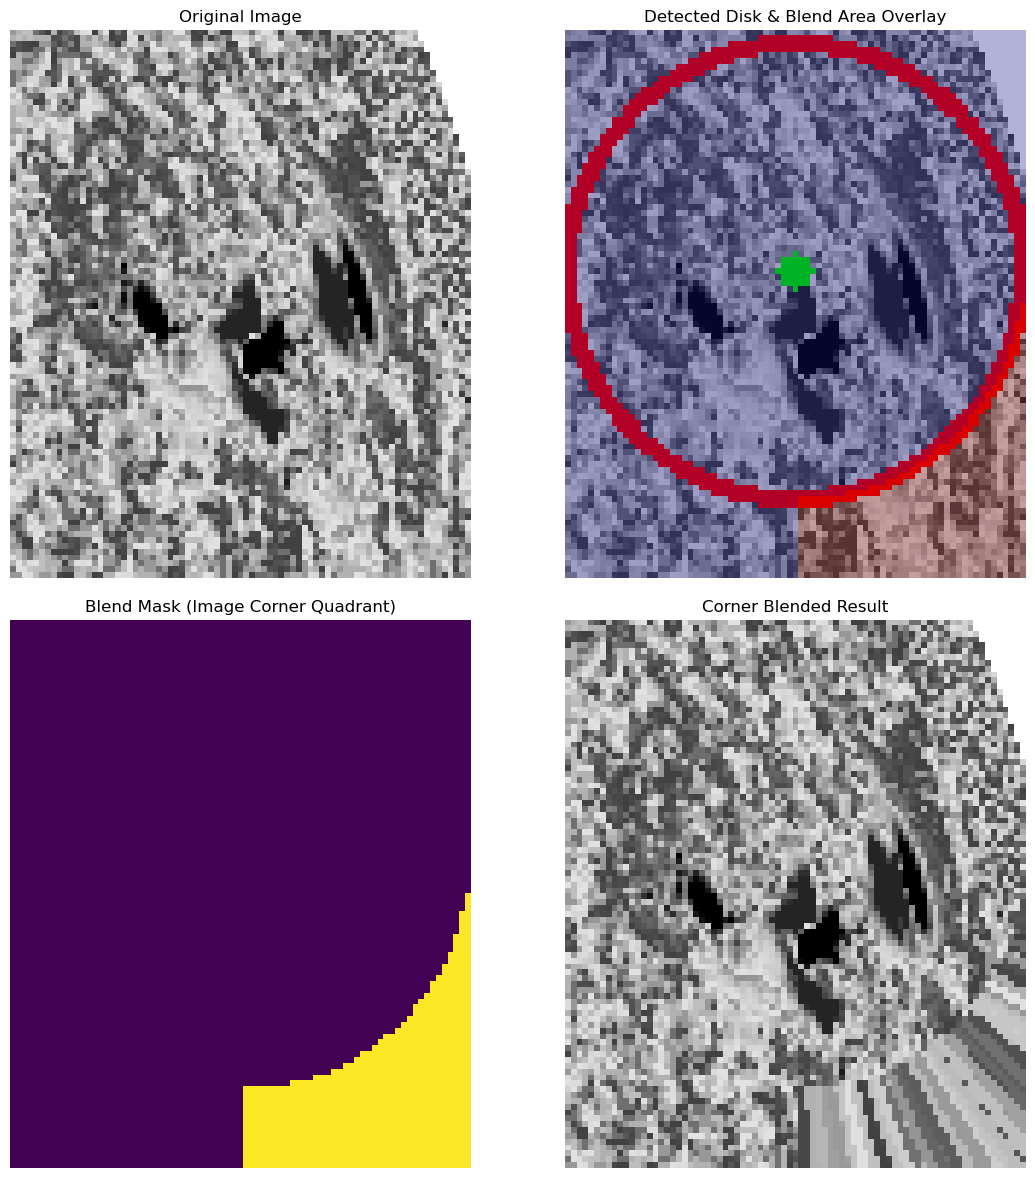


--- Processing: ../Solar_disk_hough_transformation/sample_images/20110307_015814_AR11165 copy.png ---
Detected solar disk at (52.00, 62.00) with radius 51.00
Circle is close to an edge. Determining target corner based on sum of gradient magnitudes.
  Quadrant top-left: Sum of gradients = 813011.00
  Quadrant top-right: Sum of gradients = 825290.00
  Quadrant bottom-left: Sum of gradients = 806360.00
  Quadrant bottom-right: Sum of gradients = 763072.00
Target corner based on max gradient sum: top-right (Sum: 825290.00)
Using sampling offset: 7
Blending 1239 pixels in the top-right image quadrant...


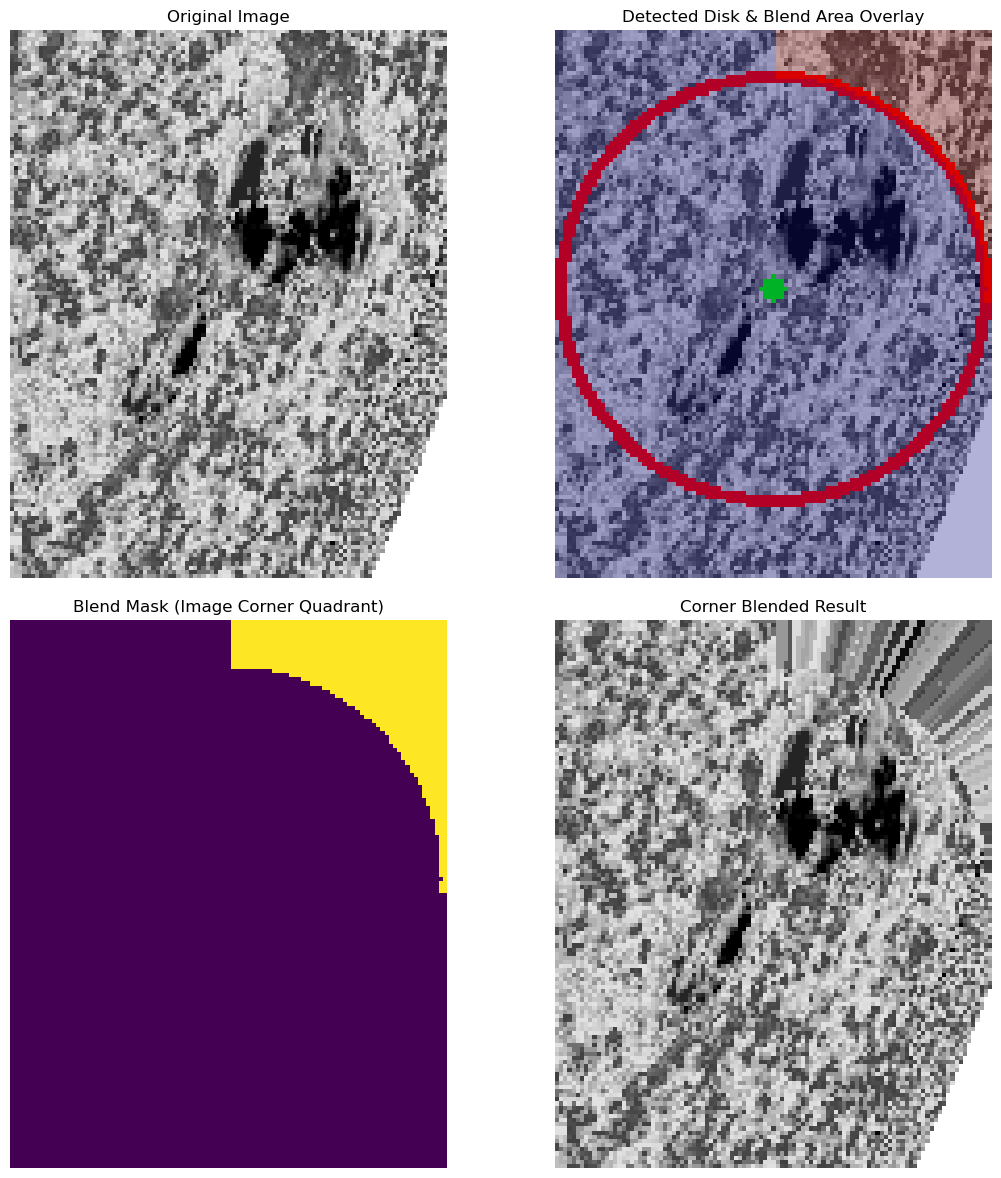


--- Processing: ../Solar_disk_hough_transformation/sample_images/20110809_035825_AR11263 copy.png ---
Detected solar disk at (42.00, 47.00) with radius 40.00
Circle is close to an edge. Determining target corner based on sum of gradient magnitudes.
  Quadrant top-left: Sum of gradients = 465334.00
  Quadrant top-right: Sum of gradients = 456894.00
  Quadrant bottom-left: Sum of gradients = 460484.00
  Quadrant bottom-right: Sum of gradients = 460234.00
Target corner based on max gradient sum: top-left (Sum: 465334.00)
Using sampling offset: 7
Blending 758 pixels in the top-left image quadrant...


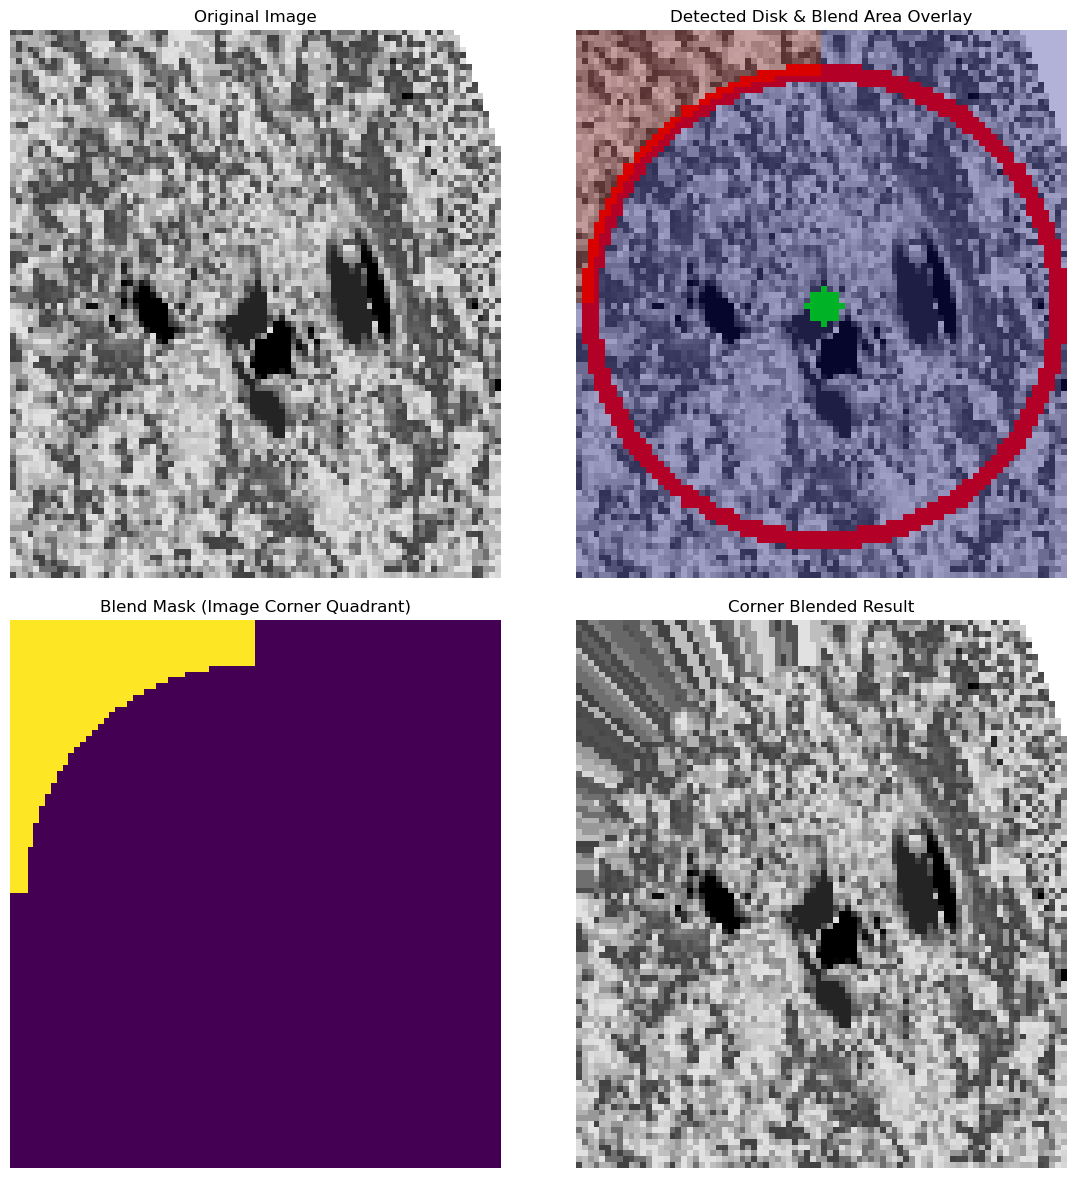


--- Processing: ../Solar_disk_hough_transformation/sample_images/20110808_215825_AR11263 copy.png ---
Detected solar disk at (48.00, 46.00) with radius 45.00
Circle is close to an edge. Determining target corner based on sum of gradient magnitudes.
  Quadrant top-left: Sum of gradients = 265479.00
  Quadrant top-right: Sum of gradients = 376307.00
  Quadrant bottom-left: Sum of gradients = 242030.00
  Quadrant bottom-right: Sum of gradients = 361366.00
Target corner based on max gradient sum: top-right (Sum: 376307.00)
Using sampling offset: 7
Blending 573 pixels in the top-right image quadrant...


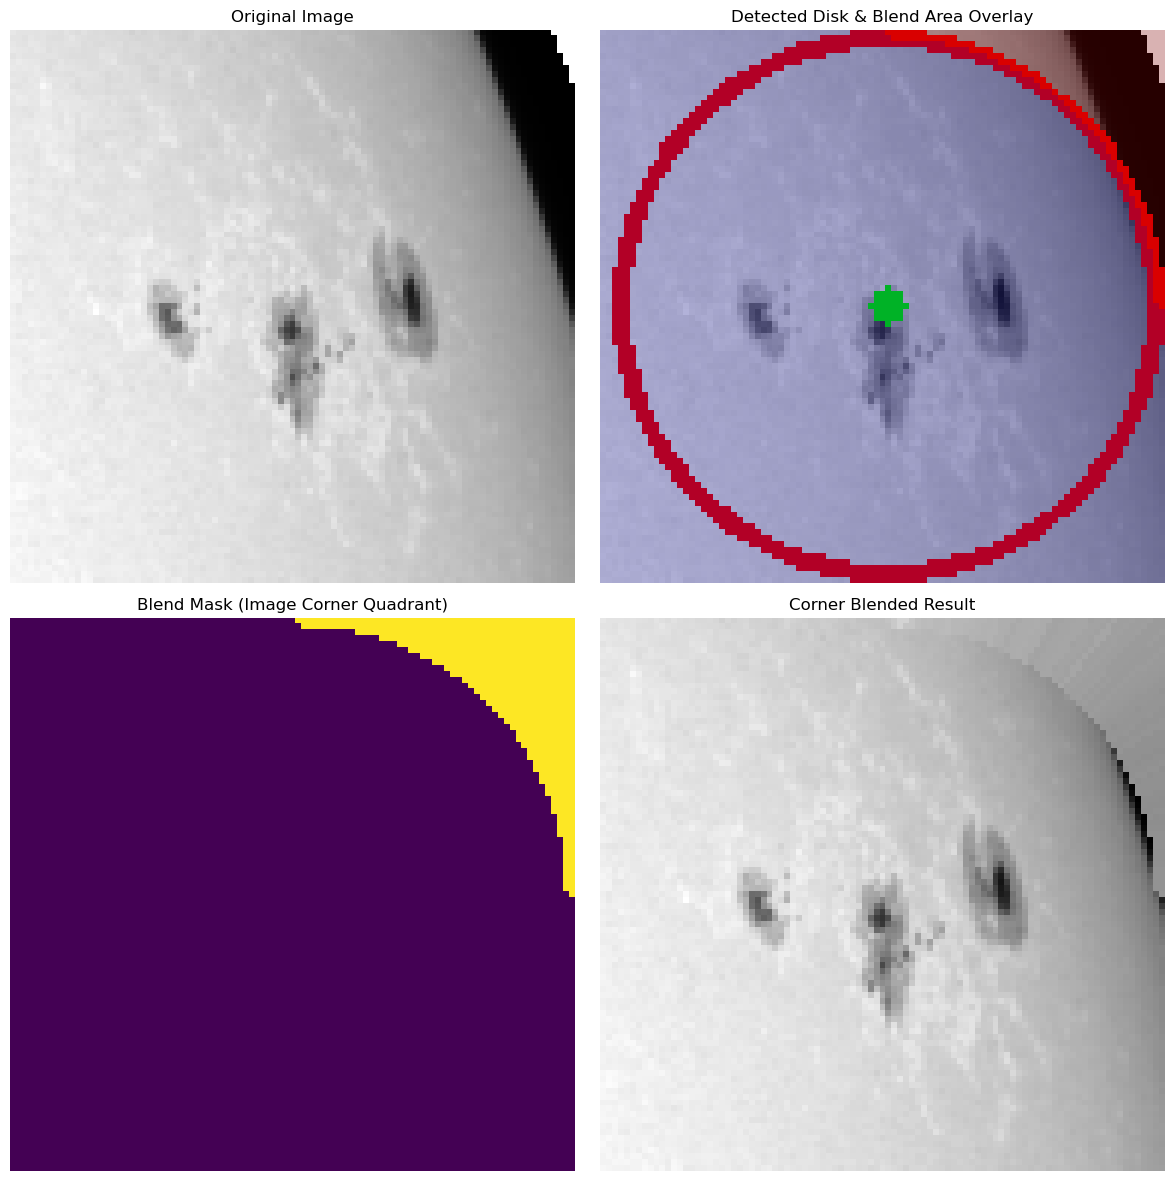


--- Processing: ../Solar_disk_hough_transformation/sample_images/20150319_003415_AR12302 copy.png ---
Detected solar disk at (26.00, 28.00) with radius 25.00
Circle is close to an edge. Determining target corner based on sum of gradient magnitudes.
  Quadrant top-left: Sum of gradients = 121824.00
  Quadrant top-right: Sum of gradients = 154536.00
  Quadrant bottom-left: Sum of gradients = 103666.00
  Quadrant bottom-right: Sum of gradients = 137234.00
Target corner based on max gradient sum: top-right (Sum: 154536.00)
Using sampling offset: 7
Blending 241 pixels in the top-right image quadrant...


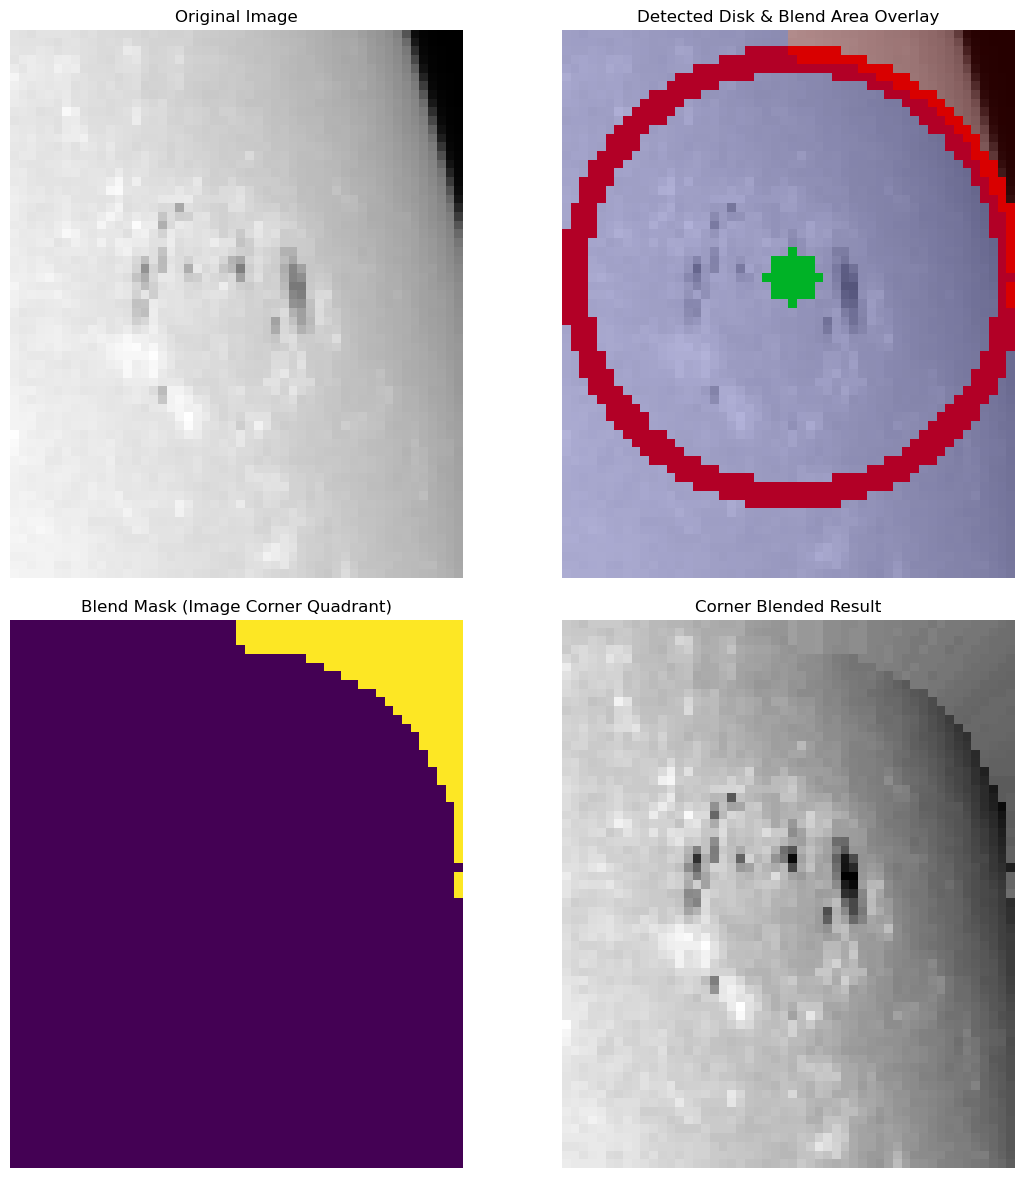


--- Processing: ../Solar_disk_hough_transformation/sample_images/20110808_165825_AR11263 copy.png ---
Detected solar disk at (51.00, 45.00) with radius 45.00
Circle is close to an edge. Determining target corner based on sum of gradient magnitudes.
  Quadrant top-left: Sum of gradients = 280661.00
  Quadrant top-right: Sum of gradients = 389633.00
  Quadrant bottom-left: Sum of gradients = 279688.00
  Quadrant bottom-right: Sum of gradients = 361210.00
Target corner based on max gradient sum: top-right (Sum: 389633.00)
Using sampling offset: 7
Blending 810 pixels in the top-right image quadrant...


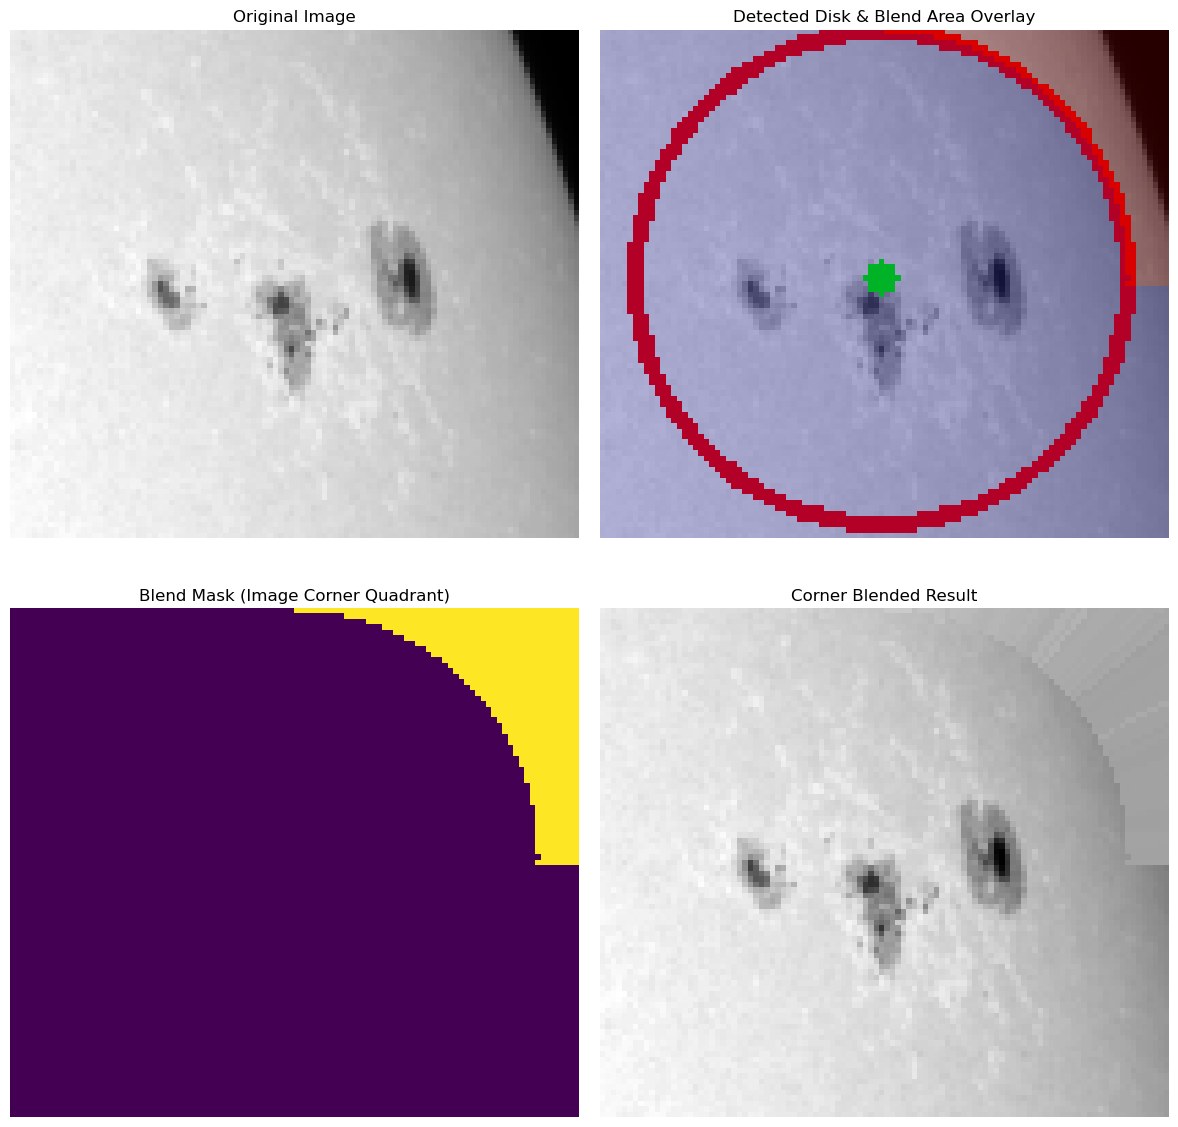


--- Processing: ../Solar_disk_hough_transformation/sample_images/20110513_105823_AR11213 copy.png ---
Detected solar disk at (21.00, 18.00) with radius 17.00
Circle is close to an edge. Determining target corner based on sum of gradient magnitudes.
  Quadrant top-left: Sum of gradients = 82942.00
  Quadrant top-right: Sum of gradients = 96898.00
  Quadrant bottom-left: Sum of gradients = 87757.00
  Quadrant bottom-right: Sum of gradients = 97444.00
Target corner based on max gradient sum: bottom-right (Sum: 97444.00)
Using sampling offset: 7
Blending 293 pixels in the bottom-right image quadrant...


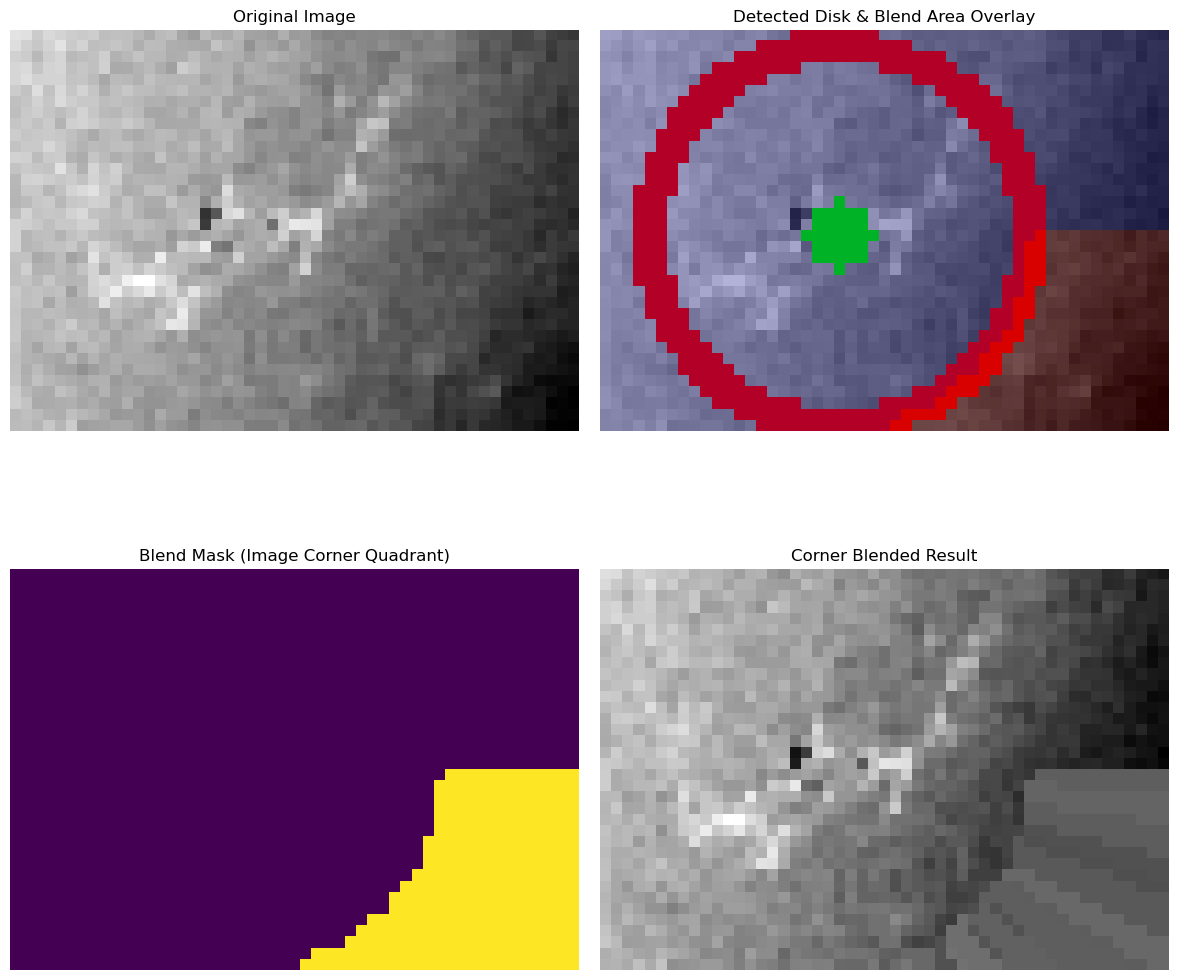

In [312]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from skimage.transform import hough_circle, hough_circle_peaks
import glob
import math

# New name reflecting the logic
def process_image_with_corner_blending_gradient_sum(image_path, radius_margin=10, sampling_offset_val=7):
    """
    Process a solar image to detect the solar disk. Identifies the image corner
    quadrant containing the highest SUM of gradient magnitudes (edge strength).
    Blends pixels outside the disk within that quadrant using values sampled
    from inside the disk. Blending only occurs if the disk is close to at
    least one image boundary.

    Args:
        image_path (str): Path to the solar image.
        radius_margin (int): How close the circle center needs to be to an edge
                             (relative to radius) to trigger potential blending.
        sampling_offset_val (int): How many pixels inside the radius 'r' to sample from.

    Returns:
        tuple: Original image, annotated image, processed image, and mask.
              Returns (None, None, None, None) if file not found or processing fails.
    """
    # --- Load and Prepare the Image ---
    try:
        solar_image = Image.open(image_path).convert("L")
    except FileNotFoundError:
        print(f"Error: Image file not found at {image_path}")
        return None, None, None, None
    original = np.array(solar_image, dtype=np.uint8)
    height, width = original.shape
    img_center_x_float, img_center_y_float = width / 2.0, height / 2.0
    img_center_x_int, img_center_y_int = width // 2, height // 2

    # --- Sobel Edge Detection ---
    sobel_x = cv2.Sobel(original, cv2.CV_64F, 1, 0, ksize=5)
    sobel_y = cv2.Sobel(original, cv2.CV_64F, 0, 1, ksize=5)
    abs_sobel_x = cv2.convertScaleAbs(sobel_x)
    abs_sobel_y = cv2.convertScaleAbs(sobel_y)
    # Keep the gradient magnitude image
    edge_image = cv2.addWeighted(abs_sobel_x, 0.5, abs_sobel_y, 0.5, 0)
    # edge_thresh is no longer needed for corner selection, but keep for Hough
    _, edge_thresh = cv2.threshold(edge_image, 40, 255, cv2.THRESH_BINARY)

    # --- Hough Circle Detection ---
    min_r = int(min(height, width) * 0.15)
    max_r = int(min(height, width) * 0.55)
    step = 2
    radii = np.arange(min_r, max_r, step)

    if len(radii) == 0:
        print(f"Warning: Calculated radii range is empty.")
        annotated_image = cv2.cvtColor(original, cv2.COLOR_GRAY2BGR)
        return original, annotated_image, original.copy(), np.zeros((height, width), dtype=np.float32)

    hough_res = hough_circle(edge_thresh, radii, normalize=False)

    if hough_res is None or np.max(hough_res) == 0:
         print("Hough transform did not yield any results.")
         annotated_image = cv2.cvtColor(original, cv2.COLOR_GRAY2BGR)
         return original, annotated_image, original.copy(), np.zeros((height, width), dtype=np.float32)

    accums, cx, cy, detected_radii = hough_circle_peaks(
        hough_res, radii,
        min_xdistance=int(width * 0.1), min_ydistance=int(height * 0.1),
        threshold=0.4 * np.max(hough_res),
        total_num_peaks=1
    )

    # --- Initialize Outputs ---
    annotated_image = cv2.cvtColor(original, cv2.COLOR_GRAY2BGR)
    blended_image = original.copy()
    blend_mask = np.zeros((height, width), dtype=np.uint8)

    if len(accums) > 0:
        x, y, r = cx[0], cy[0], detected_radii[0]
        r = max(1, r)

        print(f"Detected solar disk at ({x:.2f}, {y:.2f}) with radius {r:.2f}")

        cv2.circle(annotated_image, (int(round(x)), int(round(y))), int(round(r)), (0, 0, 255), 2)
        cv2.circle(annotated_image, (int(round(x)), int(round(y))), 3, (0, 255, 0), -1)

        # --- Determine proximity to edges ---
        dist_top = y
        dist_bottom = height - y
        dist_left = x
        dist_right = width - x
        radius_margin_check = 10 # Keep a margin for this check
        is_close_top = dist_top < r + radius_margin_check
        is_close_bottom = dist_bottom < r + radius_margin_check
        is_close_left = dist_left < r + radius_margin_check
        is_close_right = dist_right < r + radius_margin_check
        needs_blending = is_close_top or is_close_bottom or is_close_left or is_close_right

        if needs_blending:
            print("Circle is close to an edge. Determining target corner based on sum of gradient magnitudes.")

            # --- Identify corner based on SUM of GRADIENT MAGNITUDES in image quadrant ---
            # Use integer slicing indices based on image center
            # Use edge_image (gradient magnitude), NOT edge_thresh (binary)
            quadrants_grad = {
                "top-left": edge_image[0:img_center_y_int, 0:img_center_x_int],
                "top-right": edge_image[0:img_center_y_int, img_center_x_int:width],
                "bottom-left": edge_image[img_center_y_int:height, 0:img_center_x_int],
                "bottom-right": edge_image[img_center_y_int:height, img_center_x_int:width]
            }

            max_gradient_sum = -1.0 # Initialize with a value lower than any possible sum
            target_corner_name = None # Reset

            for name, quadrant_slice in quadrants_grad.items():
                # Sum the gradient magnitudes (edge strengths) in the quadrant
                # Ensure the slice is valid before summing
                if quadrant_slice.size > 0:
                     gradient_sum = np.sum(quadrant_slice.astype(np.float64)) # Use float64 for potentially large sums
                else:
                     gradient_sum = 0.0

                print(f"  Quadrant {name}: Sum of gradients = {gradient_sum:.2f}")
                # Select the quadrant with the highest sum of gradient magnitudes
                if gradient_sum > max_gradient_sum:
                    max_gradient_sum = gradient_sum
                    target_corner_name = name
                # Tie-breaking: first one encountered with max wins.

            # Handle case where sums might be zero everywhere
            if target_corner_name is None:
                 print("Warning: Could not determine target corner based on gradient sums (all zero?). Defaulting to top-left.")
                 target_corner_name = "top-left" # Provide a default if needed

            print(f"Target corner based on max gradient sum: {target_corner_name} (Sum: {max_gradient_sum:.2f})")


            # --- Create the blend mask using IMAGE CENTER for quadrant definition (using the new target_corner_name) ---
            Y_coords, X_coords = np.ogrid[:height, :width]

            # 1. Mask for pixels strictly outside the detected circle radius
            dist_from_center_sq = (X_coords - x)**2 + (Y_coords - y)**2
            outside_circle_mask = dist_from_center_sq > r**2

            # 2. Mask for the IMAGE corner quadrant corresponding to target_corner_name
            image_corner_quadrant_mask = np.zeros((height, width), dtype=bool)
            if target_corner_name == "top-left":
                image_corner_quadrant_mask = (Y_coords < img_center_y_float) & (X_coords < img_center_x_float)
            elif target_corner_name == "top-right":
                image_corner_quadrant_mask = (Y_coords < img_center_y_float) & (X_coords >= img_center_x_float)
            elif target_corner_name == "bottom-left":
                image_corner_quadrant_mask = (Y_coords >= img_center_y_float) & (X_coords < img_center_x_float)
            elif target_corner_name == "bottom-right":
                image_corner_quadrant_mask = (Y_coords >= img_center_y_float) & (X_coords >= img_center_x_float)

            # 3. Final mask: Pixels must be BOTH outside the circle AND within the target IMAGE corner quadrant
            blend_mask = (outside_circle_mask & image_corner_quadrant_mask).astype(np.uint8)

            # --- Apply Blending using the image corner quadrant mask (using increased sampling offset) ---
            indices_to_blend = np.argwhere(blend_mask > 0)
            sampling_offset = sampling_offset_val # Use the function argument
            print(f"Using sampling offset: {sampling_offset}")
            inside_r = max(1, r - sampling_offset) # Calculate sample radius

            if len(indices_to_blend) > 0:
                print(f"Blending {len(indices_to_blend)} pixels in the {target_corner_name} image quadrant...")
                # Blending loop remains the same
                for i, j in indices_to_blend:
                    vec_x = j - x
                    vec_y = i - y
                    dist = math.sqrt(vec_x**2 + vec_y**2)
                    if dist > 0:
                        norm_vec_x = vec_x / dist
                        norm_vec_y = vec_y / dist
                        sample_x = x + norm_vec_x * inside_r
                        sample_y = y + norm_vec_y * inside_r
                        sample_x_int = max(0, min(width - 1, int(round(sample_x))))
                        sample_y_int = max(0, min(height - 1, int(round(sample_y))))
                        blended_image[i, j] = original[sample_y_int, sample_x_int]
            else:
                print(f"No pixels identified for blending in the target image quadrant outside the circle.")

            # --- Visualize the specific replaced area ---
            if np.any(blend_mask):
                blend_viz_color = cv2.applyColorMap(blend_mask * 255, cv2.COLORMAP_JET)
                alpha = 0.3
                cv2.addWeighted(blend_viz_color, alpha, annotated_image, 1 - alpha, 0, annotated_image)

        else: # needs_blending is False
            print("Circle is fully contained within margins relative to edges. No blending applied.")

    else: # No circle detected
        print("No suitable circle detected after Hough peaks analysis.")

    # Return results
    return original, annotated_image, blended_image, blend_mask.astype(np.float32)

# --- Display Function (remains the same) ---
def display_results(orig, annotated, blended, blend_mask):
    if orig is None:
        print("Cannot display results because input images are None.")
        return
    fig, axs = plt.subplots(2, 2, figsize=(12, 12))
    axs[0, 0].imshow(orig, cmap="gray")
    axs[0, 0].set_title("Original Image")
    axs[0, 0].axis("off")
    axs[0, 1].imshow(cv2.cvtColor(annotated, cv2.COLOR_BGR2RGB))
    axs[0, 1].set_title("Detected Disk & Blend Area Overlay")
    axs[0, 1].axis("off")
    axs[1, 0].imshow(blend_mask, cmap="viridis", vmin=0, vmax=1)
    axs[1, 0].set_title("Blend Mask (Image Corner Quadrant)")
    axs[1, 0].axis("off")
    axs[1, 1].imshow(blended, cmap="gray")
    axs[1, 1].set_title("Corner Blended Result")
    axs[1, 1].axis("off")
    plt.tight_layout(pad=1.5)
    plt.show()

# --- Example Usage ---
if __name__ == "__main__":
    image_folder_path = "../Solar_disk_hough_transformation/sample_images/"
    # Use the image file that previously resulted in the wrong corner selection
    # Make sure the filename is correct and the file is in the specified folder
    # Example: (replace with the actual filename if different)
    image_pattern = "Screenshot 2025-03-31 at 4.27.54 PM.jpg" # Or the original PNG/FITS file
    # image_pattern = "original_filename_for_that_screenshot.png"


    image_files = glob.glob(image_folder_path + image_pattern)

    if not image_files:
         print(f"Error: No image files found matching pattern '{image_pattern}' in folder '{image_folder_path}'.")
         # Try the default pattern as a fallback if specific one not found
         print("Trying default pattern '20110110_065810_AR11140 copy.png'...")
         image_pattern = "*.png"
         image_files = glob.glob(image_folder_path + image_pattern)
         if not image_files:
              print("Default pattern also not found. Please check path and filenames.")

    if image_files:
        print(f"Found {len(image_files)} image(s) to process.")
        for image_path in image_files:
            print(f"\n--- Processing: {image_path} ---")
            # Use the new function name
            orig, annotated, blended, blend_mask = process_image_with_corner_blending_gradient_sum(
                image_path,
                radius_margin=15, # This margin is just for the initial check if blending is needed
                sampling_offset_val=7 # Keep the increased offset that worked
            )
            if orig is not None:
                display_results(orig, annotated, blended, blend_mask)
            else:
                print(f"Skipping display for {image_path} due to processing error.")

Error: No image files found matching pattern 'Screenshot 2025-03-31 at 4.42.39 PM.jpg' in folder '../Solar_disk_hough_transformation/sample_images/'.
Trying default pattern '20110110_065810_AR11140 copy.png'...
Found 1 image(s) to process.

--- Processing: ../Solar_disk_hough_transformation/sample_images/20110110_065810_AR11140 copy.png ---
Detected solar disk at (74.00, 55.00) with radius 54.00
Circle is close to an edge. Determining target corner based on standard deviation of gradients.
  Quadrant top-left: Std Dev of gradients = 59.85
  Quadrant top-right: Std Dev of gradients = 84.89
  Quadrant bottom-left: Std Dev of gradients = 54.13
  Quadrant bottom-right: Std Dev of gradients = 60.95
Target corner based on max gradient std dev: top-right (Std Dev: 84.89)
Using sampling offset: 7
Blending 2024 pixels in the top-right image quadrant...


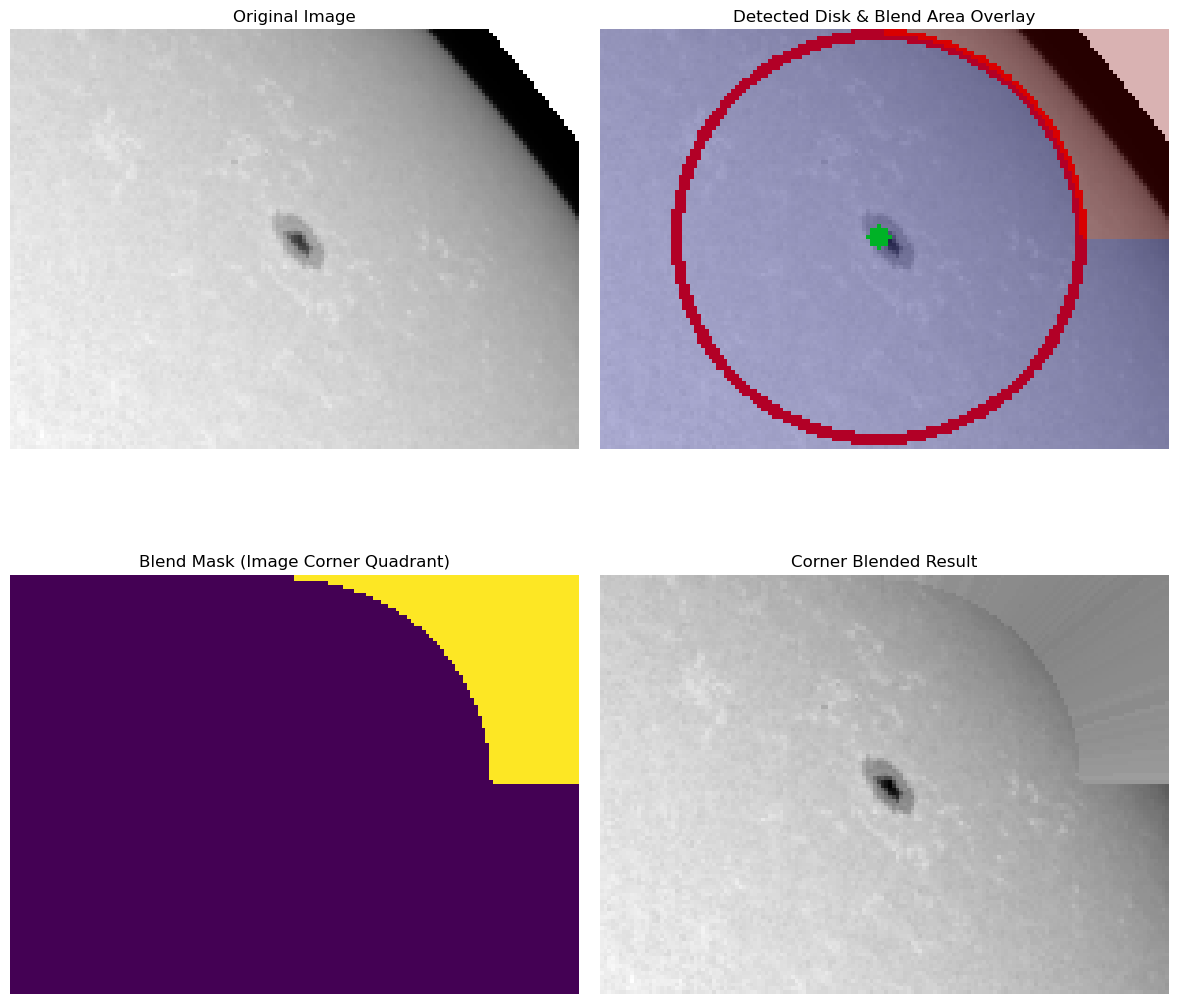

In [315]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from skimage.transform import hough_circle, hough_circle_peaks
import glob
import math

# New name reflecting the logic
def process_image_with_corner_blending_gradient_stddev(image_path, radius_margin=10, sampling_offset_val=7):
    """
    Process a solar image to detect the solar disk. Identifies the image corner
    quadrant containing the highest STANDARD DEVIATION of gradient magnitudes
    (indicating most variability in edge strength). Blends pixels outside the disk
    within that quadrant using values sampled from inside the disk. Blending only
    occurs if the disk is close to at least one image boundary.

    Args:
        image_path (str): Path to the solar image.
        radius_margin (int): How close the circle center needs to be to an edge
                             (relative to radius) to trigger potential blending check.
        sampling_offset_val (int): How many pixels inside the radius 'r' to sample from.

    Returns:
        tuple: Original image, annotated image, processed image, and mask.
              Returns (None, None, None, None) if file not found or processing fails.
    """
    # --- Load and Prepare the Image ---
    try:
        solar_image = Image.open(image_path).convert("L")
    except FileNotFoundError:
        print(f"Error: Image file not found at {image_path}")
        return None, None, None, None
    original = np.array(solar_image, dtype=np.uint8)
    height, width = original.shape
    img_center_x_float, img_center_y_float = width / 2.0, height / 2.0
    img_center_x_int, img_center_y_int = width // 2, height // 2

    # --- Sobel Edge Detection ---
    sobel_x = cv2.Sobel(original, cv2.CV_64F, 1, 0, ksize=5)
    sobel_y = cv2.Sobel(original, cv2.CV_64F, 0, 1, ksize=5)
    abs_sobel_x = cv2.convertScaleAbs(sobel_x)
    abs_sobel_y = cv2.convertScaleAbs(sobel_y)
    # Keep the gradient magnitude image
    edge_image = cv2.addWeighted(abs_sobel_x, 0.5, abs_sobel_y, 0.5, 0)
    # edge_thresh is needed for Hough
    _, edge_thresh = cv2.threshold(edge_image, 50, 255, cv2.THRESH_BINARY)

    # --- Hough Circle Detection ---
    min_r = int(min(height, width) * 0.15)
    max_r = int(min(height, width) * 0.55)
    step = 2
    radii = np.arange(min_r, max_r, step)

    if len(radii) == 0:
        print(f"Warning: Calculated radii range is empty.")
        annotated_image = cv2.cvtColor(original, cv2.COLOR_GRAY2BGR)
        return original, annotated_image, original.copy(), np.zeros((height, width), dtype=np.float32)

    hough_res = hough_circle(edge_thresh, radii, normalize=False)

    if hough_res is None or np.max(hough_res) == 0:
         print("Hough transform did not yield any results.")
         annotated_image = cv2.cvtColor(original, cv2.COLOR_GRAY2BGR)
         return original, annotated_image, original.copy(), np.zeros((height, width), dtype=np.float32)

    accums, cx, cy, detected_radii = hough_circle_peaks(
        hough_res, radii,
        min_xdistance=int(width * 0.1), min_ydistance=int(height * 0.1),
        threshold=0.4 * np.max(hough_res),
        total_num_peaks=1
    )

    # --- Initialize Outputs ---
    annotated_image = cv2.cvtColor(original, cv2.COLOR_GRAY2BGR)
    blended_image = original.copy()
    blend_mask = np.zeros((height, width), dtype=np.uint8)

    if len(accums) > 0:
        x, y, r = cx[0], cy[0], detected_radii[0]
        r = max(1, r)

        print(f"Detected solar disk at ({x:.2f}, {y:.2f}) with radius {r:.2f}")

        cv2.circle(annotated_image, (int(round(x)), int(round(y))), int(round(r)), (0, 0, 255), 2)
        cv2.circle(annotated_image, (int(round(x)), int(round(y))), 3, (0, 255, 0), -1)

        # --- Determine proximity to edges (for initial check) ---
        dist_top_center = y
        dist_bottom_center = height - y
        dist_left_center = x
        dist_right_center = width - x
        radius_margin_check = 10 # Keep a margin for this check
        is_close_top = dist_top_center < r + radius_margin_check
        is_close_bottom = dist_bottom_center < r + radius_margin_check
        is_close_left = dist_left_center < r + radius_margin_check
        is_close_right = dist_right_center < r + radius_margin_check
        needs_blending = is_close_top or is_close_bottom or is_close_left or is_close_right

        if needs_blending:
            print("Circle is close to an edge. Determining target corner based on standard deviation of gradients.")

            # --- Identify corner based on MAX STANDARD DEVIATION of GRADIENTS in image quadrant ---
            # Use integer slicing indices based on image center
            # Use edge_image (gradient magnitude)
            quadrants_grad = {
                "top-left": edge_image[0:img_center_y_int, 0:img_center_x_int],
                "top-right": edge_image[0:img_center_y_int, img_center_x_int:width],
                "bottom-left": edge_image[img_center_y_int:height, 0:img_center_x_int],
                "bottom-right": edge_image[img_center_y_int:height, img_center_x_int:width]
            }

            max_std_dev = -1.0
            target_corner_name = None # Reset

            for name, quadrant_slice in quadrants_grad.items():
                # Calculate the standard deviation of gradient magnitudes in the quadrant
                if quadrant_slice.size > 1: # Need more than 1 pixel to calculate std dev
                    # Use float64 for precision in std dev calculation
                    std_dev_in_quad = np.std(quadrant_slice.astype(np.float64))
                else:
                    # Standard deviation is undefined or 0 for single point/empty slice
                    std_dev_in_quad = 0.0

                print(f"  Quadrant {name}: Std Dev of gradients = {std_dev_in_quad:.2f}")
                # Select the quadrant containing the overall highest standard deviation
                if std_dev_in_quad > max_std_dev:
                    max_std_dev = std_dev_in_quad
                    target_corner_name = name
                # Tie-breaking: first one encountered with max wins.

            # Handle case where std dev is zero everywhere
            if target_corner_name is None:
                 print("Warning: Could not determine target corner based on std dev of gradients (all zero?). Defaulting.")
                 target_corner_name = "top-left" # Example default

            print(f"Target corner based on max gradient std dev: {target_corner_name} (Std Dev: {max_std_dev:.2f})")


            # --- Create the blend mask using IMAGE CENTER for quadrant definition (using the new target_corner_name) ---
            Y_coords, X_coords = np.ogrid[:height, :width]

            # 1. Mask for pixels strictly outside the detected circle radius
            dist_from_center_sq = (X_coords - x)**2 + (Y_coords - y)**2
            outside_circle_mask = dist_from_center_sq > r**2

            # 2. Mask for the IMAGE corner quadrant corresponding to target_corner_name
            image_corner_quadrant_mask = np.zeros((height, width), dtype=bool)
            if target_corner_name == "top-left":
                image_corner_quadrant_mask = (Y_coords < img_center_y_float) & (X_coords < img_center_x_float)
            elif target_corner_name == "top-right":
                image_corner_quadrant_mask = (Y_coords < img_center_y_float) & (X_coords >= img_center_x_float)
            elif target_corner_name == "bottom-left":
                image_corner_quadrant_mask = (Y_coords >= img_center_y_float) & (X_coords < img_center_x_float)
            elif target_corner_name == "bottom-right":
                image_corner_quadrant_mask = (Y_coords >= img_center_y_float) & (X_coords >= img_center_x_float)

            # 3. Final mask: Pixels must be BOTH outside the circle AND within the target IMAGE corner quadrant
            blend_mask = (outside_circle_mask & image_corner_quadrant_mask).astype(np.uint8)

            # --- Apply Blending using the image corner quadrant mask (using increased sampling offset) ---
            indices_to_blend = np.argwhere(blend_mask > 0)
            sampling_offset = sampling_offset_val # Use the function argument
            print(f"Using sampling offset: {sampling_offset}")
            inside_r = max(1, r - sampling_offset) # Calculate sample radius

            if len(indices_to_blend) > 0:
                print(f"Blending {len(indices_to_blend)} pixels in the {target_corner_name} image quadrant...")
                # Blending loop remains the same
                for i, j in indices_to_blend:
                    vec_x = j - x
                    vec_y = i - y
                    dist = math.sqrt(vec_x**2 + vec_y**2)
                    if dist > 0:
                        norm_vec_x = vec_x / dist
                        norm_vec_y = vec_y / dist
                        sample_x = x + norm_vec_x * inside_r
                        sample_y = y + norm_vec_y * inside_r
                        sample_x_int = max(0, min(width - 1, int(round(sample_x))))
                        sample_y_int = max(0, min(height - 1, int(round(sample_y))))
                        blended_image[i, j] = original[sample_y_int, sample_x_int]
            else:
                print(f"No pixels identified for blending in the target image quadrant outside the circle.")

            # --- Visualize the specific replaced area ---
            if np.any(blend_mask):
                blend_viz_color = cv2.applyColorMap(blend_mask * 255, cv2.COLORMAP_JET)
                alpha = 0.3
                cv2.addWeighted(blend_viz_color, alpha, annotated_image, 1 - alpha, 0, annotated_image)

        else: # needs_blending is False
            print("Circle is fully contained within margins relative to edges. No blending applied.")

    else: # No circle detected
        print("No suitable circle detected after Hough peaks analysis.")

    # Return results
    return original, annotated_image, blended_image, blend_mask.astype(np.float32)

# --- Display Function (remains the same) ---
def display_results(orig, annotated, blended, blend_mask):
    # ... (display function is unchanged) ...
    if orig is None:
        print("Cannot display results because input images are None.")
        return
    fig, axs = plt.subplots(2, 2, figsize=(12, 12))
    axs[0, 0].imshow(orig, cmap="gray")
    axs[0, 0].set_title("Original Image")
    axs[0, 0].axis("off")
    axs[0, 1].imshow(cv2.cvtColor(annotated, cv2.COLOR_BGR2RGB))
    axs[0, 1].set_title("Detected Disk & Blend Area Overlay")
    axs[0, 1].axis("off")
    axs[1, 0].imshow(blend_mask, cmap="viridis", vmin=0, vmax=1)
    axs[1, 0].set_title("Blend Mask (Image Corner Quadrant)")
    axs[1, 0].axis("off")
    axs[1, 1].imshow(blended, cmap="gray")
    axs[1, 1].set_title("Corner Blended Result")
    axs[1, 1].axis("off")
    plt.tight_layout(pad=1.5)
    plt.show()

# --- Example Usage ---
if __name__ == "__main__":
    image_folder_path = "../Solar_disk_hough_transformation/sample_images/"
    # Use the image file that previously resulted in the wrong corner selection
    # Make sure the filename is correct and the file is in the specified folder
    # Example: (replace with the actual filename if different)
    image_pattern = "Screenshot 2025-03-31 at 4.42.39 PM.jpg" # <-- Image from latest screenshot showing failure
    # image_pattern = "original_filename_for_that_screenshot.png"

    image_files = glob.glob(image_folder_path + image_pattern)

    if not image_files:
         print(f"Error: No image files found matching pattern '{image_pattern}' in folder '{image_folder_path}'.")
         # Try the default pattern as a fallback if specific one not found
         print("Trying default pattern '20110110_065810_AR11140 copy.png'...")
         image_pattern = "20110110_065810_AR11140 copy.png"
         image_files = glob.glob(image_folder_path + image_pattern)
         if not image_files:
              print("Default pattern also not found. Please check path and filenames.")

    if image_files:
        print(f"Found {len(image_files)} image(s) to process.")
        for image_path in image_files:
            print(f"\n--- Processing: {image_path} ---")
            # Use the new function name
            orig, annotated, blended, blend_mask = process_image_with_corner_blending_gradient_stddev(
                image_path,
                radius_margin=15, # This margin is just for the initial check if blending is needed
                sampling_offset_val=7 # Keep the increased offset that worked
            )
            if orig is not None:
                display_results(orig, annotated, blended, blend_mask)
            else:
                print(f"Skipping display for {image_path} due to processing error.")

Error: No image files found matching pattern 'Screenshot 2025-03-31 at 4.42.39 PM.jpg' in folder '../Solar_disk_hough_transformation/sample_images/'.
Trying default pattern '20110110_065810_AR11140 copy.png'...
Found 1 image(s) to process.

--- Processing: ../Solar_disk_hough_transformation/sample_images/20110110_065810_AR11140 copy.png ---
Detected solar disk at (28.00, 108.00) with radius 134.00
Circle is close to an edge. Determining target corner based on standard deviation of gradients.
  Quadrant top-left: Std Dev of gradients = 10.71
  Quadrant top-right: Std Dev of gradients = 53.66
  Quadrant bottom-left: Std Dev of gradients = 10.83
  Quadrant bottom-right: Std Dev of gradients = 16.06
Target corner based on max gradient std dev: top-right (Std Dev: 53.66)
Using sampling offset: 7
Blending 1027 pixels in the top-right image quadrant...


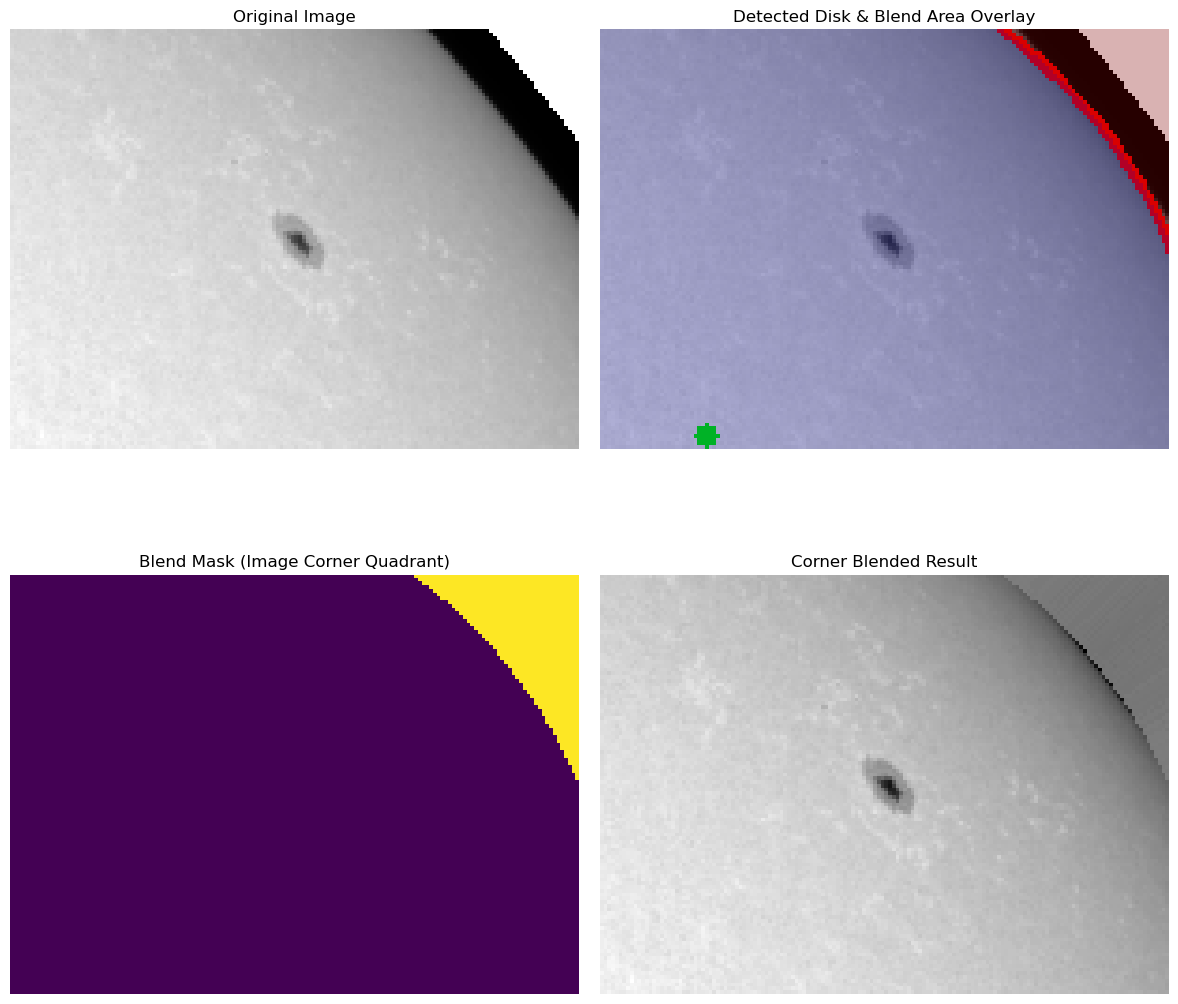

In [318]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from skimage.transform import hough_circle, hough_circle_peaks
import glob
import math

# New name reflecting the logic
def process_image_with_corner_blending_gradient_stddev(image_path, radius_margin=10, sampling_offset_val=7):
    """
    Process a solar image to detect the solar disk. Identifies the image corner
    quadrant containing the highest STANDARD DEVIATION of gradient magnitudes
    (indicating most variability in edge strength). Blends pixels outside the disk
    within that quadrant using values sampled from inside the disk. Blending only
    occurs if the disk is close to at least one image boundary.

    Args:
        image_path (str): Path to the solar image.
        radius_margin (int): How close the circle center needs to be to an edge
                             (relative to radius) to trigger potential blending check.
        sampling_offset_val (int): How many pixels inside the radius 'r' to sample from.

    Returns:
        tuple: Original image, annotated image, processed image, and mask.
              Returns (None, None, None, None) if file not found or processing fails.
    """
    # --- Load and Prepare the Image ---
    try:
        solar_image = Image.open(image_path).convert("L")
    except FileNotFoundError:
        print(f"Error: Image file not found at {image_path}")
        return None, None, None, None
    original = np.array(solar_image, dtype=np.uint8)
    height, width = original.shape
    img_center_x_float, img_center_y_float = width / 2.0, height / 2.0
    img_center_x_int, img_center_y_int = width // 2, height // 2

    # --- Sobel Edge Detection for circle finding ---
    sobel_x = cv2.Sobel(original, cv2.CV_64F, 1, 0, ksize=3)
    sobel_y = cv2.Sobel(original, cv2.CV_64F, 0, 1, ksize=3)
    
    abs_sobel_x = cv2.convertScaleAbs(sobel_x)
    abs_sobel_y = cv2.convertScaleAbs(sobel_y)
    
    edge_image = cv2.addWeighted(abs_sobel_x, 0.5, abs_sobel_y, 0.5, 0)
    _, edge_thresh = cv2.threshold(edge_image, 50, 255, cv2.THRESH_BINARY)
    
    # --- Hough Circle Detection to find the solar disk ---
    radii = np.arange(50, 150, 2)  # Adjust range based on your images
    
    hough_res = hough_circle(edge_thresh, radii, normalize=False)
    
    accums, cx, cy, detected_radii = hough_circle_peaks(
        hough_res, radii,
        min_xdistance=50, min_ydistance=50,
        threshold=0.5 * np.max(hough_res),
        total_num_peaks=3
    )

    # --- Initialize Outputs ---
    annotated_image = cv2.cvtColor(original, cv2.COLOR_GRAY2BGR)
    blended_image = original.copy()
    blend_mask = np.zeros((height, width), dtype=np.uint8)

    if len(accums) > 0:
        x, y, r = cx[0], cy[0], detected_radii[0]
        r = max(1, r)

        print(f"Detected solar disk at ({x:.2f}, {y:.2f}) with radius {r:.2f}")

        cv2.circle(annotated_image, (int(round(x)), int(round(y))), int(round(r)), (0, 0, 255), 2)
        cv2.circle(annotated_image, (int(round(x)), int(round(y))), 3, (0, 255, 0), -1)

        # --- Determine proximity to edges (for initial check) ---
        dist_top_center = y
        dist_bottom_center = height - y
        dist_left_center = x
        dist_right_center = width - x
        radius_margin_check = 10 # Keep a margin for this check
        is_close_top = dist_top_center < r + radius_margin_check
        is_close_bottom = dist_bottom_center < r + radius_margin_check
        is_close_left = dist_left_center < r + radius_margin_check
        is_close_right = dist_right_center < r + radius_margin_check
        needs_blending = is_close_top or is_close_bottom or is_close_left or is_close_right

        if needs_blending:
            print("Circle is close to an edge. Determining target corner based on standard deviation of gradients.")

            # --- Identify corner based on MAX STANDARD DEVIATION of GRADIENTS in image quadrant ---
            # Use integer slicing indices based on image center
            # Use edge_image (gradient magnitude)
            quadrants_grad = {
                "top-left": edge_image[0:img_center_y_int, 0:img_center_x_int],
                "top-right": edge_image[0:img_center_y_int, img_center_x_int:width],
                "bottom-left": edge_image[img_center_y_int:height, 0:img_center_x_int],
                "bottom-right": edge_image[img_center_y_int:height, img_center_x_int:width]
            }

            max_std_dev = -1.0
            target_corner_name = None # Reset

            for name, quadrant_slice in quadrants_grad.items():
                # Calculate the standard deviation of gradient magnitudes in the quadrant
                if quadrant_slice.size > 1: # Need more than 1 pixel to calculate std dev
                    # Use float64 for precision in std dev calculation
                    std_dev_in_quad = np.std(quadrant_slice.astype(np.float64))
                else:
                    # Standard deviation is undefined or 0 for single point/empty slice
                    std_dev_in_quad = 0.0

                print(f"  Quadrant {name}: Std Dev of gradients = {std_dev_in_quad:.2f}")
                # Select the quadrant containing the overall highest standard deviation
                if std_dev_in_quad > max_std_dev:
                    max_std_dev = std_dev_in_quad
                    target_corner_name = name
                # Tie-breaking: first one encountered with max wins.

            # Handle case where std dev is zero everywhere
            if target_corner_name is None:
                 print("Warning: Could not determine target corner based on std dev of gradients (all zero?). Defaulting.")
                 target_corner_name = "top-left" # Example default

            print(f"Target corner based on max gradient std dev: {target_corner_name} (Std Dev: {max_std_dev:.2f})")


            # --- Create the blend mask using IMAGE CENTER for quadrant definition (using the new target_corner_name) ---
            Y_coords, X_coords = np.ogrid[:height, :width]

            # 1. Mask for pixels strictly outside the detected circle radius
            dist_from_center_sq = (X_coords - x)**2 + (Y_coords - y)**2
            outside_circle_mask = dist_from_center_sq > r**2

            # 2. Mask for the IMAGE corner quadrant corresponding to target_corner_name
            image_corner_quadrant_mask = np.zeros((height, width), dtype=bool)
            if target_corner_name == "top-left":
                image_corner_quadrant_mask = (Y_coords < img_center_y_float) & (X_coords < img_center_x_float)
            elif target_corner_name == "top-right":
                image_corner_quadrant_mask = (Y_coords < img_center_y_float) & (X_coords >= img_center_x_float)
            elif target_corner_name == "bottom-left":
                image_corner_quadrant_mask = (Y_coords >= img_center_y_float) & (X_coords < img_center_x_float)
            elif target_corner_name == "bottom-right":
                image_corner_quadrant_mask = (Y_coords >= img_center_y_float) & (X_coords >= img_center_x_float)

            # 3. Final mask: Pixels must be BOTH outside the circle AND within the target IMAGE corner quadrant
            blend_mask = (outside_circle_mask & image_corner_quadrant_mask).astype(np.uint8)

            # --- Apply Blending using the image corner quadrant mask (using increased sampling offset) ---
            indices_to_blend = np.argwhere(blend_mask > 0)
            sampling_offset = sampling_offset_val # Use the function argument
            print(f"Using sampling offset: {sampling_offset}")
            inside_r = max(1, r - sampling_offset) # Calculate sample radius

            if len(indices_to_blend) > 0:
                print(f"Blending {len(indices_to_blend)} pixels in the {target_corner_name} image quadrant...")
                # Blending loop remains the same
                for i, j in indices_to_blend:
                    vec_x = j - x
                    vec_y = i - y
                    dist = math.sqrt(vec_x**2 + vec_y**2)
                    if dist > 0:
                        norm_vec_x = vec_x / dist
                        norm_vec_y = vec_y / dist
                        sample_x = x + norm_vec_x * inside_r
                        sample_y = y + norm_vec_y * inside_r
                        sample_x_int = max(0, min(width - 1, int(round(sample_x))))
                        sample_y_int = max(0, min(height - 1, int(round(sample_y))))
                        blended_image[i, j] = original[sample_y_int, sample_x_int]
            else:
                print(f"No pixels identified for blending in the target image quadrant outside the circle.")

            # --- Visualize the specific replaced area ---
            if np.any(blend_mask):
                blend_viz_color = cv2.applyColorMap(blend_mask * 255, cv2.COLORMAP_JET)
                alpha = 0.3
                cv2.addWeighted(blend_viz_color, alpha, annotated_image, 1 - alpha, 0, annotated_image)

        else: # needs_blending is False
            print("Circle is fully contained within margins relative to edges. No blending applied.")

    else: # No circle detected
        print("No suitable circle detected after Hough peaks analysis.")

    # Return results
    return original, annotated_image, blended_image, blend_mask.astype(np.float32)

# --- Display Function (remains the same) ---
def display_results(orig, annotated, blended, blend_mask):
    # ... (display function is unchanged) ...
    if orig is None:
        print("Cannot display results because input images are None.")
        return
    fig, axs = plt.subplots(2, 2, figsize=(12, 12))
    axs[0, 0].imshow(orig, cmap="gray")
    axs[0, 0].set_title("Original Image")
    axs[0, 0].axis("off")
    axs[0, 1].imshow(cv2.cvtColor(annotated, cv2.COLOR_BGR2RGB))
    axs[0, 1].set_title("Detected Disk & Blend Area Overlay")
    axs[0, 1].axis("off")
    axs[1, 0].imshow(blend_mask, cmap="viridis", vmin=0, vmax=1)
    axs[1, 0].set_title("Blend Mask (Image Corner Quadrant)")
    axs[1, 0].axis("off")
    axs[1, 1].imshow(blended, cmap="gray")
    axs[1, 1].set_title("Corner Blended Result")
    axs[1, 1].axis("off")
    plt.tight_layout(pad=1.5)
    plt.show()

# --- Example Usage ---
if __name__ == "__main__":
    image_folder_path = "../Solar_disk_hough_transformation/sample_images/"
    # Use the image file that previously resulted in the wrong corner selection
    # Make sure the filename is correct and the file is in the specified folder
    # Example: (replace with the actual filename if different)
    image_pattern = "Screenshot 2025-03-31 at 4.42.39 PM.jpg" # <-- Image from latest screenshot showing failure
    # image_pattern = "original_filename_for_that_screenshot.png"

    image_files = glob.glob(image_folder_path + image_pattern)

    if not image_files:
         print(f"Error: No image files found matching pattern '{image_pattern}' in folder '{image_folder_path}'.")
         # Try the default pattern as a fallback if specific one not found
         print("Trying default pattern '20110110_065810_AR11140 copy.png'...")
         image_pattern = "20110110_065810_AR11140 copy.png"
         image_files = glob.glob(image_folder_path + image_pattern)
         if not image_files:
              print("Default pattern also not found. Please check path and filenames.")

    if image_files:
        print(f"Found {len(image_files)} image(s) to process.")
        for image_path in image_files:
            print(f"\n--- Processing: {image_path} ---")
            # Use the new function name
            orig, annotated, blended, blend_mask = process_image_with_corner_blending_gradient_stddev(
                image_path,
                radius_margin=15, # This margin is just for the initial check if blending is needed
                sampling_offset_val=7 # Keep the increased offset that worked
            )
            if orig is not None:
                display_results(orig, annotated, blended, blend_mask)
            else:
                print(f"Skipping display for {image_path} due to processing error.")

Detected solar disk at (28.00, 108.00) with radius 134.00
Circle is close to an edge. Determining target corner using refined SD calculation.
Calculating gradient std dev for pixels STRICTLY OUTSIDE the circle in each quadrant:
  Quadrant top-left: Found 0 pixels outside circle. Skipping SD calculation.
  Quadrant top-right: Found 1027 pixels outside circle. Std Dev = 91.21
  Quadrant bottom-left: Found 0 pixels outside circle. Skipping SD calculation.
  Quadrant bottom-right: Found 0 pixels outside circle. Skipping SD calculation.
Target corner chosen: top-right (Max relevant Std Dev: 91.21)
Blending pixels with distance >= 132.50 from center (r=134.00, allowance=1.5)
Using sampling offset: 7
Blending 1135 pixels in the top-right image quadrant...


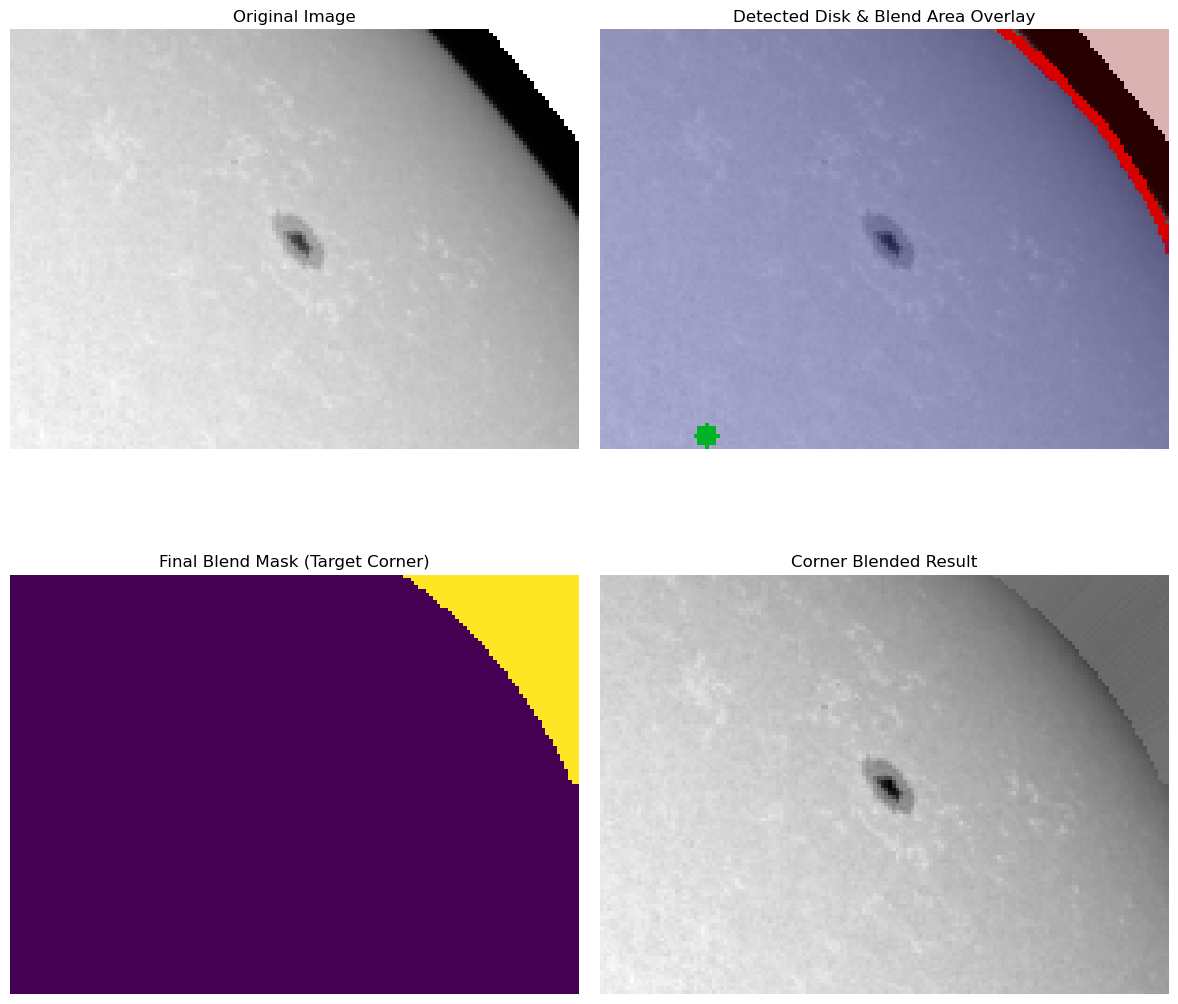

In [321]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from skimage.transform import hough_circle, hough_circle_peaks
import glob
import math

def process_image_with_corner_blending_gradient_stddev_refined_selection( # Renamed function slightly
    image_path,
    radius_margin=10,
    sampling_offset_val=7,
    blend_radius_allowance=1.5
    ):
    """
    Process solar image. Identifies corner with max gradient std dev calculated
    ONLY from pixels STRICTLY OUTSIDE the circle within relevant image quadrants.
    Blends pixels outside OR SLIGHTLY INSIDE the disk within that quadrant.
    Blending only occurs if the disk is close to at least one image boundary.

    Args:
        image_path (str): Path to the solar image.
        radius_margin (int): Margin for initial blending check.
        sampling_offset_val (int): How far inside 'r' to sample from.
        blend_radius_allowance (float): Blend pixels up to this many pixels INSIDE radius 'r'.

    Returns:
        tuple: Original image, annotated image, processed image, and mask.
    """
    # --- Load and Prepare the Image ---
    try:
        solar_image = Image.open(image_path).convert("L")
    except FileNotFoundError:
        print(f"Error: Image file not found at {image_path}")
        return None, None, None, None
    original = np.array(solar_image, dtype=np.uint8)
    height, width = original.shape
    img_center_x_float, img_center_y_float = width / 2.0, height / 2.0
    img_center_x_int, img_center_y_int = width // 2, height // 2

    # --- Sobel Edge Detection ---
    sobel_x = cv2.Sobel(original, cv2.CV_64F, 1, 0, ksize=3)
    sobel_y = cv2.Sobel(original, cv2.CV_64F, 0, 1, ksize=3)
    abs_sobel_x = cv2.convertScaleAbs(sobel_x)
    abs_sobel_y = cv2.convertScaleAbs(sobel_y)
    edge_image = cv2.addWeighted(abs_sobel_x, 0.5, abs_sobel_y, 0.5, 0) # Gradient magnitude image
    _, edge_thresh = cv2.threshold(edge_image, 50, 255, cv2.THRESH_BINARY)

    # --- Hough Circle Detection ---
    radii = np.arange(50, 150, 2)
    if len(radii) == 0:
        print("Warning: Radii range is empty.")
        annotated_image = cv2.cvtColor(original, cv2.COLOR_GRAY2BGR)
        return original, annotated_image, original.copy(), np.zeros((height, width), dtype=np.float32)

    hough_res = hough_circle(edge_thresh, radii, normalize=False)

    if hough_res is None or np.max(hough_res) == 0:
        print("Hough transform did not yield any results.")
        annotated_image = cv2.cvtColor(original, cv2.COLOR_GRAY2BGR)
        return original, annotated_image, original.copy(), np.zeros((height, width), dtype=np.float32)

    accums, cx, cy, detected_radii = hough_circle_peaks(
        hough_res, radii,
        min_xdistance=50, min_ydistance=50,
        threshold=0.5 * np.max(hough_res),
        total_num_peaks=1
    )

    # --- Initialize Outputs ---
    annotated_image = cv2.cvtColor(original, cv2.COLOR_GRAY2BGR)
    blended_image = original.copy()
    blend_mask = np.zeros((height, width), dtype=np.uint8) # Use uint8 for mask initially

    if len(accums) > 0:
        best_idx = np.argmax(accums)
        x, y, r = cx[best_idx], cy[best_idx], detected_radii[best_idx]
        r = max(1, r) # Ensure radius is at least 1

        print(f"Detected solar disk at ({x:.2f}, {y:.2f}) with radius {r:.2f}")

        cv2.circle(annotated_image, (int(round(x)), int(round(y))), int(round(r)), (0, 0, 255), 2)
        cv2.circle(annotated_image, (int(round(x)), int(round(y))), 3, (0, 255, 0), -1)

        # --- Determine proximity to edges (for initial check) ---
        dist_top_center = y
        dist_bottom_center = height - y
        dist_left_center = x
        dist_right_center = width - x
        radius_margin_check = radius_margin # Use argument
        is_close_top = dist_top_center < r + radius_margin_check
        is_close_bottom = dist_bottom_center < r + radius_margin_check
        is_close_left = dist_left_center < r + radius_margin_check
        is_close_right = dist_right_center < r + radius_margin_check
        needs_blending = is_close_top or is_close_bottom or is_close_left or is_close_right

        if needs_blending:
            print("Circle is close to an edge. Determining target corner using refined SD calculation.")

            # --- [MODIFIED CORNER SELECTION LOGIC] ---
            # Calculate SD of gradients ONLY for pixels STRICTLY OUTSIDE the circle in relevant quadrants.

            # 1. Generate coordinates and calculate squared distance from center
            Y_coords, X_coords = np.ogrid[:height, :width]
            dist_from_center_sq = (X_coords - x)**2 + (Y_coords - y)**2
            r_squared = r**2

            # 2. Create mask for pixels strictly outside the circle
            strictly_outside_circle_mask = dist_from_center_sq > r_squared

            # 3. Define image quadrant masks using integer center coordinates
            top_mask = Y_coords < img_center_y_int
            bottom_mask = Y_coords >= img_center_y_int
            left_mask = X_coords < img_center_x_int
            right_mask = X_coords >= img_center_x_int

            quadrant_masks = {
                "top-left": top_mask & left_mask,
                "top-right": top_mask & right_mask,
                "bottom-left": bottom_mask & left_mask,
                "bottom-right": bottom_mask & right_mask
            }

            quadrant_sds = {}
            max_std_dev = -1.0  # Initialize to -1 to ensure any valid SD is larger
            target_corner_name = None

            print("Calculating gradient std dev for pixels STRICTLY OUTSIDE the circle in each quadrant:")
            for name, quad_mask in quadrant_masks.items():
                # Create a combined mask for pixels in this quadrant AND strictly outside the circle
                combined_mask_for_sd = quad_mask & strictly_outside_circle_mask

                # Check if there are any pixels in this specific region
                if np.any(combined_mask_for_sd):
                    # Extract the gradient values ONLY for these relevant pixels
                    relevant_gradients = edge_image[combined_mask_for_sd]
                    pixel_count = relevant_gradients.size

                    std_dev_in_quad = 0.0 # Default SD is 0
                    if pixel_count > 1: # Need at least 2 points to calculate standard deviation
                        # Ensure calculation is done in float64 for stability
                        std_dev_in_quad = np.std(relevant_gradients.astype(np.float64))
                        print(f"  Quadrant {name}: Found {pixel_count} pixels outside circle. Std Dev = {std_dev_in_quad:.2f}")
                    elif pixel_count == 1:
                        std_dev_in_quad = 0.0 # Standard deviation of a single point is 0
                        print(f"  Quadrant {name}: Found 1 pixel outside circle. Std Dev = 0.00")
                    # else: pixel_count is 0, std_dev remains 0.0 - This case is handled by np.any check

                    quadrant_sds[name] = std_dev_in_quad

                    # Update the max SD and target corner name
                    if std_dev_in_quad > max_std_dev:
                        max_std_dev = std_dev_in_quad
                        target_corner_name = name
                    # Handle the very first valid quadrant found if max_std_dev is still -1
                    elif target_corner_name is None:
                         max_std_dev = std_dev_in_quad # Can be 0 if only 1 pixel found
                         target_corner_name = name

                else: # No pixels in this quadrant are outside the circle
                    quadrant_sds[name] = 0.0 # Assign SD of 0
                    print(f"  Quadrant {name}: Found 0 pixels outside circle. Skipping SD calculation.")

            # --- [END OF MODIFIED CORNER SELECTION LOGIC] ---


            # Fallback if no corner could be determined (e.g., needs_blending=True but r=0?)
            if target_corner_name is None:
                print("Warning: Could not determine target corner based on outside-circle pixels.")
                # Option 1: Check if any quadrant had non-zero SD, even if max is 0 (due to single pixels)
                valid_sds = {k: v for k, v in quadrant_sds.items() if k in quadrant_masks} # Filter potentially missing keys if logic changes
                if any(v > 0 for v in valid_sds.values()): # Should not happen if max_std_dev logic is correct
                     target_corner_name = max(valid_sds, key=valid_sds.get)
                     print(f"-> Fallback: Selected corner with max SD anyway: {target_corner_name}")
                else:
                    # Option 2: Default if absolutely no pixels found outside or only single pixels (all SD=0)
                    print("-> Fallback: Defaulting to top-left corner.")
                    target_corner_name = "top-left"
                    # Ensure the chosen default exists in quadrant_masks
                    if target_corner_name not in quadrant_masks: target_corner_name = list(quadrant_masks.keys())[0]


            print(f"Target corner chosen: {target_corner_name} (Max relevant Std Dev: {max_std_dev:.2f})")


            # --- Create the blend mask (using blend_radius_allowance) ---
            # This part remains UNCHANGED. It defines the actual area to blend using
            # the original allowance, based on the corner selected above.

            # 1. Mask for pixels outside OR SLIGHTLY INSIDE the detected circle radius
            effective_r_for_mask = max(0, r - blend_radius_allowance)
            # Check if effective radius is valid compared to r
            if effective_r_for_mask >= r and blend_radius_allowance > 0:
                print(f"Warning: blend_radius_allowance ({blend_radius_allowance}) >= r ({r}). Clamping effective_r to slightly less than r.")
                effective_r_for_mask = r * 0.99 # Or some small value less than r
            elif effective_r_for_mask < 0:
                 effective_r_for_mask = 0 # Should be handled by max() already

            print(f"Blending pixels with distance >= {effective_r_for_mask:.2f} from center (r={r:.2f}, allowance={blend_radius_allowance})")
            outside_or_near_circle_mask = dist_from_center_sq >= (effective_r_for_mask**2) # Uses allowance

            # 2. Mask for the IMAGE corner quadrant corresponding to target_corner_name
            image_corner_quadrant_mask = quadrant_masks[target_corner_name] # Reuse the quadrant mask

            # 3. Final mask: Pixels must be BOTH outside/near the circle AND within the target IMAGE corner quadrant
            blend_mask = (outside_or_near_circle_mask & image_corner_quadrant_mask).astype(np.uint8)


            # --- Apply Blending using the image corner quadrant mask ---
            indices_to_blend = np.argwhere(blend_mask > 0)
            sampling_offset = sampling_offset_val
            print(f"Using sampling offset: {sampling_offset}")
            inside_r = max(1, r - sampling_offset)
            # Add check for sampling offset validity
            if inside_r >= r and sampling_offset > 0:
                print(f"Warning: sampling_offset ({sampling_offset}) >= r ({r}). Clamping sample radius.")
                inside_r = max(1, r * 0.9) # Sample closer to edge if offset too large
            elif inside_r < 1:
                 inside_r = 1 # Ensure it's at least 1

            if len(indices_to_blend) > 0:
                print(f"Blending {len(indices_to_blend)} pixels in the {target_corner_name} image quadrant...")
                # Blending loop remains the same
                for i, j in indices_to_blend:
                    vec_x = j - x
                    vec_y = i - y
                    dist = math.sqrt(vec_x**2 + vec_y**2)
                    if dist > 0: # Avoid division by zero if pixel is exactly at center (unlikely here)
                        norm_vec_x = vec_x / dist
                        norm_vec_y = vec_y / dist
                        sample_x = x + norm_vec_x * inside_r
                        sample_y = y + norm_vec_y * inside_r
                        # Clamp sample coordinates to be within image bounds
                        sample_x_int = max(0, min(width - 1, int(round(sample_x))))
                        sample_y_int = max(0, min(height - 1, int(round(sample_y))))
                        # Perform the replacement
                        blended_image[i, j] = original[sample_y_int, sample_x_int]
            else:
                print(f"No pixels identified for blending in the target image quadrant outside/near the circle edge.")


            # --- Visualize the specific replaced area ---
            if np.any(blend_mask):
                blend_viz_color = cv2.applyColorMap(blend_mask * 255, cv2.COLORMAP_JET)
                alpha = 0.3
                cv2.addWeighted(blend_viz_color, alpha, annotated_image, 1 - alpha, 0, annotated_image)

        else: # needs_blending is False
            print("Circle is fully contained within margins relative to edges. No blending applied.")

    else: # No circle detected
        print("No suitable circle detected after Hough peaks analysis.")

    # Return results (convert mask to float for consistent return type, though uint8 was used internally)
    return original, annotated_image, blended_image, blend_mask.astype(np.float32)


# --- Display Function (remains the same) ---
def display_results(orig, annotated, blended, blend_mask):
    if orig is None:
        print("Cannot display results because input images are None.")
        return
    fig, axs = plt.subplots(2, 2, figsize=(12, 12))
    axs[0, 0].imshow(orig, cmap="gray")
    axs[0, 0].set_title("Original Image")
    axs[0, 0].axis("off")
    axs[0, 1].imshow(cv2.cvtColor(annotated, cv2.COLOR_BGR2RGB))
    axs[0, 1].set_title("Detected Disk & Blend Area Overlay")
    axs[0, 1].axis("off")
    axs[1, 0].imshow(blend_mask, cmap="viridis", vmin=0, vmax=1) # Assuming mask is 0 or 1 (float)
    axs[1, 0].set_title("Final Blend Mask (Target Corner)")
    axs[1, 0].axis("off")
    axs[1, 1].imshow(blended, cmap="gray")
    axs[1, 1].set_title("Corner Blended Result")
    axs[1, 1].axis("off")
    plt.tight_layout(pad=1.5)
    plt.show()


# Example usage:
if __name__ == "__main__":
    # Get the image path
    image_files = glob.glob("../Solar_disk_hough_transformation/sample_images/20110110_065810_AR11140 copy.png")
    
    # Process each image
    for image_path in image_files:
            orig, annotated, blended, blend_mask = process_image_with_corner_blending_gradient_stddev_refined_selection(
                image_path,
                radius_margin=15,       # Margin for initial check if blending is needed
                sampling_offset_val=7,  # How far inside 'r' to sample replacement pixels
                blend_radius_allowance=1.5 # How far inside 'r' the blend mask can extend
            )
        
        # Display the results
    display_results(orig, annotated, blended, blend_mask)

